In [433]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import gzip
import joblib
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from urllib.request import urlopen
import time
import itertools
from itertools import islice, cycle
from more_itertools import pairwise
from tqdm.auto import tqdm
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k
from scipy.sparse.linalg import svds
from pandas.api.types import CategoricalDtype
import scipy.sparse as sp
import math
from sklearn.metrics import mean_squared_error
# pip install implicit

import warnings
warnings.filterwarnings("ignore")

In [434]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

## Description:
Amazon is a famous E-commerce website with millions of products. To suggest customers the most relevant items Amazon uses item-to-item Collaborative Filtering Recommender System.   

Product category used in this project: CDS and Vinyl. This dataset contains product ratings from users spanning May 1996 - July 2014.

Data collection: http://jmcauley.ucsd.edu/data/amazon/links.html


Dataframe contains 4 features:

- user_id - user unique identificator
- product_id - product unique identificator
- rating - user's evaluation of a product on a scale from 1 to 5
- timestamp - when user rated product


## Goal:

Build Recommender Models to recommend products to users based on their ratings and find similar items in catalogue.

## Tasks:

1. Explore dataset.
2. Take a subset of the dataset to make it denser.
3. Preprocess data: split into train and test datasets.
4. Build Popularity Recommender model.
5. Build Collaborative Filtering recommendation sysyem (item-item and user-user approaches).
6. Evaluate models with RMSE and NDCG

In [435]:
# Read the csv file and assign column names
rdata = pd.read_csv("D:/jupyter/pymagic/e-commerce RecSys/ratings_CDs_and_Vinyl.csv",
                    names=['user_id', 'product_id', 'rating', 'timestamp'])

In [7]:
rdata

,user_id,product_id,rating,timestamp
0,A9DMTMLFR9CO5,0001393774,5.0,1377907200
1,AHG1GTQZUYNJN,0001393774,5.0,1372723200
2,A2TFO7NREP2B2D,0001393774,5.0,1396396800
3,A2YAPAG1IPNK7K,0001393774,5.0,1392422400
4,AEKGGV851HY3K,0001393774,5.0,1130803200
...,...,...,...,...
3748999,A122G17YDFX176,B00LG9GR3S,5.0,1405382400
3749000,A26QVK35BBBKU8,B00LG9GR3S,5.0,1404777600
3749001,A1V76VMZ0N3H5W,B00LG9GR3S,5.0,1404864000
3749002,A248BRA9BLBUJ2,B00LH0CAT6,5.0,1404518400


In [305]:
# Check the data info and datatypes
rdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3749004 entries, 0 to 3749003
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   user_id     object 
 1   product_id  object 
 2   rating      float64
 3   timestamp   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 114.4+ MB


In [9]:
# Check missing data
rdata.isnull().sum()
# No missing values in df

user_id       0
product_id    0
rating        0
timestamp     0
dtype: int64

In [436]:
# Count users and products in dataframe
unique_users = len(np.unique(rdata.user_id))
unique_pdts = len(np.unique(rdata.product_id))
print(f'Number of users in dataset: {unique_users}')
print(f'Number of products in dataset: {unique_pdts}')

Number of users in dataset: 1578597
Number of products in dataset: 486360


In [437]:
# Set threshold 20 for users to make dataset less sparse.
df_user = rdata[rdata.groupby('user_id')['user_id'].transform('size') >= 20]
df_user

,user_id,product_id,rating,timestamp
4,AEKGGV851HY3K,0001393774,5.0,1130803200
6,A12R54MKO17TW0,0001393774,5.0,1326067200
49,A3JAIZQ5RS064X,0307141144,5.0,993600000
54,A2AOZQ3WTNVVOK,030714142X,3.0,1143676800
65,A3IEV6R2B7VW5Z,0307141985,5.0,1128556800
...,...,...,...,...
3748919,A1B621EA66Z8KV,B00L326LTI,5.0,1405814400
3748951,A3UKLX2A9T589C,B00L326LTI,5.0,1405468800
3748974,ASEBX8TBYWQWA,B00L5MGHLI,4.0,1404950400
3748977,A1TR2CQMTNMC56,B00L5SFSN0,1.0,1405641600


In [438]:
# Set threshold 20 for item to make dataset less sparse.
df_item = df_user[df_user.groupby(
    'product_id')['product_id'].transform('size') >= 20]
df_item

,user_id,product_id,rating,timestamp
1446,A2K3LZPH3ND94V,0780018664,4.0,1167868800
1448,AQS3Z062MTX0L,0780018664,1.0,1015200000
1449,A1GSR7RGCG1QYZ,0780018664,5.0,1249344000
1455,A2GANR9I6XHTU9,0780018664,4.0,1169337600
1457,ANCOMAI0I7LVG,0780018664,5.0,1213574400
...,...,...,...,...
3747245,AXHWQ834G3IUV,B00K5T1LZ4,5.0,1402963200
3747257,A182SY7I1OPU3A,B00K5T1LZ4,5.0,1405296000
3747268,AVN00ASBFTMN6,B00K5T1LZ4,3.0,1404518400
3747278,A3VAXB8CDYY5BG,B00K5T1LZ4,2.0,1402963200


In [439]:
# count how many ratings were given by every user
ratings_per_user = df_item.groupby(by='user_id')['rating'].count(
).sort_values(ascending=False).to_frame().reset_index()
ratings_per_user = ratings_per_user.rename(
    {'rating': 'user_rating_counter'}, axis=1)
ratings_per_user

,user_id,user_rating_counter
0,A9Q28YTLYREO7,1182
1,A3KJ6JAZPH382D,946
2,A8IFUOL8S9BZC,744
3,A2582KMXLK2P06,743
4,A26NLSTT75FMJM,716
...,...,...
14124,A1OP0NTJ1SOXKF,1
14125,A337V5X9P34IE3,1
14126,A1ORZKYPMHLRUC,1
14127,A2JD1IORKB585I,1


In [440]:
# merge counter to dataframe
df = df_item.merge(ratings_per_user, on="user_id", how='inner')
df

,user_id,product_id,rating,timestamp,user_rating_counter
0,A2K3LZPH3ND94V,0780018664,4.0,1167868800,2
1,A2K3LZPH3ND94V,B000001FOD,4.0,1162512000,2
2,AQS3Z062MTX0L,0780018664,1.0,1015200000,1
3,A1GSR7RGCG1QYZ,0780018664,5.0,1249344000,7
4,A1GSR7RGCG1QYZ,B00005OAJ1,5.0,1120694400,7
...,...,...,...,...,...
273312,A2S0TMR69SMGC8,B00G5JCFEE,5.0,1394755200,1
273313,A2WD67QE1B6K95,B00HHYEOV8,5.0,1397865600,1
273314,A1FFRNXFNY1UG8,B00HHYEOV8,5.0,1397001600,1
273315,A26DDRSI90CWS,B00I0O9QJY,5.0,1398729600,1


In [441]:
# subset of users with more than 20 ratings
df_fin_u = df[(df['user_rating_counter'] >= 20).groupby(
    df['user_id']).transform('any')]
df_fin_u

,user_id,product_id,rating,timestamp,user_rating_counter
10,A2GANR9I6XHTU9,0780018664,4.0,1169337600,38
11,A2GANR9I6XHTU9,1573300403,5.0,1073520000,38
12,A2GANR9I6XHTU9,B000000GPY,5.0,1052006400,38
13,A2GANR9I6XHTU9,B000000IVW,5.0,1078963200,38
14,A2GANR9I6XHTU9,B000000OSG,5.0,1079568000,38
...,...,...,...,...,...
273122,A24PMZJF0LHGCW,B00B4VXQC8,5.0,1363046400,29
273123,A24PMZJF0LHGCW,B00B69UQEO,5.0,1364256000,29
273124,A24PMZJF0LHGCW,B00BHRCD14,5.0,1365465600,29
273125,A24PMZJF0LHGCW,B00DAPOHWE,5.0,1401148800,29


In [442]:
# count how many ratings each product get
product_sum_ratings = df_fin_u.groupby(by='product_id')['rating'].count(
).sort_values(ascending=False).to_frame().reset_index()
product_sum_ratings = product_sum_ratings.rename(
    {'rating': 'product_rating_counter'}, axis=1)
product_sum_ratings

,product_id,product_rating_counter
0,B000000IRB,316
1,B00008OWZG,307
2,B000002UAT,276
3,B000000IV0,274
4,B000002UB2,274
...,...,...
6503,B001BWQVW2,1
6504,B000GLKLCK,1
6505,B000001GYJ,1
6506,B00BSO2U1Y,1


In [443]:
# merge item counter to df
df_fin = df_fin_u.merge(product_sum_ratings, on="product_id", how='inner')
df_fin

,user_id,product_id,rating,timestamp,user_rating_counter,product_rating_counter
0,A2GANR9I6XHTU9,0780018664,4.0,1169337600,38,21
1,ANCOMAI0I7LVG,0780018664,5.0,1213574400,177,21
2,A1GGOC9PVDXW7Z,0780018664,5.0,1268524800,64,21
3,A62G4QX6XQVLP,0780018664,5.0,1165190400,51,21
4,A2XKQHB8VCUCJK,0780018664,5.0,1385942400,27,21
...,...,...,...,...,...,...
190051,A2AIMXT9PLAM12,B000001G53,5.0,1127865600,25,2
190052,A328S9RN3U5M68,B00004TEUZ,5.0,1024444800,28,2
190053,A2AIMXT9PLAM12,B00004TEUZ,5.0,1128124800,25,2
190054,A37BJRKQPQ7Y54,B000GLKLCK,5.0,1276819200,24,1


In [444]:
df_fin.nunique()

user_id                   3713
product_id                6508
rating                       5
timestamp                 5741
user_rating_counter        250
product_rating_counter     173
dtype: int64

In [445]:
# transfrom timestamp to get year of rating
df_fin['timestamp'] = pd.to_datetime(
    df['timestamp'], unit='s', errors='coerce').dt.year
df_fin

,user_id,product_id,rating,timestamp,user_rating_counter,product_rating_counter
0,A2GANR9I6XHTU9,0780018664,4.0,2007,38,21
1,ANCOMAI0I7LVG,0780018664,5.0,2006,177,21
2,A1GGOC9PVDXW7Z,0780018664,5.0,2002,64,21
3,A62G4QX6XQVLP,0780018664,5.0,2009,51,21
4,A2XKQHB8VCUCJK,0780018664,5.0,2005,27,21
...,...,...,...,...,...,...
190051,A2AIMXT9PLAM12,B000001G53,5.0,2005,25,2
190052,A328S9RN3U5M68,B00004TEUZ,5.0,2006,28,2
190053,A2AIMXT9PLAM12,B00004TEUZ,5.0,2006,25,2
190054,A37BJRKQPQ7Y54,B000GLKLCK,5.0,2006,24,1


In [446]:
# mean rating of products
df_fin.groupby('product_id')['rating'].mean().sort_values(ascending=True)

product_id
B000BKSITO    1.178571
B0009ZE91M    1.210526
B000G04RLM    1.291667
B000IU3YLY    1.324324
B0000CD5F1    1.450000
                ...   
B000001FCK    5.000000
B000060P5O    5.000000
B000001F8N    5.000000
B00000A1GL    5.000000
B000002SO0    5.000000
Name: rating, Length: 6508, dtype: float64

# EDA

#### Hypothesis:
1. Rating distribution
2. High items quality: mean rating of a product will be between 3.5 and 5 
3. How frequently users rate products and amount of loyal customers 
4. When most ratings were given: either 2002-2006 (peak era for CDs and Vinyl + distribution of online retail) or 2006-2014 (more music releases and Amazon accessibility)
5. Relationship between average rating and number of evaluations

##### 1. Rating distribution

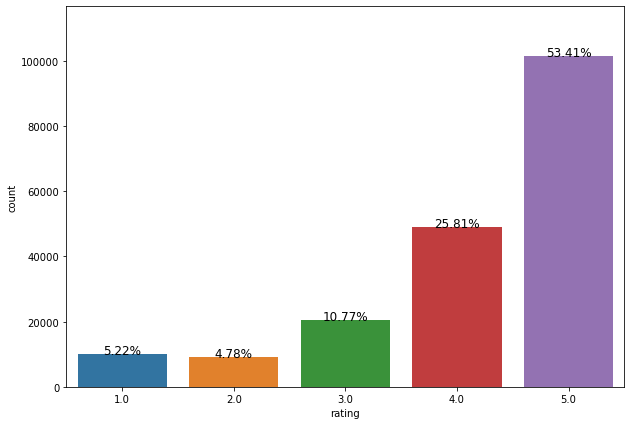

In [447]:
total = len(df_fin)
plt.figure(figsize=(10, 7))
pl = sns.countplot(df_fin['rating'])

sizes = []

for p in pl.patches:
    height = p.get_height()
    sizes.append(height)
    pl.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format((height/total)*100),
            ha="center", fontsize=12)

pl.set_ylim(0, max(sizes) * 1.15)

plt.show()

Over 50% of ratings are 5.0. Users are mostly satisfied with purchased product.

1/3 of buyers drag down max rating. 

There are 10% negative ratings explained by quality of record or delievery problems etc. 

##### 2. High items quality: mean rating of a product will be between 3.5 and 5 

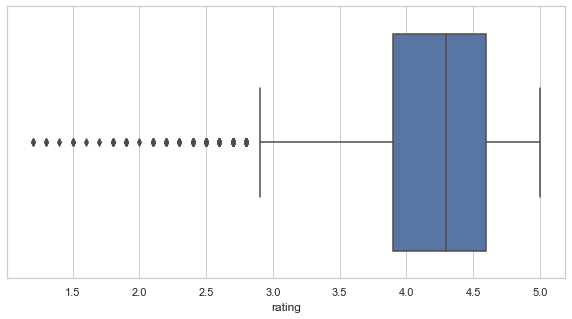

In [448]:
# items' mean rating
mean_rating = df_fin[['product_id', 'rating']].groupby(
    'product_id').mean().sort_values('rating').round(1)
plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=mean_rating['rating'])
plt.show()

Average rating of Amazon items in category Vinyl and CDs is approximately 4.3. 

It can be explained by great quality of products, fast delievery, original and limited editions etc.
However, several outliers with lower score still present.

##### 3. How frequently users rate products and amount of loyal customers 

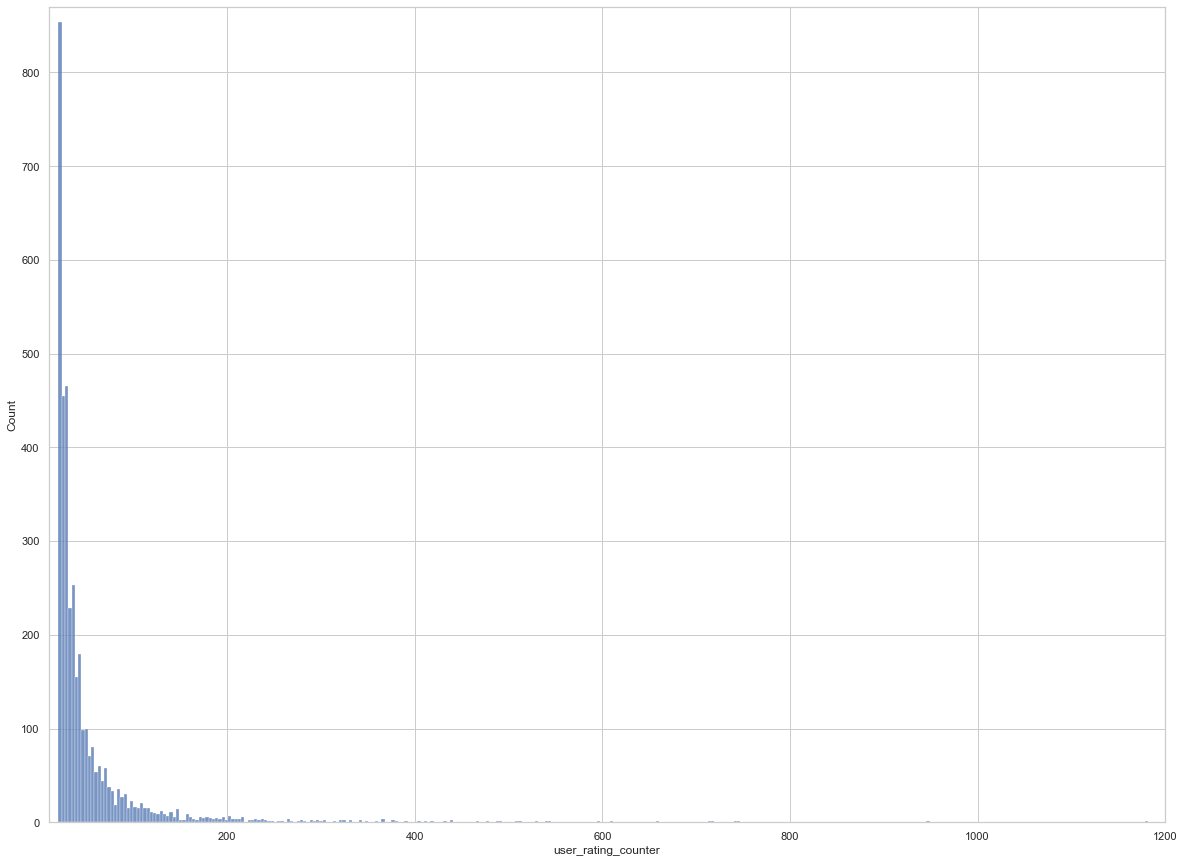

In [449]:
# number of users rating
us_r = df_fin[['user_id', 'user_rating_counter']].drop_duplicates(
    'user_id').sort_values(by='user_rating_counter', ascending=True)

plt.figure(figsize=(20, 15))
sns.set_theme(style="whitegrid")
ax = sns.histplot(x=us_r.user_rating_counter, stat='count')
ax.set(ylim=(0, 870))
ax.set(xlim=(10, 1200))

plt.show()

Vast majority of users rated less than 100 items (main segment).

Among regular customers most have 100-200 purchaces. A few bought 200-600 products. The maximum ratings in sample dataframe per user is 1182.

##### 4. When most ratings were given: either 2002-2006 (peak era for CDs and Vinyl + distribution of online retail) or 2006-2014 (more music releases and Amazon accessibility)

<AxesSubplot:xlabel='timestamp', ylabel='count'>

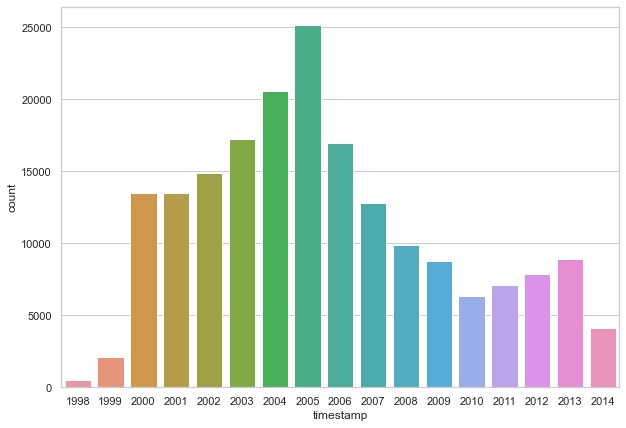

In [451]:
# count ratings per year
plt.figure(figsize=(10, 7))
sns.countplot(df_fin['timestamp'])

Peak year for ratings is 2005. Overall, period from 2002 to 2006 contains most ratings. 

Probably after that other platforms for buying and distribution of music were created + 2014 is the start of streaming era. 

2014 has less ratings compared to 2010s because not full year counted in dataframe, 1998-1999 is still developing of Amazon and Internet shopping is not so spread yet.

##### 5. Relationship between average rating and number of evaluations

In [452]:
data_grouped = df_fin[['product_id', 'rating']].groupby(
    'product_id').mean().reset_index()
df_grouped = data_grouped.merge(
    df_fin[['product_id', 'product_rating_counter']].drop_duplicates('product_id'), how='inner')
df_grouped

,product_id,rating,product_rating_counter
0,0780018664,4.809524,21
1,0780607287,4.714286,14
2,0788806270,4.757576,33
3,078881172X,4.730769,26
4,0790729350,4.548387,31
...,...,...,...
6503,B00J7UL6V6,4.250000,16
6504,B00JDB4PEY,4.037037,27
6505,B00JDB4PLM,4.230769,13
6506,B00JXETVRC,4.304348,23


<Figure size 1080x720 with 0 Axes>

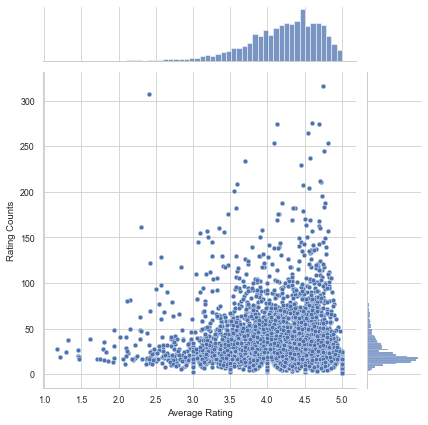

In [453]:
plt.figure(figsize=(15, 10))
sns.set_context('paper')
ax = sns.jointplot(x="rating", y='product_rating_counter',
                   kind='scatter',  data=df_grouped)
ax.set_axis_labels("Average Rating", "Rating Counts")
plt.show()

Poor items (Rating: 1-2.5) rarely get purchased and reviewed more than 50 times. 
Among popular products (>150 ratings) only 2 outliers, on average mean rating more than 3/5.

Area with 4+ rating denser and contains more popular and reviewed products as well.

# Data preprocessing

In [454]:
# Split data into train/test sapmles based on rating year
test_date = df_fin.sort_values('timestamp')['timestamp'].unique()[-4:]
test_date

array([2011, 2012, 2013, 2014], dtype=int64)

In [455]:
# Train: records with ratings in range 1998-2010. Test: records with ratings from 2011 to 2014
split_date = test_date[0]
X_train = df_fin[df_fin['timestamp'] < split_date]
X_test = df_fin[df_fin['timestamp'] >= split_date]
X_train.shape, X_test.shape

((162062, 6), (27994, 6))

In [456]:
# Split df into 85/15
X_test.shape[0]/(X_train.shape[0]+X_test.shape[0])

0.14729342930504694

In [470]:
def get_csr_matrix(data):
    """
    Create a sparse matrix in csr format to save memory.

    Parameters
    ----------
    data: dataframe with columns = ['user_id', 'product_id', 'ratings']
    ------
    """
    users_cat = CategoricalDtype(sorted(data.user_id.unique()), ordered=True)
    product_cat = CategoricalDtype(
        sorted(data.product_id.unique()), ordered=True)

    row = data.user_id.astype(users_cat).cat.codes
    col = data.product_id.astype(product_cat).cat.codes
    sparse_matrix = csr_matrix((data["rating"]/5, (row, col)),
                               shape=(users_cat.categories.size, product_cat.categories.size))

    return sparse_matrix


def from_sparse_format(sparse_matrix, data):
    """
    Generate analogue of pivot table from sparse matrix. 

    Parameters
    ----------
    sparse_matrix: sp.matrix, as (users x items) 
    data: dataframe with columns = ['user_id', 'product_id', 'ratings']
    ----------
    """
    users_cat = CategoricalDtype(sorted(data.user_id.unique()), ordered=True)
    product_cat = CategoricalDtype(
        sorted(data.product_id.unique()), ordered=True)

    dfs = pd.DataFrame.sparse.from_spmatrix(sparse_matrix,
                                            index=users_cat.categories,
                                            columns=product_cat.categories)
    return dfs

In [471]:
df_m = from_sparse_format(get_csr_matrix(df_fin), df_fin)
df_m

,0780018664,0780607287,0788806270,078881172X,0790729350,1573300403,1858704553,1858705223,1858705231,1929243154,...,B00I0O9QJY,B00IIT0CHG,B00IIUAPCM,B00IQE4NUK,B00IWS73PW,B00J7UL6V6,B00JDB4PEY,B00JDB4PLM,B00JXETVRC,B00K5T1LZ4
A08161909WK3HU7UYTMW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1020L7BWW9RAX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1031R8HD3E4GL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A103KNDW8GN92L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A103W7ZPKGOCC9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZSN1TO0JI87B,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZTZ61W23JET0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZVA13Q19KURR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZVH70JMJ2IHX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [473]:
# create dict of enumerate items in dataframe and inverse dict
items_inv_mapping = dict(enumerate(df_m.columns.unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}
print(f'No of products: {len(items_mapping)}')
items_inv_mapping

No of products: 6508


{0: '0780018664',
 1: '0780607287',
 2: '0788806270',
 3: '078881172X',
 4: '0790729350',
 5: '1573300403',
 6: '1858704553',
 7: '1858705223',
 8: '1858705231',
 9: '1929243154',
 10: '5555991584',
 11: '5557530584',
 12: '5558160063',
 13: '5558783532',
 14: '5559291986',
 15: '630025075X',
 16: '6300251020',
 17: '6300270424',
 18: '6300273199',
 19: '6301095294',
 20: '6302213142',
 21: '6302238064',
 22: '6302250056',
 23: '630237250X',
 24: '6302372666',
 25: '6302415993',
 26: '6302775205',
 27: '6302869390',
 28: '6303047564',
 29: '6303058760',
 30: '6303152775',
 31: '6303206204',
 32: '6303234844',
 33: '6303284183',
 34: '6303286542',
 35: '6303303463',
 36: '6303314015',
 37: '6303329071',
 38: '6303337023',
 39: '6303459765',
 40: '6303477259',
 41: '6304235682',
 42: '6304479689',
 43: '6304639457',
 44: '6305131147',
 45: '6305180261',
 46: '6305268177',
 47: '6305459525',
 48: '6305603871',
 49: '6305610444',
 50: '6305846464',
 51: '6305910022',
 52: '7799623519',
 53

In [474]:
# create dict of enumerate users in dataframe and inverse dict
users_inv_mapping = dict(enumerate(df_m.index.unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}
print(f'No of users: {len(users_mapping)}')
users_mapping

No of users: 3713


{'A08161909WK3HU7UYTMW': 0,
 'A1020L7BWW9RAX': 1,
 'A1031R8HD3E4GL': 2,
 'A103KNDW8GN92L': 3,
 'A103W7ZPKGOCC9': 4,
 'A105S56ODHGJEK': 5,
 'A105YVLAZNYQUU': 6,
 'A1065Q31DNPRAN': 7,
 'A107R79K63CE30': 8,
 'A10872FHIJAKKD': 9,
 'A10BYR4GN1D86N': 10,
 'A10DK4W3I14H14': 11,
 'A10DNCYK7YISHU': 12,
 'A10EICDA6FL5VK': 13,
 'A10I9Y44HCRPG': 14,
 'A10ID9PBP48AXN': 15,
 'A10IDVD9INU6FP': 16,
 'A10JF2S8V3HYD4': 17,
 'A10KCGSDJJAVRO': 18,
 'A10LDRKHO99AY6': 19,
 'A10M94ASQEBL56': 20,
 'A10TCQ0SBQU50Y': 21,
 'A10TCTBISG95NU': 22,
 'A10WOHX7AOZ8MU': 23,
 'A10XJR7CWHNKWU': 24,
 'A10XU1ERL5JPV8': 25,
 'A10Y0CLCJ1L4LA': 26,
 'A10Y1BZ88EJO63': 27,
 'A10ZD0AOC1BPOM': 28,
 'A10ZSSZO3BO11Z': 29,
 'A110AP71Q2CS1R': 30,
 'A110LZFBUFYWN7': 31,
 'A111K82VQPY91M': 32,
 'A1134JYIL2MGZW': 33,
 'A1140GVQQ2AJ17': 34,
 'A1143SNKOV0ZIT': 35,
 'A117RJ6J5CO53D': 36,
 'A11BC4PIHPZVJP': 37,
 'A11C3BT4A8M9VG': 38,
 'A11CNSUROWGLEG': 39,
 'A11D1KHM7DVOQK': 40,
 'A11ED8O95W2103': 41,
 'A11EKP8L073NEY': 42,
 'A11H85UYL2R4KX

In [ ]:
# create dict of enumerate users in Test dataframe and inverse dict


# Popularity based Recommender model

Non-personalised type of recommender systems. Can be a simple solution for new users with no history ('cold start problem'). This model recommends all users the same N items based on number of product ratings. 

## Basic Popularity Model

In [457]:
# get mean rating of each product in train sample
data_grouped_tr = X_train[['product_id', 'rating']
                          ].groupby('product_id').mean().reset_index()
data_grouped_tr

,product_id,rating
0,0780018664,4.809524
1,0780607287,4.692308
2,0788806270,4.692308
3,078881172X,4.730769
4,0790729350,4.548387
...,...,...
6314,B00J7UL6V6,4.250000
6315,B00JDB4PEY,3.636364
6316,B00JDB4PLM,4.230769
6317,B00JXETVRC,4.363636


In [458]:
# merge with rate counter of each product_id and descending sorting
df_grouped_tr = X_train[['product_id', 'product_rating_counter']].drop_duplicates(
    'product_id').merge(data_grouped_tr, how='inner', on='product_id')
# Basic popularity model
df_grouped_tr.sort_values(by='product_rating_counter', ascending=False)

,product_id,product_rating_counter,rating
342,B000000IRB,316,4.745342
1096,B00008OWZG,307,2.411552
208,B000002UAT,276,4.652941
211,B000002UB2,274,4.690840
349,B000000IV0,274,3.855422
...,...,...,...
6232,B000001GYJ,1,5.000000
6311,B000060P5O,1,5.000000
6047,B001BWQVW2,1,5.000000
6317,B000GLKLCK,1,5.000000


In [738]:
# Set and print N recommendations = 10
N_recommendations = 10
popularity_model = df_grouped_tr.sort_values(
    by=['product_rating_counter', 'rating'], ascending=[0, 0])
# Choose product with rating >= 4 
popularity_model = popularity_model[popularity_model['rating'] >= 4]
popularity_model.head(N_recommendations)

,product_id,product_rating_counter,rating
342,B000000IRB,316,4.745342
208,B000002UAT,276,4.652941
211,B000002UB2,274,4.690840
209,B000002UAX,265,4.528958
207,B000002UAR,254,4.818182
462,B000002H97,254,4.084848
309,B000002H33,245,4.705128
313,B000002J09,237,4.579439
560,B00004ZAV3,230,4.464646
475,B000002JS6,212,4.693989


Assign rank to products from popularity model

In [739]:
# Generate a recommendation rank based upon score
popularity_model['rank'] = popularity_model['product_rating_counter'].rank(
    ascending=0, method='first')
popularity_model
# Get the top 10 recommendations
ranking_recommendations = popularity_model.head(10)
ranking_recommendations

,product_id,product_rating_counter,rating,rank
342,B000000IRB,316,4.745342,1.0
208,B000002UAT,276,4.652941,2.0
211,B000002UB2,274,4.690840,3.0
209,B000002UAX,265,4.528958,4.0
207,B000002UAR,254,4.818182,5.0
462,B000002H97,254,4.084848,6.0
309,B000002H33,245,4.705128,7.0
313,B000002J09,237,4.579439,8.0
560,B00004ZAV3,230,4.464646,9.0
475,B000002JS6,212,4.693989,10.0


In [740]:
def recommendations_popular(als_model, csr_train):
    """
    Generate dataframe with N recommendations for each user

    Parameters
    ----------
    als_model: AlternatingLeastSquares with tuned params
    csr_train: sparse matrix as (users x items)
    ----------
    """
    preds = []
    batch_size = 50
    to_generate = np.arange(len(users_mapping))
    for startidx in range(0, len(to_generate), batch_size):
        batch = to_generate[startidx: startidx + batch_size]
        ids, scores = als_model.recommend(
            batch, csr_train[batch], N=10, filter_already_liked_items=True)
        for i, userid in enumerate(batch):
            user_id = users_inv_mapping[userid]
            user_items = ids[i]
            article_ids = [items_inv_mapping[item_id]
                           for item_id in user_items]
            preds.append((user_id, ' '.join(article_ids)))

    df_preds = pd.DataFrame(preds, columns=['user_id', 'prediction'])

    print(f'Recommendations for users:')

    return df_preds

In [741]:
def recommendation(user_ID, N_recommendations):
    """
    user_ID: str, ID of user 
    N_recommendations: int, top n recommendations
    """
    user_recommendations = popularity_model.head(N_recommendations)

    cols = user_recommendations.columns.tolist()
    user_recommendations = user_recommendations[cols]

    return user_recommendations

In [742]:
# generate sample of users' id to demostrate same non-personalised recommendations
users = X_train['user_id'].sample(n=3).tolist()

for i in users:
    print(f"Here is recommendations for user: {i}")
    print(recommendation(i, 10))
    print("\n")

Here is recommendations for user: AA6GFSABYPFQO
     product_id  product_rating_counter    rating  rank
342  B000000IRB                     316  4.745342   1.0
208  B000002UAT                     276  4.652941   2.0
211  B000002UB2                     274  4.690840   3.0
209  B000002UAX                     265  4.528958   4.0
207  B000002UAR                     254  4.818182   5.0
462  B000002H97                     254  4.084848   6.0
309  B000002H33                     245  4.705128   7.0
313  B000002J09                     237  4.579439   8.0
560  B00004ZAV3                     230  4.464646   9.0
475  B000002JS6                     212  4.693989  10.0


Here is recommendations for user: A1OBJ2263JCK5
     product_id  product_rating_counter    rating  rank
342  B000000IRB                     316  4.745342   1.0
208  B000002UAT                     276  4.652941   2.0
211  B000002UB2                     274  4.690840   3.0
209  B000002UAX                     265  4.528958   4.0
207  B

Precision:
![Precision](https://miro.medium.com/max/898/0*dQDjsDk8Oz4bz_4N)
Recall:
![Recall](https://miro.medium.com/max/906/0*hQvUN7_CU2dvA7-3)


In [467]:
# Calculating the RMSE of the popularity based recommendation system
# Rating present in the test data is the actual rating
data_tt = X_test
data_tt = data_tt[['user_id', 'product_id', 'rating']]
data_tt.rename(columns={'rating': 'act_rating'}, inplace=True)
data_tt

,user_id,product_id,act_rating
50,A2ZDXPKUF80H5H,B000000GPY,5.0
78,A10JF2S8V3HYD4,B000000GPY,5.0
118,AKGF27HN0OF19,B000000IVW,5.0
121,A2TSHD7SWDGS58,B000000IVW,5.0
145,A3QZ8WR4DD1ZOS,B000000IVW,5.0
...,...,...,...
189988,A200C7YQJ45LRR,B00004YL8S,3.0
189990,A1UH3S1GVFSMFH,B00004YL8S,4.0
190001,AZD7NEVKD2GBX,B0000C23D6,1.0
190003,A2DQL2TQLGUVG,B0000C23D6,1.0


In [468]:
# Merge the train data having average rating with the test data having actual rating at product level
data_tr_tt = pd.merge(
    popularity_model[['product_id', 'rating']], data_tt, on='product_id', how='inner')
data_tr_tt

,product_id,rating,user_id,act_rating
0,B000000IRB,4.745342,A2C7BOQVFH1HLE,5.0
1,B000000IRB,4.745342,A16CZRQL23NOIW,5.0
2,B000000IRB,4.745342,A1VXN0LM7NUQ3L,5.0
3,B000000IRB,4.745342,A1WYIDGR8ZG21X,5.0
4,B000000IRB,4.745342,AZSN1TO0JI87B,5.0
...,...,...,...,...
23717,B003ZDZ1WG,3.500000,A3QOEZ3T545ESV,4.0
23718,B000003G8G,5.000000,AKT8TGIT6VVZ5,5.0
23719,B000003G8G,5.000000,AUDSM2CTLLW1Q,5.0
23720,B000003FEJ,4.000000,A2GWY78Y3YZ1I6,5.0


### Evaluation

DCG:
![DCG](https://lh4.googleusercontent.com/zA6ypnbEED9XOtheukjRqB5gYAftKvU29KiPUk-AwL9EQXkFZSCyIht0wKwY4WQxbzcv_EbtAXcT86AODXWQ_IShQKhgGcnLBdrwakrKzaxapuGwkb4R1Aw7Vez4P5GbELW3MawRqnM)
NDCG:
![NDCG](https://lh5.googleusercontent.com/Vw1V56DgbbYjdezCVkoon5LGj9xsRJsWum0TECdoN1Vcj4UBkR66cBfVvA_Yy842ws27oy4UZq_r0xsLy7DEB62wfIYTLf_YKW9qd5B8nZCPdMrDNiIjmaBv0NwscSfVoJBSYJwUgxQ)

In [469]:
mse_pp = mean_squared_error(data_tr_tt["act_rating"], data_tr_tt["rating"])
rmse_pp = math.sqrt(mse_pp)
print("RMSE for popularity based recommendation system:", rmse_pp)

RMSE for popularity based recommendation system: 1.0681026845811787


1.0681

In [594]:
# Get dataframe with user_id for X_train and their top10 recommendations(ranking_recommendations)
# create list of all unique user_id in X_train
usr_in_tr = X_train['user_id'].unique()
# repeat recommendations for each user because it is the same 10 recs
rr_for_df = ranking_recommendations.append(
    [ranking_recommendations]*(len(usr_in_tr)-1), ignore_index=True)
rr_for_df

,product_id,product_rating_counter,rating,rank
0,B000000IRB,316,4.745342,1.0
1,B00008OWZG,307,2.411552,2.0
2,B000002UAT,276,4.652941,3.0
3,B000002UB2,274,4.690840,4.0
4,B000000IV0,274,3.855422,5.0
...,...,...,...,...
37125,B000002UAX,265,4.528958,6.0
37126,B000002UAR,254,4.818182,7.0
37127,B000002H97,254,4.084848,8.0
37128,B000002H33,245,4.705128,9.0


In [595]:
# List with repeated 10 times users to assign to a df
usr_for_df = list(itertools.chain.from_iterable(
    itertools.repeat(x, 10) for x in usr_in_tr))
len(usr_for_df)

37130

In [597]:
# create dictionary with users, products, ratings, ranks
d = {'user_id': usr_for_df, 'product_id': rr_for_df['product_id'],
     'rating': rr_for_df['rating'],
     'rank':  rr_for_df['rank']}
# generate dataframe
ranking_recommendations_us = pd.DataFrame(
    d).set_index(['user_id', 'product_id'])
ranking_recommendations_us.head(15)

rating  rank
user_id        product_id                
A2GANR9I6XHTU9 B000000IRB  4.745342   1.0
               B00008OWZG  2.411552   2.0
               B000002UAT  4.652941   3.0
               B000002UB2  4.690840   4.0
               B000000IV0  3.855422   5.0
               B000002UAX  4.528958   6.0
               B000002UAR  4.818182   7.0
               B000002H97  4.084848   8.0
               B000002H33  4.705128   9.0
               B000002J09  4.579439  10.0
ANCOMAI0I7LVG  B000000IRB  4.745342   1.0
               B00008OWZG  2.411552   2.0
               B000002UAT  4.652941   3.0
               B000002UB2  4.690840   4.0
               B000000IV0  3.855422   5.0

In [347]:
#set indices in data_tt
df_true = data_tt.set_index(['user_id', 'product_id'])
df_true.head()

,,act_rating
user_id,product_id,
A2ZDXPKUF80H5H,B000000GPY,5.0
A10JF2S8V3HYD4,B000000GPY,5.0
AKGF27HN0OF19,B000000IVW,5.0
A2TSHD7SWDGS58,B000000IVW,5.0
A3QZ8WR4DD1ZOS,B000000IVW,5.0


In [609]:
# set indices in train data to merge with recommendations
df_train = X_train[['user_id', 'product_id', 'rating']].rename(
    {'rating': 'tr_rating'}, axis=1).set_index(['user_id', 'product_id'])
df_train

,,tr_rating
user_id,product_id,
A2GANR9I6XHTU9,0780018664,4.0
ANCOMAI0I7LVG,0780018664,5.0
A1GGOC9PVDXW7Z,0780018664,5.0
A62G4QX6XQVLP,0780018664,5.0
A2XKQHB8VCUCJK,0780018664,5.0
...,...,...
A2AIMXT9PLAM12,B000001G53,5.0
A328S9RN3U5M68,B00004TEUZ,5.0
A2AIMXT9PLAM12,B00004TEUZ,5.0


In [619]:
#merge test ratings with recommendations
df_merged = ranking_recommendations_us.join(df_true,  how='left')
df_merged = df_merged.sort_values(by=['user_id', 'rank'])
df_merged.head(20)

rating  rank  act_rating
user_id              product_id                            
A08161909WK3HU7UYTMW B000000IRB  4.745342   1.0         NaN
                     B00008OWZG  2.411552   2.0         NaN
                     B000002UAT  4.652941   3.0         NaN
                     B000002UB2  4.690840   4.0         NaN
                     B000000IV0  3.855422   5.0         NaN
                     B000002UAX  4.528958   6.0         NaN
                     B000002UAR  4.818182   7.0         NaN
                     B000002H97  4.084848   8.0         NaN
                     B000002H33  4.705128   9.0         NaN
                     B000002J09  4.579439  10.0         NaN
A1020L7BWW9RAX       B000000IRB  4.745342   1.0         NaN
                     B00008OWZG  2.411552   2.0         NaN
                     B000002UAT  4.652941   3.0         NaN
                     B000002UB2  4.690840   4.0         NaN
                     B000000IV0  3.855422   5.0         NaN
                     B000002UAX  4.528958   6.0         NaN
                     B000002UAR  4.818182   7.0         NaN
                     B000002H97  4.084848   8.0         NaN
                     B000002H33  4.705128   9.0         NaN
                     B000002J09  4.579439  10.0         NaN

In [620]:
#merge train ratings with recommendations
df_merged = df_merged.join(df_train,  how='left')
#combine columns act_rating and tr_rating
df_merged.act_rating.fillna(df_merged.tr_rating, inplace=True)
#delete column tr_rating
del df_merged['tr_rating']
df_merged.head(20)

rating  rank  act_rating
user_id              product_id                            
A08161909WK3HU7UYTMW B000000IRB  4.745342   1.0         NaN
                     B00008OWZG  2.411552   2.0         NaN
                     B000002UAT  4.652941   3.0         NaN
                     B000002UB2  4.690840   4.0         NaN
                     B000000IV0  3.855422   5.0         NaN
                     B000002UAX  4.528958   6.0         NaN
                     B000002UAR  4.818182   7.0         NaN
                     B000002H97  4.084848   8.0         NaN
                     B000002H33  4.705128   9.0         NaN
                     B000002J09  4.579439  10.0         NaN
A1020L7BWW9RAX       B000000IRB  4.745342   1.0         NaN
                     B00008OWZG  2.411552   2.0         NaN
                     B000002UAT  4.652941   3.0         NaN
                     B000002UB2  4.690840   4.0         NaN
                     B000000IV0  3.855422   5.0         NaN
                     B000002UAX  4.528958   6.0         NaN
                     B000002UAR  4.818182   7.0         NaN
                     B000002H97  4.084848   8.0         NaN
                     B000002H33  4.705128   9.0         NaN
                     B000002J09  4.579439  10.0         NaN

In [612]:
#df_merged['reciprocal_rank'] = 1 / df_merged['rank']
#df_merged

In [621]:
df_merged[df_merged['act_rating'].notnull()]

rating  rank  act_rating
user_id        product_id                            
A103KNDW8GN92L B000000IRB  4.745342   1.0         5.0
A105YVLAZNYQUU B000002H97  4.084848   8.0         1.0
               B000002H33  4.705128   9.0         5.0
A1065Q31DNPRAN B000002H97  4.084848   8.0         5.0
A10EICDA6FL5VK B000002J09  4.579439  10.0         5.0
...                             ...   ...         ...
AZDVOFC2MTIM5  B000002UAR  4.818182   7.0         5.0
AZFCS75RSV25W  B000000IRB  4.745342   1.0         5.0
AZSN1TO0JI87B  B000000IRB  4.745342   1.0         5.0
               B00008OWZG  2.411552   2.0         3.0
               B000000IV0  3.855422   5.0         5.0

[2702 rows x 3 columns]

In [383]:
df_merged['cumulative_rank'] = df_merged.groupby(
    level='user_id').cumcount() + 1
df_merged['cumulative_rank'] = df_merged['cumulative_rank'] / df_merged['rank']
df_merged['users_item_count'] = df_merged.groupby(
    level='user_id')['rank'].transform(np.size)
df_merged.head(10)

act_rating  rating  rank  reciprocal_rank  \
user_id              product_id                                              
A08161909WK3HU7UYTMW B000099T2L         5.0     NaN   NaN              NaN   
                     B00000I0QI         5.0     NaN   NaN              NaN   
                     B000002MHJ         5.0     NaN   NaN              NaN   
                     B00005OMGE         4.0     NaN   NaN              NaN   
                     B00004UAL5         5.0     NaN   NaN              NaN   
                     B0002B166O         5.0     NaN   NaN              NaN   
A1020L7BWW9RAX       B00096S3TU         4.0     NaN   NaN              NaN   
A1031R8HD3E4GL       B000E6UK5K         4.0     NaN   NaN              NaN   
                     B00AB16ER6         5.0     NaN   NaN              NaN   
                     B000B5Y03C         5.0     NaN   NaN              NaN   

                                 cumulative_rank  users_item_count  
user_id              product_id                                     
A08161909WK3HU7UYTMW B000099T2L              NaN                 6  
                     B00000I0QI              NaN                 6  
                     B000002MHJ              NaN                 6  
                     B00005OMGE              NaN                 6  
                     B00004UAL5              NaN                 6  
                     B0002B166O              NaN                 6  
A1020L7BWW9RAX       B00096S3TU              NaN                 1  
A1031R8HD3E4GL       B000E6UK5K              NaN                 6  
                     B00AB16ER6              NaN                 6  
                     B000B5Y03C              NaN                 6

In [622]:
users_count = df_merged[df_merged['rank'].notnull(
)].index.get_level_values('user_id').nunique()
users_count

3713

In [390]:
map10 = (df_merged["cumulative_rank"] /
         df_merged["users_item_count"]).sum() / users_count
print(f"MAP@10 = {map10}")

MAP@10 = 0.07399546940269278


In [626]:
df_merged

rating  rank  act_rating
user_id              product_id                            
A08161909WK3HU7UYTMW B000000IRB  4.745342   1.0         NaN
                     B00008OWZG  2.411552   2.0         NaN
                     B000002UAT  4.652941   3.0         NaN
                     B000002UB2  4.690840   4.0         NaN
                     B000000IV0  3.855422   5.0         NaN
...                                   ...   ...         ...
AZYZA8FDL48GD        B000002UAX  4.528958   6.0         NaN
                     B000002UAR  4.818182   7.0         NaN
                     B000002H97  4.084848   8.0         NaN
                     B000002H33  4.705128   9.0         NaN
                     B000002J09  4.579439  10.0         NaN

[37130 rows x 3 columns]

In [760]:
def ndcg_score_pp(ratings, k):
    """
    Normalized discounted cumulative gain (NDCG) at rank k
    for the ALS model; which computes the ndcg score for
    each users' recommendation and does a simply average
    
    Parameters
    ----------
    ratings : scipy sparse csr_matrix [n_users, n_items]
        sparse matrix of user-item interactions

    k : int
        rank k's k
        
    Returns
    -------
    avg_ndcg : float
        ndcg at k's score averaged across all users
    """
    ndcg = 0.0
    n_users, n_items = ratings.shape
    for u in range(n_users): 
        y_true = np.zeros(n_items) 
        y_true[ratings[u].indices] = 1
        u_pred = list(ranking_recommendations['product_id'].map(items_mapping))
        ndcg += ndcg_at_k_pp(y_true, u_pred, k)
        
    avg_ndcg = ndcg / n_users
    return avg_ndcg


def ndcg_at_k_pp(y_true, y_score, k = 10):
    """
    Normalized discounted cumulative gain (NDCG) at rank k
    
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)
    
    y_score : array-like, shape = [n_samples]
        Predicted scores
    
    k : int
        Rank

    Returns
    -------
    ndcg : float, 0.0 ~ 1.0
    """
    dcg = dcg_at_k_pp(y_true, k)
    idcg = dcg_at_k_pp_b(y_true, k) 
    ndcg = dcg / idcg
    return ndcg


def dcg_at_k_pp(y_true, k = 10):
    """
    Discounted cumulative gain (DCG) at rank k
    
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)
    
    y_score : array-like, shape = [n_samples]
        Predicted scores
    
    k : int
        Rank

    Returns
    -------
    dcg : float
    """
    popular_id = list(ranking_recommendations['product_id'].map(items_mapping)) 
    y_true = np.take(y_true, popular_id)
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(2, gains.size + 2))
    dcg = np.sum(gains / discounts)
    return dcg

def dcg_at_k_pp_b(y_true, k = 10):
    """
    Discounted cumulative gain (DCG) at rank k
    
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)
    
    k : int
        Rank

    Returns
    -------
    dcg_b : idcg, float
    """
    y_true_id = np.argsort(y_true)[::-1]
    y_true = np.take(y_true, y_true_id[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(2, gains.size + 2))
    dcg_b = np.sum(gains / discounts)    
    return dcg_b

In [761]:
#compute NDCG10 for Popularity Based Model
ndcg_pp = ndcg_score_pp(get_csr_matrix(df_fin), 10)
ndcg_pp

0.07213613584908865

# Collaborative Filtering

Since df_fin contains less users than items, it makes sense to explore item-item collaborative filtering first

## Nearest Neighbors

In [475]:
class Recommender_KNN:
    def _inference(self, data, item, n_recommendations):
        """
        return top n similar item recommendations based on user's input item

        Parameters
        ----------
        data: item-user matrix
        item: str, ID of user input item
        n_recommendations: int, top n recommendations
        ----------
        """
        # fit
        cf_knn = NearestNeighbors(
            metric='cosine', algorithm='brute', n_jobs=-1)
        cf_knn.fit(get_csr_matrix(df_fin).T)
        print('Find similar items to', item)
        # inference
        print('Recommendation system start to make inference')
        print('......\n')
        t0 = time.time()
        distances, indices = cf_knn.kneighbors(
            np.array(data.iloc[items_mapping[item], :]).reshape(1, -1),
            n_neighbors=n_recommendations+1)
        # get list of raw idx of recommendations
        raw_recommends = \
            list(
                zip(
                    indices.squeeze().tolist(),
                    distances.squeeze().tolist()
                )
            )
        print('It took my system {:.2f}s to make inference \n\
              '.format(time.time() - t0))
        # return recommendation (product_id, distance)
        return raw_recommends

    def make_recommendations(self, item, n_recommendations):
        """
        make top n item recommendations

        Parameters
        ----------
        item: str, ID of user input item
        n_recommendations: int, top n recommendations
        ----------
        """
        # get recommendations
        raw_recommends = self._inference(df_m.T,
                                         item, n_recommendations)
        for i, (idx, dist) in enumerate(raw_recommends):
            if i == 0:
                print('Recommendations for {0}:\n'.format(item))
            else:
                print('{0}: {1}, with distance '
                      'of {2}'.format(i, items_inv_mapping[idx], dist))

In [476]:
# Find similar items accordind to NN Model
recommender = Recommender_KNN()
recommender.make_recommendations(
    item=items_inv_mapping[13], n_recommendations=10)

Find similar items to 5558783532
Recommendation system start to make inference
......

It took my system 0.06s to make inference 
              
Recommendations for 5558783532:

1: B000003S0M, with distance of 0.4601998889574317
2: B000003S0P, with distance of 0.5218103942980056
3: B000003S0F, with distance of 0.5308461089743404
4: B000003S0B, with distance of 0.5352096072459446
5: B000003S09, with distance of 0.5609756116846227
6: B00008BXJF, with distance of 0.5846173303669564
7: B000003S0D, with distance of 0.5848845684473525
8: B000003S1C, with distance of 0.6114030238564128
9: B000003S1A, with distance of 0.6345263109970833
10: B000002J1H, with distance of 0.6584132278034989


# Matrix Factorization

Matrix factorization is a factorization of a matrix into a product of matrices. In the case of collaborative filtering, matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices. One matrix can be seen as the user matrix where rows represent users and columns are latent factors. The other matrix is the item matrix where rows are latent factors and columns represent items.

More info: https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1

## Alternating Least Squares

![ALS](https://www.researchgate.net/profile/Serkan-Ayvaz/publication/338721765/figure/fig2/AS:894097657184256@1590180901710/Alternating-Least-Squares-Method.jpg)

In [477]:
def get_coo_matrix(df,
                   user_col='user_id',
                   product_col='product_id',
                   weight_col='rating',
                   users_mapping=users_mapping,
                   items_mapping=items_mapping):
    """ 
    Turn a dataframe into a COO sparse items x users matrix 

    Parameters
    ----------
    df: item-user matrix
    item: str, ID of user input item
    n_recommendations: int, top n recommendations
    ----------
    """

    weights = df[weight_col].astype(np.int32)

    interaction_matrix = sp.coo_matrix((
        weights/5,
        (
            df[user_col].map(users_mapping.get),
            df[product_col].map(items_mapping.get)
        )
    ))
    return interaction_matrix


def get_val_matrices():
    """ Split dataframe into training and test and create various matrices

        Returns a dictionary with the following keys:
            coo_train: training data in COO sparse format and as (users x items)
            csr_train: training data in CSR sparse format and as (users x items)
            csr_test:  test data in CSR sparse format and as (users x items)

    """
    coo_train = get_coo_matrix(X_train)
    coo_test = get_coo_matrix(X_test)

    csr_train = coo_train.tocsr()
    csr_test = coo_test.tocsr()

    return {'coo_train': coo_train,
            'csr_train': csr_train,
            'csr_test': csr_test}


def validate(matrices, factors=200, iterations=20, regularization=0.01, show_progress=True):
    """ Training and validating ALS model from Implicit library with metric: MAP@K (K=10)

        Parameters
        ----------
        matrices: dict from get_val_matrices(), sp.matrix (user x items)
        factors: int, the number of latent factors to compute
        iterations: int, the number of ALS iterations to use when fitting data
        regularization: float, the regularization factor to use
        use_cg: bool, use a faster Conjugate Gradient solver to calculate factors
        ----------

    """
    coo_train, csr_train, csr_test = matrices['coo_train'], matrices['csr_train'], matrices['csr_test']

    model = AlternatingLeastSquares(factors=factors,
                                    iterations=iterations,
                                    regularization=regularization,
                                    random_state=42)

    model.fit(coo_train, show_progress=show_progress)

    map10 = mean_average_precision_at_k(
        model, csr_train, csr_test, K=10, show_progress=show_progress, num_threads=4)
    print(f"Factors: {factors:>3} - Iterations: {iterations:>2} - Regularization: {regularization:4.3f} ==> MAP@10: {map10:6.5f}")
    return map10

In [478]:
matrices = get_val_matrices()
matrices

{'coo_train': <3713x6508 sparse matrix of type '<class 'numpy.float64'>'
 	with 162062 stored elements in COOrdinate format>,
 'csr_train': <3713x6508 sparse matrix of type '<class 'numpy.float64'>'
 	with 162062 stored elements in Compressed Sparse Row format>,
 'csr_test': <3713x6507 sparse matrix of type '<class 'numpy.float64'>'
 	with 27994 stored elements in Compressed Sparse Row format>}

Average Precision:
![AP@K](https://miro.medium.com/max/472/1*g6TjtstbGielzS-LXlSeMA.png)
mean Average Precision:
![MAP@K](https://miro.medium.com/max/396/1*uOrC8Kx4DGO6DV6z91HdIg.png)

In [483]:
%%time
#Find best parameters fo als model, evaluate by MAP10
best_map10 = 0
for factors in np.arange(50, 351, 50): 
    for iterations in np.arange(4, 10, 2):  # 4-12 iterations are optimal
        for regularization in [0.01, 0.001]:
            map10 = validate(matrices, factors, iterations,
                             regularization, show_progress=False)
            if map10 > best_map10:
                best_map10 = map10
                best_params = {
                    'factors': factors, 'iterations': iterations, 'regularization': regularization}
                print(f"Best MAP@10 found. Updating: {best_params}")

Factors:  50 - Iterations:  4 - Regularization: 0.010 ==> MAP@10: 0.03076
Best MAP@10 found. Updating: {'factors': 50, 'iterations': 4, 'regularization': 0.01}
Factors:  50 - Iterations:  4 - Regularization: 0.001 ==> MAP@10: 0.03080
Best MAP@10 found. Updating: {'factors': 50, 'iterations': 4, 'regularization': 0.001}
Factors:  50 - Iterations:  6 - Regularization: 0.010 ==> MAP@10: 0.03106
Best MAP@10 found. Updating: {'factors': 50, 'iterations': 6, 'regularization': 0.01}
Factors:  50 - Iterations:  6 - Regularization: 0.001 ==> MAP@10: 0.03106
Factors:  50 - Iterations:  8 - Regularization: 0.010 ==> MAP@10: 0.03129
Best MAP@10 found. Updating: {'factors': 50, 'iterations': 8, 'regularization': 0.01}
Factors:  50 - Iterations:  8 - Regularization: 0.001 ==> MAP@10: 0.03128
Factors: 100 - Iterations:  4 - Regularization: 0.010 ==> MAP@10: 0.03428
Best MAP@10 found. Updating: {'factors': 100, 'iterations': 4, 'regularization': 0.01}
Factors: 100 - Iterations:  4 - Regularization: 0.

In [484]:
#print best parametrs
best_params

{'factors': 200, 'iterations': 6, 'regularization': 0.001}

In [485]:
# fit als_model with best parametrs
als_model = AlternatingLeastSquares(**best_params)
als_model.fit(matrices['coo_train'])

  0%|          | 0/6 [00:00<?, ?it/s]

In [486]:
def recommendations_als(als_model, csr_train):
    """
    Generate dataframe with N recommendations for each user

    Parameters
    ----------
    als_model: AlternatingLeastSquares with tuned params
    csr_train: sparse matrix as (users x items)
    ----------
    """
    preds = []
    batch_size = 50
    to_generate = np.arange(len(users_mapping))
    for startidx in range(0, len(to_generate), batch_size):
        batch = to_generate[startidx: startidx + batch_size]
        ids, scores = als_model.recommend(
            batch, csr_train[batch], N=10, filter_already_liked_items=True)
        for i, userid in enumerate(batch):
            user_id = users_inv_mapping[userid]
            user_items = ids[i]
            article_ids = [items_inv_mapping[item_id]
                           for item_id in user_items]
            preds.append((user_id, ' '.join(article_ids)))

    df_preds = pd.DataFrame(preds, columns=['user_id', 'prediction'])

    print(f'Recommendations for users:')

    return df_preds

In [487]:
# Get 10 recommendations for every user with ALS model
recommendations_als(als_model, matrices['csr_train'])

Recommendations for users:


,user_id,prediction
0,A08161909WK3HU7UYTMW,B00004UAL5 B00008CQUJ B0000A4G4O B000038IE0 B0...
1,A1020L7BWW9RAX,B0007NFL18 B0001AP12G B00004S51H B0002WZT20 B0...
2,A1031R8HD3E4GL,B00005UEAR B000002JKA B000021XS0 B000002JPA B0...
3,A103KNDW8GN92L,B000002J2F B00003002C B0000033P2 B000003S0M B0...
4,A103W7ZPKGOCC9,B0000025F7 B000001A6N B000001AJO B000001AKC B0...
...,...,...
3708,AZSN1TO0JI87B,B0002IU988 B0001M2DKM B000001Y6V B00005NHJK B0...
3709,AZTZ61W23JET0,B000002UUX B0000028M7 B000002JNJ B000002JOH B0...
3710,AZVA13Q19KURR,B000AL730O B000001EG4 B002BSHWUU B000001EM3 B0...
3711,AZVH70JMJ2IHX,B0000AGWFX B000000W5P B0002IVN9W B0006L16N8 B0...


In [488]:
# find similar items to input number (items_inv_mapping for matching number to product_id)
related = als_model.similar_items(itemid=13)

print(f'Items similar to: {items_inv_mapping[13]}')

recommendations_ALS = pd.DataFrame(data={'item_id': related[0], 'similarity': related[1]}).sort_values(by='similarity',
                                                                                                       ascending=False)
recommendations_ALS.index = np.arange(0, len(related[0]))
recommendations_ALS['item_id'] = recommendations_ALS['item_id'].map(
    items_inv_mapping)
recommendations_ALS[1:]

Items similar to: 5558783532


,item_id,similarity
1,B000003S0M,0.808460
2,B000003S0B,0.695332
3,B000003S0F,0.675872
4,B000003S0P,0.660798
5,B000003S1G,0.628209
6,B000003S26,0.615303
7,B00008BXJF,0.600655
8,B000003S09,0.588240
9,B000003S0D,0.586812


### Evaluation

In [ ]:
#compute RMSE for ALS model
user_ratings_mean = np.mean(df_m, axis=1)
user_ratings_mean

In [589]:
# calculate predicted ratings
user_pred_ratings_als = als_model.user_factors.dot(als_model.item_factors.T)
# create dataframe with items' predicted ratings
preds_als = pd.DataFrame(user_pred_ratings_als,
                     columns=df_m.columns, index=df_m.index)
preds_als_np = preds_als.to_numpy()

# Now RMSE can be calculated only for those elements which are not NaN
# So, we find the difference of the actual & pred numpy array, where actual is
# 'ratings_np_nan' whereas predicted one is 'preds_np'...

diff_als = np.subtract(df_m.to_numpy(), preds_als_np)
sq_diff_als = np.square(diff_als)

mse_als = sq_diff_als[~np.isnan(sq_diff_als)].mean()
rmse_als = math.sqrt(mse_als)
print('RMSE_ALS = ', rmse_als)

RMSE_ALS =  0.06205056957353492


In [764]:
#Reference: http://ethen8181.github.io/machine-learning/recsys/2_implicit.html#NDCG
def ndcg_score(model, ratings, k):
    """
    Normalized discounted cumulative gain (NDCG) at rank k
    for the ALS model; which computes the ndcg score for
    each users' recommendation and does a simply average
    
    Parameters
    ----------
    model : fitted ALS model

    ratings : scipy sparse csr_matrix [n_users, n_items]
        sparse matrix of user-item interactions

    k : int
        rank k's k
        
    Returns
    -------
    avg_ndcg : float
        ndcg at k's score averaged across all users
    """
    ndcg = 0.0
    n_users, n_items = ratings.shape
    for u in range(n_users):
        y_true = np.zeros(n_items)
        y_true[ratings[u].indices] = 1
        print(u)
        print(y_true)
        u_pred = _predict_user(u)
        print(f'u_pred = {u_pred}')
        ndcg += ndcg_at_k(y_true, u_pred, k)
        print(f'ndcg = {ndcg}')
        
    avg_ndcg = ndcg / n_users
    return avg_ndcg


def ndcg_at_k(y_true, y_score, k = 10):
    """
    Normalized discounted cumulative gain (NDCG) at rank k
    
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)
    
    y_score : array-like, shape = [n_samples]
        Predicted scores
    
    k : int
        Rank

    Returns
    -------
    ndcg : float, 0.0 ~ 1.0
    """
    actual = dcg_at_k(y_true, y_score, k)
    best = dcg_at_k(y_true, y_true, k) 
    ndcg = actual / best
    return ndcg


def dcg_at_k(y_true, y_score, k = 10):
    """
    Discounted cumulative gain (DCG) at rank k
    
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)
    
    y_score : array-like, shape = [n_samples]
        Predicted scores
    
    k : int
        Rank

    Returns
    -------
    dcg : float
    """
    order = np.argsort(y_score)[::-1] #descending sort, get indices of values in y_score
    y_true = np.take(y_true, order[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(2, gains.size + 2))
    dcg = np.sum(gains / discounts)
    print(f'dcg = {dcg}')
    return dcg

def predict():
    """predict ratings for every user and item"""
    prediction = als_model.user_factors.dot(als_model.item_factors.T)
    return prediction
    
def _predict_user(user):
    """
    returns the predicted ratings for the specified user,
    this is mainly used in computing evaluation metric
    """
    user_pred = als_model.user_factors[user].dot(als_model.item_factors.T)
    return user_pred

In [672]:
y_true = np.zeros(6507)
y_true[matrices['csr_test'][34].indices] = 1
y_true

array([0., 0., 0., ..., 0., 0., 0.])

In [673]:
u_pred = _predict_user(34)
u_pred

array([-0.01014713, -0.00498991, -0.00348768, ...,  0.00538145,
       -0.00119076, -0.01392659], dtype=float32)

In [674]:
order = np.argsort(u_pred)[::-1]
order

array([1429, 1355, 1499, ..., 4217, 1822, 1368], dtype=int64)

In [675]:
y_true = np.take(y_true, order[:10])
y_true

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [676]:
gains = 2 ** y_true - 1
gains

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [677]:
discounts = np.log2(np.arange(2, gains.size + 2))
discounts

array([1.        , 1.5849625 , 2.        , 2.32192809, 2.5849625 ,
       2.80735492, 3.        , 3.169925  , 3.32192809, 3.45943162])

In [678]:
dcg = np.sum(gains / discounts)
dcg

0.0

In [767]:
k = 10
ndcg_fin = ndcg_score(als_model, ratings = get_csr_matrix(df_fin), k = k)
ndcg_train = ndcg_score(als_model, ratings = matrices['csr_train'], k = k)
ndcg_test = ndcg_score(als_model, matrices['csr_test'], k = k)
print('ndcg training:', ndcg_train)
print('ndcg testing:', ndcg_test)

0
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00255369 -0.00018132  0.00751285 ...  0.00354224  0.00583402
  0.00445641]
dcg = 3.304666305987414
dcg = 4.543559338088345
ndcg = 0.727329844310522
1
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00426798 -0.00145164  0.00400356 ... -0.00042449 -0.00618173
 -0.00406261]
dcg = 3.8004993437457815
dcg = 4.543559338088345
ndcg = 1.5637884576902257
2
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01115033  0.00028998 -0.00109776 ... -0.00774222  0.00285376
 -0.00325503]
dcg = 2.4199945798893454
dcg = 4.543559338088345
ndcg = 2.096409339209852
3
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01922842 -0.01723928  0.03076253 ...  0.00301125 -0.01342064
  0.00778129]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 3.096409339209852
4
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02191745 -0.0045443   0.03747703 ...  0.00148314  0.00742989
 -0.0175567 ]
dcg = 3.7260299727804114
dcg = 4.543559338088345
ndcg = 3.9164778571986805
5
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00349395  0.00674483 

 -0.00465327]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 65.97313011988732
88
[0. 1. 0. ... 0. 0. 0.]
u_pred = [-0.00338724  0.01954158  0.01127497 ...  0.00267117 -0.01106756
 -0.00542919]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 66.90950933168837
89
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01438918 -0.01052     0.00661814 ...  0.00278288  0.00363436
  0.01177797]
dcg = 2.8739897479140213
dcg = 4.543559338088345
ndcg = 67.54205081162934
90
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01581497 -0.00135152 -0.00658017 ... -0.00266608  0.00609056
 -0.0091001 ]
dcg = 3.1342774332557095
dcg = 4.543559338088345
ndcg = 68.2318794679828
91
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00868948  0.00234092  0.01650167 ...  0.00440787 -0.00019146
  0.00548715]
dcg = 2.3506711379627383
dcg = 4.543559338088345
ndcg = 68.74924283072293
92
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00146331  0.01218644  0.03055568 ...  0.00051982 -0.00197845
  0.00849967]
dcg = 3.6056963016513954
dcg = 4.54355933808

dcg = 2.4199945798893454
dcg = 4.543559338088345
ndcg = 104.99687411579163
136
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0087803  -0.00303504  0.0104193  ... -0.00688865 -0.00066423
 -0.0045781 ]
dcg = 2.2354594566750743
dcg = 4.543559338088345
ndcg = 105.48888033609899
137
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00090555  0.00245226 -0.00926093 ...  0.00162538  0.01646492
  0.00017739]
dcg = 3.14018072045722
dcg = 4.543559338088345
ndcg = 106.18000825735959
138
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02673139  0.03576031  0.04897321 ... -0.00805433  0.00718311
  0.00222627]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 107.18000825735959
139
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.05195524  0.04188102  0.04251597 ...  0.00084541  0.00491659
 -0.00618713]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 108.18000825735959
140
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00330599  0.00613982  0.01649582 ...  0.00075761 -0.00585413
  0.00534142]
dcg = 4.242529342424365
dcg = 4.543559338088345
n

189
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00092288 -0.02926283 -0.06101622 ...  0.01574232  0.00021672
  0.0134612 ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 146.55695286904435
190
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-1.7607437e-02 -8.0124624e-03  2.8567448e-02 ...  3.8084313e-03
 -3.8477592e-05 -6.3180774e-03]
dcg = 2.7494891145433735
dcg = 4.543559338088345
ndcg = 147.16209278468153
191
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00952672  0.00589485  0.00714347 ...  0.00421001 -0.0062415
 -0.00060426]
dcg = 2.0177825608059994
dcg = 4.543559338088345
ndcg = 147.6061901124948
192
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0097621  -0.00035747 -0.00100311 ... -0.00485609 -0.00204441
 -0.00300448]
dcg = 3.18945462469975
dcg = 4.543559338088345
ndcg = 148.30816281437254
193
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02231985  0.0035709   0.02285813 ...  0.00809489  0.03815454
  0.0132147 ]
dcg = 3.538553940861261
dcg = 4.543559338088345
ndcg = 149.08696940135772
194
[0. 0. 0. ... 0. 0. 0.]
u_pre

dcg = 4.543559338088345
ndcg = 177.52146546991085
233
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01978842 -0.00550255 -0.05002563 ...  0.01792493  0.02658471
 -0.00242316]
dcg = 3.939029634984729
dcg = 4.543559338088345
ndcg = 178.3884134597751
234
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00708294 -0.00215387  0.00943861 ... -0.01838127 -0.00407821
 -0.00274195]
dcg = 3.871887274194594
dcg = 4.543559338088345
ndcg = 179.24058396885965
235
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02066303 -0.02632346 -0.00323371 ...  0.00121484  0.00135385
 -0.00625738]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 180.24058396885965
236
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00603368  0.00394728 -0.00027459 ... -0.01280563 -0.00382857
 -0.00144118]
dcg = 2.894939644978184
dcg = 4.543559338088345
ndcg = 180.87773634864925
237
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01246848  0.00068927  0.00829568 ... -0.00477033  0.0049156
 -0.00026627]
dcg = 2.8026018174652085
dcg = 4.543559338088345
ndcg = 181.49456593288537
2

u_pred = [0.00267988 0.00558387 0.01067632 ... 0.01430717 0.01868463 0.03326409]
dcg = 3.894761127969283
dcg = 4.543559338088345
ndcg = 224.41540467418017
290
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.04354685 0.00695103 0.01494787 ... 0.0088913  0.01221164 0.02618639]
dcg = 4.210226004755012
dcg = 4.543559338088345
ndcg = 225.3420407520808
291
[0. 1. 1. ... 0. 0. 0.]
u_pred = [ 0.00073011  0.19278795  0.08266953 ...  0.00098012 -0.00279255
 -0.00086933]
dcg = 4.210226004755012
dcg = 4.543559338088345
ndcg = 226.26867682998144
292
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.03081693  0.03602488  0.04590222 ...  0.01885871  0.02742111
 -0.00363895]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 227.26867682998144
293
[0. 0. 0. ... 1. 0. 0.]
u_pred = [-0.00717763  0.00276623 -0.01616815 ...  0.04434403  0.02896794
  0.02326212]
dcg = 3.2494891145433735
dcg = 4.543559338088345
ndcg = 227.98386262876767
294
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.01352735 0.00336745 0.015477   ... 0.00879079 0.0033

dcg = 4.543559338088345
ndcg = 283.026632519583
364
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00678456  0.00396186  0.00707573 ... -0.00298126  0.00691628
 -0.0052172 ]
dcg = 2.4484591188793923
dcg = 4.543559338088345
ndcg = 283.56551821176583
365
[1. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.03747233 -0.01222355  0.02797322 ... -0.00064952 -0.00403233
 -0.00555716]
dcg = 3.6056963016513954
dcg = 4.543559338088345
ndcg = 284.35910227953076
366
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.04228666 -0.07500924 -0.0107501  ...  0.0740613   0.01395341
  0.0477182 ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 285.35910227953076
367
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01667285  0.01738162 -0.0003603  ...  0.00800485  0.0121788
  0.0043144 ]
dcg = 4.228094461302617
dcg = 4.543559338088345
ndcg = 286.289671057594
368
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01576845  0.01765055  0.0592481  ...  0.04001399 -0.0290816
  0.03432479]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 287.22605026939505
369


 -0.01474091]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 329.3615174278781
422
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0099258  -0.00837476 -0.00297399 ...  0.00390003 -0.00103857
  0.01786334]
dcg = 3.1215002696767944
dcg = 4.543559338088345
ndcg = 330.0485339357312
423
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01989351  0.11364096 -0.02209423 ... -0.05800294 -0.02467065
 -0.04377795]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 331.0485339357312
424
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00913391  0.00354257  0.00018171 ... -0.00829107  0.00584337
 -0.00077232]
dcg = 2.673736552415957
dcg = 4.543559338088345
ndcg = 331.63700133616817
425
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00589802 -0.00171889  0.00351315 ... -0.00472752  0.00223664
 -0.00275865]
dcg = 3.540211658404094
dcg = 4.543559338088345
ndcg = 332.4161727731354
426
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02134682 -0.03321607  0.05308321 ... -0.0053198  -0.00447258
 -0.01173431]
dcg = 4.242529342424365
dcg = 4.5435593

dcg = 4.543559338088345
ndcg = 368.2900487825066
469
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00280961 -0.01131366  0.00439794 ...  0.00045265 -0.00524562
 -0.00240902]
dcg = 1.6895405204413554
dcg = 4.543559338088345
ndcg = 368.6619027398827
470
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01439155  0.00963754  0.03668568 ...  0.01760446  0.00053024
 -0.01513629]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 369.6619027398827
471
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00780331 -0.00577827 -0.0022745  ... -0.00561479  0.00074919
  0.00310971]
dcg = 2.6329942420936634
dcg = 4.543559338088345
ndcg = 370.24140309327777
472
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.03545603  0.03268658 -0.02319983 ... -0.00635489 -0.01110003
  0.01909673]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 371.24140309327777
473
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00243606 -0.02584267  0.00187846 ...  0.00421622 -0.00015896
  0.00303241]
dcg = 4.187352150980323
dcg = 4.543559338088345
ndcg = 372.1630048242991
47

512
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00705656  0.00894473 -0.01788429 ...  0.01393847 -0.02680101
 -0.00510363]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 403.77149767097546
513
[0. 0. 1. ... 0. 0. 0.]
u_pred = [ 0.03933047  0.02578191  0.97379357 ...  0.00342623 -0.02337077
 -0.02598394]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 404.77149767097546
514
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.04066894 -0.0308632   0.01142475 ...  0.02196228 -0.00961126
  0.01962643]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 405.77149767097546
515
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.00359215 0.0059347  0.0208265  ... 0.00244938 0.00070753 0.00831898]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 406.70787688277653
516
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00929046 -0.00248343  0.01570457 ...  0.01010914  0.00216352
 -0.00631582]
dcg = 2.491382510338158
dcg = 4.543559338088345
ndcg = 407.256209660001
517
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-1.99042410e-02 -1.29

u_pred = [ 0.00226451  0.00232695  0.00965449 ... -0.00282379 -0.00118293
 -0.0030002 ]
dcg = 3.10363181312919
dcg = 4.543559338088345
ndcg = 448.9559773134113
569
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01163662 -0.00781624 -0.01325154 ...  0.01332457  0.01231555
  0.00485957]
dcg = 1.822534762535019
dcg = 4.543559338088345
ndcg = 449.3571022084373
570
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01776346 -0.01838601  0.01314176 ... -0.00481445 -0.0076407
 -0.00114296]
dcg = 3.6379996393207477
dcg = 4.543559338088345
ndcg = 450.1577959748472
571
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0102476   0.02000212 -0.04163577 ... -0.01561176 -0.00465125
  0.00857786]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 451.1577959748472
572
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0067897  -0.00759587 -0.00622643 ... -0.01164849 -0.00341345
 -0.00972865]
dcg = 2.666136014748467
dcg = 4.543559338088345
ndcg = 451.7445905595241
573
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02257036  0.05942807  0.03392325 ...  0.005

614
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02146401  0.00787872  0.01787226 ...  0.0014106  -0.00442588
  0.00299105]
dcg = 3.538553940861261
dcg = 4.543559338088345
ndcg = 485.55229078417204
615
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0146187  -0.01118207 -0.00863221 ... -0.00464433 -0.00450049
  0.00827994]
dcg = 3.570857278530613
dcg = 4.543559338088345
ndcg = 486.3382070698022
616
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01452505  0.01155053  0.00248279 ... -0.00598896 -0.00146861
 -0.00794092]
dcg = 2.4270644656386358
dcg = 4.543559338088345
ndcg = 486.8723839749639
617
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0155737   0.00167124 -0.01363216 ...  0.00471497  0.00617489
 -0.00482653]
dcg = 3.538553940861261
dcg = 4.543559338088345
ndcg = 487.6511905619491
618
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00655346 -0.00449948  0.02841444 ...  0.00505681  0.00090191
 -0.00382657]
dcg = 2.2494891145433735
dcg = 4.543559338088345
ndcg = 488.14628459443725
619
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01171437  

dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 523.7596688555886
666
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02061255 -0.00116302  0.00359288 ...  0.01491578  0.00082088
  0.00538497]
dcg = 2.021216136231856
dcg = 4.543559338088345
ndcg = 524.204521885082
667
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00657477  0.00472653 -0.01307833 ...  0.02514055 -0.0062972
  0.03058017]
dcg = 4.228094461302617
dcg = 4.543559338088345
ndcg = 525.1350906631453
668
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.002845   -0.02626951  0.03087577 ... -0.00676173 -0.00532419
  0.00191205]
dcg = 3.85401881764699
dcg = 4.543559338088345
ndcg = 525.9833284720672
669
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00410131  0.00941391  0.00464103 ...  0.00428555 -0.00393577
  0.00578201]
dcg = 2.8026018174652085
dcg = 4.543559338088345
ndcg = 526.6001580563034
670
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00418683 -0.00639693 -0.02409852 ...  0.00579924  0.00115111
  0.00175871]
dcg = 3.1521458898033137
dcg = 4.543559338088345
ndcg = 5

dcg = 4.543559338088345
ndcg = 565.5008982109706
719
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00850436  0.01202144  0.03356153 ...  0.00879709 -0.01512343
 -0.00501383]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 566.4346439875162
720
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01876276  0.00584237  0.0140712  ...  0.00262981  0.00027793
  0.01844954]
dcg = 4.187352150980323
dcg = 4.543559338088345
ndcg = 567.3562457185375
721
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02636929 -0.00203701  0.02006519 ...  0.01920707 -0.0118959
  0.01693373]
dcg = 3.894761127969283
dcg = 4.543559338088345
ndcg = 568.2134505745014
722
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00679357  0.01516712 -0.0011343  ... -0.00527664 -0.0067422
  0.0051796 ]
dcg = 2.9484591188793923
dcg = 4.543559338088345
ndcg = 568.8623821498333
723
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00889467  0.00679279  0.00789632 ... -0.0036659  -0.00412801
 -0.00091926]
dcg = 2.1309297535714578
dcg = 4.543559338088345
ndcg = 569.3313822431539
724
[0

dcg = 4.543559338088345
ndcg = 606.4225920668744
771
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02792013 -0.02746261 -0.00058202 ... -0.02073449 -0.00639782
  0.0068412 ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 607.4225920668744
772
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02422087 -0.03602055  0.05191226 ...  0.03371054  0.01450758
  0.00920045]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 608.4225920668744
773
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01317838  0.04948111 -0.02927714 ...  0.01505987  0.01593485
 -0.00294496]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 609.4225920668744
774
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0065047  -0.00456651  0.02817967 ...  0.02028553 -0.00514495
  0.00632955]
dcg = 2.4484591188793923
dcg = 4.543559338088345
ndcg = 609.9614777590572
775
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.00996567 0.00377449 0.00651576 ... 0.01614707 0.04151586 0.01926293]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 610.8952235356028
776
[0. 0. 0

[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02966569  0.0505086   0.04326491 ... -0.05195943  0.05473745
 -0.02191472]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 650.7394935562779
828
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00172995 -0.00157296 -0.00608253 ... -0.0012631   0.0053394
  0.00538814]
dcg = 3.7260299727804114
dcg = 4.543559338088345
ndcg = 651.5595620742668
829
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01835173  0.01141888  0.03780946 ...  0.0239669   0.0187151
 -0.01239006]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 652.5595620742668
830
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01078786  0.02973988 -0.00036515 ...  0.01491163 -0.01608225
  0.02784805]
dcg = 3.894761127969283
dcg = 4.543559338088345
ndcg = 653.4167669302307
831
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-9.6967099e-03 -2.8177316e-04  1.4606169e-02 ... -8.8283410e-03
  5.5990182e-05  1.4562155e-03]
dcg = 2.5879137408453965
dcg = 4.543559338088345
ndcg = 653.9863454364804
832
[0. 1. 0. ... 0. 0. 0.]
u_pred = [ 0.

dcg = 4.543559338088345
ndcg = 691.1831266869148
881
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00193021 -0.01656602  0.00452257 ...  0.00718153 -0.003793
  0.00932183]
dcg = 3.5343083712025827
dcg = 4.543559338088345
ndcg = 691.9609988589748
882
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00471948 -0.01108389  0.03241228 ...  0.00403844  0.00854416
 -0.01335907]
dcg = 4.210226004755012
dcg = 4.543559338088345
ndcg = 692.8876349368754
883
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0273468   0.0009599   0.0098982  ...  0.00444756  0.00912248
 -0.00242367]
dcg = 3.540211658404094
dcg = 4.543559338088345
ndcg = 693.6668063738426
884
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00406709  0.02014166  0.00090739 ... -0.00177122  0.00382781
 -0.00524529]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 694.6668063738426
885
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00898763  0.00286635 -0.0130523  ... -0.00714944 -0.01341259
 -0.00692502]
dcg = 3.612882780014952
dcg = 4.543559338088345
ndcg = 695.461972126324
886
[0. 

 -0.01167815]
dcg = 3.894761127969283
dcg = 4.543559338088345
ndcg = 731.9095577435389
933
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02296082  0.01832991 -0.01367988 ...  0.00238418 -0.0133648
  0.00898024]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 732.84593695534
934
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00672844 -0.00191609  0.00532513 ... -0.00155333  0.00132062
  0.00321719]
dcg = 2.894939644978184
dcg = 4.543559338088345
ndcg = 733.4830893351295
935
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0121735   0.01155855 -0.02139914 ... -0.01024723  0.00426807
 -0.0053608 ]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 734.4168351116751
936
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.04318949  0.01863704  0.03433254 ...  0.00089748 -0.01207111
  0.01187007]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 735.4168351116751
937
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01215681  0.00234012 -0.01943663 ...  0.00201957 -0.02182275
  0.01319428]
dcg = 4.187352150980323
dcg = 4.543559338088

dcg = 3.9534645161064765
dcg = 4.543559338088345
ndcg = 770.5802544944592
979
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00031605 -0.03642085 -0.01570143 ...  0.00573786  0.01425855
  0.01659523]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 771.5166337062602
980
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00760688 -0.00431762  0.00098901 ...  0.01684053  0.00334684
  0.01509594]
dcg = 2.5177825608059994
dcg = 4.543559338088345
ndcg = 772.0707769172225
981
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00423763  0.0083989   0.00550384 ... -0.01147136 -0.01227447
  0.00474966]
dcg = 3.894761127969283
dcg = 4.543559338088345
ndcg = 772.9279817731864
982
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00241351 -0.01637398  0.00198903 ...  0.00488     0.00341768
  0.00034411]
dcg = 3.1056963016513954
dcg = 4.543559338088345
ndcg = 773.6115199578022
983
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00778348  0.0064953  -0.01782998 ...  0.00399318  0.00785512
 -0.00025206]
dcg = 1.6309297535714575
dcg = 4.543559338088345
ndc

dcg = 4.543559338088345
ndcg = 845.368938863277
1076
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00435613 -0.00444187 -0.00863352 ...  0.00232505  0.00216168
 -0.00246393]
dcg = 1.9306765580733931
dcg = 4.543559338088345
ndcg = 845.7938648770936
1077
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00143449  0.00346899  0.00138404 ... -0.00924565 -0.00079614
  0.00438111]
dcg = 2.9676107665890425
dcg = 4.543559338088345
ndcg = 846.4470115723974
1078
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.03805683  0.00280714 -0.00803693 ... -0.00085964  0.0259915
  0.00634509]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 847.4470115723974
1079
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00836801 -0.0130581   0.01091856 ...  0.01445841 -0.0122524
  0.00101161]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 848.380757348943
1080
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00606336 -0.00522463  0.01415568 ...  0.00172689  0.00197015
  0.00481062]
dcg = 2.917813498752873
dcg = 4.543559338088345
ndcg = 849.0229440756119
108

  0.00755134]
dcg = 3.511434517427894
dcg = 4.543559338088345
ndcg = 885.5579124719267
1126
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02552721  0.04207902 -0.04018091 ...  0.00353834  0.01220192
  0.01658739]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 886.5579124719267
1127
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00723298 -0.00361602  0.03635486 ... -0.01306991 -0.003723
  0.00694436]
dcg = 3.9534645161064765
dcg = 4.543559338088345
ndcg = 887.4280374602733
1128
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02991379  0.01289959  0.03853682 ... -0.00297953 -0.01330078
 -0.01324348]
dcg = 3.2188434944168542
dcg = 4.543559338088345
ndcg = 888.1364784103966
1129
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00280291  0.00297044 -0.00472641 ... -0.00549823 -0.02199624
 -0.00319136]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 889.0728576221977
1130
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00323952 -0.01154219  0.05057861 ...  0.0022757  -0.02853338
 -0.02258409]
dcg = 4.543559338088345
dcg = 4.5435

dcg = 4.543559338088345
ndcg = 927.414086694071
1179
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00413907 -0.00840578 -0.01044516 ...  0.00165174  0.01408772
  0.00321243]
dcg = 3.1257458393354725
dcg = 4.543559338088345
ndcg = 928.1020376168492
1180
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02669664 -0.00927099 -0.00702834 ...  0.00772569  0.00593409
  0.0213145 ]
dcg = 3.163054574231909
dcg = 4.543559338088345
ndcg = 928.7981998849891
1181
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01229563  0.00897915  0.01118897 ...  0.00613291 -0.00717081
 -0.00098025]
dcg = 3.4211611784371243
dcg = 4.543559338088345
ndcg = 929.5511692915418
1182
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00921374 -0.00744085  0.00392199 ...  0.004517    0.00094532
 -0.00027291]
dcg = 3.367641704535916
dcg = 4.543559338088345
ndcg = 930.2923595025521
1183
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00839996  0.02044085 -0.01104375 ... -0.00831229  0.00127865
  0.00356693]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 931.2923595025521


dcg = 4.543559338088345
ndcg = 968.4931767946256
1233
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01339713 -0.02235092  0.0027321  ...  0.00297095 -0.01236853
  0.01743155]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 969.4295560064267
1234
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00764744 -0.00690534  0.03743666 ...  0.00262658  0.00458878
 -0.0087255 ]
dcg = 4.228094461302617
dcg = 4.543559338088345
ndcg = 970.3601247844899
1235
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0421691  -0.00144872  0.03358568 ... -0.0141846  -0.00707356
 -0.00159908]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 971.3601247844899
1236
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0081816   0.01147528 -0.01344132 ...  0.04519395  0.00921893
  0.03311843]
dcg = 2.8506711379627383
dcg = 4.543559338088345
ndcg = 971.9875340303792
1237
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00341188  0.022753   -0.02587349 ...  0.00728675 -0.00528656
  0.00711941]
dcg = 3.754494511770458
dcg = 4.543559338088345
ndcg = 972.8138673590312


dcg = 4.543559338088345
ndcg = 1005.7994154775625
1279
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02096414  0.00276791  0.00679111 ...  0.00070832 -0.00716209
  0.00546856]
dcg = 3.1665807709250613
dcg = 4.543559338088345
ndcg = 1006.496353832561
1280
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00301662  0.00092151 -0.00399232 ...  0.01603356  0.0058023
  0.01469743]
dcg = 2.7797279636905197
dcg = 4.543559338088345
ndcg = 1007.1081490699178
1281
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00769091 -0.00065771  0.00490654 ... -0.00048453  0.00402323
  0.00945704]
dcg = 2.23752394519728
dcg = 4.543559338088345
ndcg = 1007.6006096671505
1282
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.03898478  0.05360224  0.00947996 ... -0.03181534 -0.00355696
 -0.04279508]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1008.6006096671505
1283
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01713692 -0.00216584 -0.01777913 ... -0.00612043  0.0114836
  0.00062889]
dcg = 1.9463946303571862
dcg = 4.543559338088345
ndcg = 1009.0289950992

dcg = 4.543559338088345
ndcg = 1045.2668783677725
1330
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00515521  0.0099122   0.03703151 ... -0.00510239 -0.00340449
  0.02038196]
dcg = 3.9270644656386358
dcg = 4.543559338088345
ndcg = 1046.1311929223814
1331
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0048078   0.01324369 -0.00030689 ... -0.01125996  0.00314868
 -0.00188702]
dcg = 3.5649539913291024
dcg = 4.543559338088345
ndcg = 1046.9158099431045
1332
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00296765 -0.00973936  0.0064574  ... -0.01040817 -0.00777852
 -0.01134449]
dcg = 3.1342774332557095
dcg = 4.543559338088345
ndcg = 1047.605638599458
1333
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02325643  0.003926   -0.01626087 ... -0.00362375  0.01016254
  0.01013881]
dcg = 3.593731132305302
dcg = 4.543559338088345
ndcg = 1048.3965892319675
1334
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00488313  0.00605816 -0.01222454 ... -0.0048195  -0.00080609
  0.00097098]
dcg = 2.7494891145433735
dcg = 4.543559338088345
ndcg = 1049.001729

  0.02294608]
dcg = 3.9270644656386358
dcg = 4.543559338088345
ndcg = 1083.9384891413636
1381
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01373451 -0.00885879  0.0272276  ... -0.00571997  0.00895549
 -0.00713403]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1084.9384891413636
1382
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02215401  0.00553796  0.01992278 ... -0.0016012   0.00320178
  0.0050828 ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1085.9384891413636
1383
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01473133 -0.01252464 -0.01930173 ...  0.01310158 -0.00026582
  0.00675358]
dcg = 4.228094461302617
dcg = 4.543559338088345
ndcg = 1086.8690579194267
1384
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00991359  0.02716338  0.00812093 ...  0.01068599 -0.01409166
  0.00186836]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1087.8690579194267
1385
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.05922139  0.01931785 -0.02429108 ...  0.02872114  0.00562479
  0.05509742]
dcg = 4.543559338088345
dcg = 

1433
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.04632191 -0.00274924 -0.02893076 ... -0.00850923 -0.00509632
  0.01210872]
dcg = 3.855676535189823
dcg = 4.543559338088345
ndcg = 1126.2856737359925
1434
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02772145  0.00063701 -0.00516696 ...  0.00983438  0.0047993
  0.01665441]
dcg = 2.9484591188793923
dcg = 4.543559338088345
ndcg = 1126.9346053113243
1435
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01376177 -0.00669102 -0.00784584 ...  0.0177911  -0.00057981
  0.00441561]
dcg = 3.871887274194594
dcg = 4.543559338088345
ndcg = 1127.7867758204088
1436
[0. 0. 1. ... 0. 0. 0.]
u_pred = [-0.00329873  0.01631605 -0.00580204 ... -0.00243287 -0.010546
 -0.01863441]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 1128.72315503221
1437
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.04016422 -0.00094055  0.03845237 ...  0.00055989 -0.01229289
 -0.00402791]
dcg = 3.4270644656386358
dcg = 4.543559338088345
ndcg = 1129.4774237036697
1438
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.0143071

1490
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00309338 -0.00538516 -0.02089505 ...  0.0241734   0.00655183
  0.00532119]
dcg = 2.5177825608059994
dcg = 4.543559338088345
ndcg = 1172.115422669256
1491
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01321672  0.00626974  0.0387933  ... -0.02158055 -0.00345766
 -0.00814959]
dcg = 4.187352150980323
dcg = 4.543559338088345
ndcg = 1173.0370244002775
1492
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00068923  0.00107929  0.01333445 ...  0.00157151 -0.00153481
 -0.00197307]
dcg = 2.73752394519728
dcg = 4.543559338088345
ndcg = 1173.6395308806593
1493
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.03285503 -0.02271307  0.04483158 ... -0.00180099  0.00184421
  0.00157118]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1174.6395308806593
1494
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00851404 -0.00910104 -0.01276768 ...  0.02271313 -0.00741144
  0.01252442]
dcg = 2.4199945798893454
dcg = 4.543559338088345
ndcg = 1175.172151762179
1495
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0153

dcg = 3.593731132305302
dcg = 4.543559338088345
ndcg = 1212.4430774589596
1543
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02244702  0.00223691 -0.0076569  ...  0.00750096 -0.0147945
  0.01442384]
dcg = 4.228094461302617
dcg = 4.543559338088345
ndcg = 1213.3736462370227
1544
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0040883   0.00051039 -0.00957139 ... -0.00842795  0.00471822
 -0.00545854]
dcg = 2.2797279636905197
dcg = 4.543559338088345
ndcg = 1213.8753955912305
1545
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.00314688 0.00317265 0.00191884 ... 0.00633371 0.00474712 0.00740889]
dcg = 2.6078773827878683
dcg = 4.543559338088345
ndcg = 1214.449367930697
1546
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01796853 -0.00108893  0.00987151 ... -0.00685385  0.0078507
 -0.01136022]
dcg = 3.9270644656386358
dcg = 4.543559338088345
ndcg = 1215.313682485306
1547
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01330327  0.0163699  -0.01078276 ... -0.01218135  0.00505544
  0.00152671]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg 

dcg = 4.543559338088345
ndcg = 1251.995744592717
1596
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0011534  -0.01204997 -0.01098097 ...  0.00278693 -0.00165296
  0.00129439]
dcg = 2.862636307308832
dcg = 4.543559338088345
ndcg = 1252.6257872738618
1597
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00029758 -0.01361365 -0.02652805 ...  0.01134683 -0.00203338
 -0.00334691]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1253.6257872738618
1598
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00712489  0.0197883   0.01120012 ...  0.0133933  -0.02684864
  0.00787757]
dcg = 3.9091960090910307
dcg = 4.543559338088345
ndcg = 1254.4861691283081
1599
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00701842 -0.00253856 -0.05084261 ... -0.01396952  0.00362832
  0.0034156 ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1255.4861691283081
1600
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01047018 -0.00167473  0.00239423 ...  0.0013687  -0.00156473
 -0.00834473]
dcg = 2.4642630869047912
dcg = 4.543559338088345
ndcg = 1256.02853314

1646
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0006386   0.01520381  0.01614828 ...  0.0130968  -0.00039321
  0.01422576]
dcg = 3.0521768277501873
dcg = 4.543559338088345
ndcg = 1289.397960338192
1647
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01281349 -0.01804787  0.04373384 ...  0.00617949  0.00824164
 -0.00301411]
dcg = 3.8982873246624354
dcg = 4.543559338088345
ndcg = 1290.2559412810144
1648
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.03000019  0.02451725  0.03913234 ...  0.02676933  0.00581542
 -0.00289435]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1291.2559412810144
1649
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00654542 -0.00720455 -0.01322494 ...  0.00853797 -0.00540149
  0.01914409]
dcg = 3.9270644656386358
dcg = 4.543559338088345
ndcg = 1292.1202558356233
1650
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0385438   0.04710135  0.09613483 ...  0.04781153 -0.02300895
  0.02901922]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1293.1202558356233
1651
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-1.9

[0. 0. 1. ... 0. 0. 0.]
u_pred = [-0.0607554  -0.01080541  1.0160866  ...  0.01322503  0.01552479
  0.00993075]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1328.7283830843755
1699
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01372067  0.01452283 -0.00242186 ...  0.01933512 -0.00352034
  0.019136  ]
dcg = 1.8154648767857289
dcg = 4.543559338088345
ndcg = 1329.1279519557595
1700
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02558733  0.04013319  0.13285908 ...  0.00702468  0.1963538
 -0.02801331]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1330.1279519557595
1701
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01498801 -0.00320556  0.00337585 ...  0.00040873 -0.00251094
  0.00774068]
dcg = 2.304666305987414
dcg = 4.543559338088345
ndcg = 1330.635190033772
1702
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01055476 -0.00351156 -0.02199623 ...  0.0073087  -0.00290464
  0.01898309]
dcg = 3.9091960090910307
dcg = 4.543559338088345
ndcg = 1331.4955718882184
1703
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02175498

dcg = 3.4211611784371243
dcg = 4.543559338088345
ndcg = 1372.25245455807
1754
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00128426 -0.01973836  0.00961979 ...  0.00683246 -0.00874072
  0.00506112]
dcg = 4.187352150980323
dcg = 4.543559338088345
ndcg = 1373.1740562890914
1755
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02336291  0.02399385 -0.01036733 ...  0.00757354  0.01788833
 -0.00723674]
dcg = 3.2638313743978262
dcg = 4.543559338088345
ndcg = 1373.8923987011817
1756
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01735623 -0.0003282  -0.00674896 ...  0.00316853 -0.00759571
 -0.00659563]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 1374.8287779129828
1757
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0020096   0.00796891 -0.01227898 ...  0.00072915 -0.00075064
  0.00101262]
dcg = 2.8332474375917283
dcg = 4.543559338088345
ndcg = 1375.4523523458818
1758
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00132904  0.00572087  0.00451887 ... -0.0045512   0.0119035
 -0.00999666]
dcg = 3.620131182773143
dcg = 4.5435593380883

dcg = 4.543559338088345
ndcg = 1418.4473992616038
1810
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.002522   -0.0136244  -0.00690479 ... -0.0148405   0.01283411
  0.00258749]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1419.4473992616038
1811
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.0048736  0.00885988 0.00422283 ... 0.00711032 0.01872201 0.00373937]
dcg = 3.2332783755386014
dcg = 4.543559338088345
ndcg = 1420.1590172102094
1812
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01736257  0.00982438 -0.04212985 ... -0.00076307 -0.00873183
  0.01438732]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 1421.0953964220105
1813
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00350763 -0.0134969   0.00897825 ... -0.0149369  -0.0006838
 -0.00899559]
dcg = 4.156706530853804
dcg = 4.543559338088345
ndcg = 1422.010253304369
1814
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00080713 -0.01069089 -0.00626423 ...  0.00055351 -0.00645235
  0.00164861]
dcg = 3.508353076911336
dcg = 4.543559338088345
ndcg = 1422.7824129298635
181

u_pred = [ 1.25421211e-05  1.15368385e-02 -5.36117330e-03 ...  1.06509589e-03
 -8.85499828e-03  2.18046084e-03]
dcg = 2.917813498752873
dcg = 4.543559338088345
ndcg = 1463.3819961836086
1866
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00338479  0.01456873 -0.00630961 ... -0.00397239  0.00076404
  0.00083806]
dcg = 2.5616063116448506
dcg = 4.543559338088345
ndcg = 1463.9457846412988
1867
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02179225  0.03181611  0.00920115 ... -0.00615635  0.00332107
 -0.00639809]
dcg = 3.939029634984729
dcg = 4.543559338088345
ndcg = 1464.812732631163
1868
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00718229 -0.0010044   0.0266764  ... -0.01227879  0.0042416
 -0.00448432]
dcg = 3.9534645161064765
dcg = 4.543559338088345
ndcg = 1465.6828576195096
1869
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.00305809 0.00760888 0.00970837 ... 0.01011214 0.03692006 0.01480985]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1466.6828576195096
1870
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00323274 -0.016

dcg = 4.543559338088345
ndcg = 1498.5846778196744
1910
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02820604 -0.01111283 -0.02073135 ... -0.00622548 -0.00213698
  0.00097119]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 1499.5210570314755
1911
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01511501 -0.00081002  0.02293026 ... -0.0040983  -0.00691953
 -0.0071753 ]
dcg = 3.620131182773143
dcg = 4.543559338088345
ndcg = 1500.3178180977227
1912
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00289151  0.0003492  -0.00412249 ... -0.00614677 -0.01853571
  0.00877271]
dcg = 3.620131182773143
dcg = 4.543559338088345
ndcg = 1501.11457916397
1913
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.1087319   0.03979152 -0.03582028 ...  0.01155809  0.0217163
  0.00559352]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1502.11457916397
1914
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00540308  0.01505997  0.01277948 ... -0.016007    0.00459597
 -0.00316655]
dcg = 3.2817924522127253
dcg = 4.543559338088345
ndcg = 1502.836874661401


u_pred = [-6.3365884e-03 -2.9023357e-02 -8.2407147e-05 ... -9.1973245e-03
  5.2185659e-03 -2.1773297e-03]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 1540.368772091696
1964
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00151382 -0.00403279 -0.00534983 ... -0.00033554  0.00558068
  0.00402946]
dcg = 3.093731132305302
dcg = 4.543559338088345
ndcg = 1541.0496768410565
1965
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00114511 -0.00918032  0.0156536  ...  0.00304076 -0.00725352
  0.01255243]
dcg = 3.886322155316342
dcg = 4.543559338088345
ndcg = 1541.9050243486233
1966
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01891415 -0.00923476 -0.02537362 ... -0.00636328  0.03759257
  0.00412869]
dcg = 3.894761127969283
dcg = 4.543559338088345
ndcg = 1542.7622292045871
1967
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00159003  0.00073679 -0.0002614  ...  0.00668606  0.00365318
  0.00422996]
dcg = 1.7201861405678749
dcg = 4.543559338088345
ndcg = 1543.1408280106261
1968
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00507774  0.02

2014
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0075447   0.01023882 -0.0221687  ... -0.00113834  0.01930303
 -0.0105078 ]
dcg = 3.754494511770458
dcg = 4.543559338088345
ndcg = 1581.834371992246
2015
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01626184  0.00519421  0.02379824 ... -0.01324456  0.00109824
 -0.00106454]
dcg = 1.6065941916258226
dcg = 4.543559338088345
ndcg = 1582.187970145605
2016
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00223606 -0.0230198   0.01805769 ... -0.00561579 -0.01128963
 -0.00398521]
dcg = 4.228094461302617
dcg = 4.543559338088345
ndcg = 1583.1185389236682
2017
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01708872 -0.00657943  0.01813871 ...  0.01019157  0.00461215
  0.00237385]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 1584.0549181354693
2018
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00021887  0.00818858  0.0159988  ... -0.01072757 -0.00235866
 -0.00585757]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 1584.988663912015
2019
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.06685

dcg = 4.543559338088345
ndcg = 1623.6996028426377
2067
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.03774951 -0.0243821   0.02452678 ... -0.00422948 -0.03317348
  0.00476459]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1624.6996028426377
2068
[0. 0. 0. ... 0. 1. 0.]
u_pred = [ 0.06933995  0.03172838 -0.02346764 ... -0.00062058  0.101702
 -0.01287988]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1625.6996028426377
2069
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01496862 -0.02087539 -0.00146014 ... -0.00088785 -0.00104842
  0.00240299]
dcg = 2.747424626021168
dcg = 4.543559338088345
ndcg = 1626.3042883813496
2070
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01085958  0.00146771  0.00831366 ...  0.00252996  0.0037806
  0.0170875 ]
dcg = 3.122312263909616
dcg = 4.543559338088345
ndcg = 1626.9914836024477
2071
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00559251  0.00093838 -0.01703677 ...  0.01567041  0.00524316
 -0.00111295]
dcg = 3.5227879580330836
dcg = 4.543559338088345
ndcg = 1627.76682022642

u_pred = [-0.01707513 -0.00357157  0.02915348 ...  0.01182636  0.00261222
  0.02357645]
dcg = 3.1056963016513954
dcg = 4.543559338088345
ndcg = 1663.03606509649
2117
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01587828 -0.00388232 -0.00386343 ... -0.01800491  0.02103581
 -0.01360396]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1664.03606509649
2118
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00593864  0.00340118  0.01059072 ... -0.00834469  0.00503529
 -0.00699471]
dcg = 3.620131182773143
dcg = 4.543559338088345
ndcg = 1664.832826162737
2119
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00167042  0.01324955  0.00028698 ... -0.00640798 -0.00359488
 -0.00404017]
dcg = 3.540211658404094
dcg = 4.543559338088345
ndcg = 1665.6119975997044
2120
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01727637  0.01050257 -0.01512996 ...  0.00459197 -0.00653484
  0.00588827]
dcg = 2.3770711884305795
dcg = 4.543559338088345
ndcg = 1666.1351713961824
2121
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.07411416  0.10273634  0.0234914  ..

2175
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.01060217 0.0082981  0.02595421 ... 0.00673378 0.0011265  0.0048412 ]
dcg = 3.9270644656386358
dcg = 4.543559338088345
ndcg = 1710.6333871936356
2176
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02953424  0.01896236 -0.03120911 ... -0.02510105  0.00330992
 -0.00966479]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 1711.5697664054367
2177
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00166164  0.00799695  0.01446569 ... -0.00358499 -0.00278691
  0.00359233]
dcg = 3.894761127969283
dcg = 4.543559338088345
ndcg = 1712.4269712614005
2178
[0. 0. 0. ... 1. 0. 0.]
u_pred = [-0.02101045  0.02050341 -0.00900829 ...  0.02536746 -0.00563598
 -0.00187933]
dcg = 4.043559338088346
dcg = 4.543559338088345
ndcg = 1713.3169253782514
2179
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01038299  0.01175778 -0.07851584 ...  0.00758242 -0.02740489
  0.02597585]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1714.3169253782514
2180
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00482464 

dcg = 3.6379996393207477
dcg = 4.543559338088345
ndcg = 1760.7651570570667
2237
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.03766789  0.03268731 -0.02214876 ...  0.0071037   0.05648386
 -0.00622238]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1761.7651570570667
2238
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00494586  0.00151577 -0.00072862 ... -0.00571069 -0.00827461
 -0.01020911]
dcg = 1.862636307308832
dcg = 4.543559338088345
ndcg = 1762.1751079719133
2239
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0167328  -0.00883165 -0.00028322 ...  0.00035592 -0.00434839
  0.00089302]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 1763.108853748459
2240
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.03049783 0.00529895 0.00029302 ... 0.01101506 0.00713357 0.00191459]
dcg = 3.2073230812473548
dcg = 4.543559338088345
ndcg = 1763.8147591504994
2241
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.02357977 0.02124906 0.01294895 ... 0.00747344 0.03795551 0.00851655]
dcg = 3.597257328998454
dcg = 4.543559338088345
ndcg = 176

dcg = 2.134277433255709
dcg = 4.543559338088345
ndcg = 1808.5551499878634
2299
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0099498   0.00123582 -0.00623563 ... -0.01061871 -0.00845403
 -0.01163458]
dcg = 3.9091960090910307
dcg = 4.543559338088345
ndcg = 1809.4155318423097
2300
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0100878   0.02018422 -0.01599651 ...  0.02359621  0.03414554
  0.02507866]
dcg = 3.7260299727804114
dcg = 4.543559338088345
ndcg = 1810.2356003602986
2301
[0. 0. 0. ... 0. 1. 0.]
u_pred = [0.01088594 0.00526434 0.01521704 ... 0.00361994 0.04649452 0.0088017 ]
dcg = 4.156706530853804
dcg = 4.543559338088345
ndcg = 1811.150457242657
2302
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01342268  0.00951313 -0.00950927 ...  0.00148381 -0.00250386
 -0.00035369]
dcg = 1.8204702740128131
dcg = 4.543559338088345
ndcg = 1811.5511277607577
2303
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-1.0810867e-02  8.7707303e-06 -3.1375163e-03 ... -9.6384017e-04
 -2.0047589e-03 -2.9308347e-03]
dcg = 2.6840044712960722
dcg = 4

dcg = 2.5177825608059994
dcg = 4.543559338088345
ndcg = 1851.2318800585454
2354
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00522702 -0.00253124  0.0034661  ... -0.00122233  0.00304285
  0.00739113]
dcg = 2.5092509668857623
dcg = 4.543559338088345
ndcg = 1851.7841455359323
2355
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00398378 -0.01165941  0.00225857 ... -0.0091476  -0.0006472
 -0.00512573]
dcg = 3.597257328998454
dcg = 4.543559338088345
ndcg = 1852.5758722553003
2356
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00029046  0.01768215  0.00097409 ... -0.00041215 -0.00922209
  0.0163186 ]
dcg = 3.871887274194594
dcg = 4.543559338088345
ndcg = 1853.4280427643848
2357
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01408897  0.00165304  0.02160188 ...  0.00133842 -0.00490003
  0.00096546]
dcg = 3.570857278530613
dcg = 4.543559338088345
ndcg = 1854.213959050015
2358
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01030685 -0.00056894  0.01873965 ...  0.01350753  0.00450135
  0.00529391]
dcg = 3.4369651464625233
dcg = 4.543559338088

dcg = 4.543559338088345
ndcg = 1889.616087768763
2406
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00173016  0.00170369 -0.00376868 ... -0.01296631  0.00057257
 -0.01623914]
dcg = 4.228094461302617
dcg = 4.543559338088345
ndcg = 1890.5466565468262
2407
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-5.9965178e-03 -6.5777916e-03 -8.4807845e-03 ... -3.8390514e-05
 -4.7367532e-04  4.5987312e-04]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1891.5466565468262
2408
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0111054   0.02971692  0.00329898 ... -0.00274524 -0.00040309
 -0.0085494 ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1892.5466565468262
2409
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00680963 -0.00135645  0.01341464 ...  0.01374238  0.0027878
  0.00668363]
dcg = 2.9340242377576446
dcg = 4.543559338088345
ndcg = 1893.1924111236756
2410
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01258453  0.00092834 -0.01000573 ...  0.00907991 -0.0036909
 -0.00059431]
dcg = 3.1781011840945608
dcg = 4.543559338088345
ndcg

u_pred = [ 0.00582326  0.01487266  0.02646246 ...  0.00024834 -0.00641053
 -0.00474092]
dcg = 4.112882780014953
dcg = 4.543559338088345
ndcg = 1927.7974040857325
2454
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-1.6090639e-02 -5.9273951e-03 -6.5807253e-05 ... -4.0294621e-03
  3.3481009e-03  7.9199951e-03]
dcg = 2.8770711884305795
dcg = 4.543559338088345
ndcg = 1928.4306237653595
2455
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01101182 -0.00945111  0.00161119 ...  0.00295771 -0.00274397
 -0.00162575]
dcg = 2.73752394519728
dcg = 4.543559338088345
ndcg = 1929.0331302457414
2456
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00658543  0.01021758  0.00102344 ... -0.00040579 -0.00275153
 -0.01245663]
dcg = 3.522343201856489
dcg = 4.543559338088345
ndcg = 1929.808368982546
2457
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.10515224  0.02876884  0.01669437 ...  0.01389959 -0.03238002
  0.04421173]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1930.808368982546
2458
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01604508  0.0181

u_pred = [-0.01258042  0.02581973 -0.00627803 ...  0.01247598  0.02411222
  0.01173797]
dcg = 3.5649539913291024
dcg = 4.543559338088345
ndcg = 1964.9473577052117
2503
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01678647  0.01586916 -0.00604635 ...  0.01884227  0.00377108
  0.0092226 ]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 1965.8811034817575
2504
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01211779  0.01180577 -0.04060403 ...  0.03071274 -0.00658251
  0.01921791]
dcg = 3.423342259573597
dcg = 4.543559338088345
ndcg = 1966.6345529263099
2505
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00295066 -0.00582534  0.00516771 ... -0.00224138 -0.00124128
 -0.0048693 ]
dcg = 2.2797279636905197
dcg = 4.543559338088345
ndcg = 1967.1363022805176
2506
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00656886  0.01603916 -0.01619434 ...  0.00039617 -0.00078654
 -0.01198794]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1968.1363022805176
2507
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00153671 -0.01425746 -0.020811

2550
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.04543683 -0.01745751  0.02010271 ...  0.01123611  0.01187171
 -0.01743984]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2003.5773280758438
2551
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00417386  0.00105207  0.01955376 ...  0.0060102   0.00452911
 -0.00759116]
dcg = 2.0937311323053023
dcg = 4.543559338088345
ndcg = 2004.0381410589061
2552
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0033915  -0.00316205  0.00519831 ...  0.00420754 -0.00925213
 -0.00035362]
dcg = 2.7902314248656666
dcg = 4.543559338088345
ndcg = 2004.6522480215851
2553
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0080083  -0.00149537 -0.01725531 ...  0.01881722 -0.00893859
  0.01099391]
dcg = 3.2494891145433735
dcg = 4.543559338088345
ndcg = 2005.3674338203714
2554
[0. 0. 0. ... 1. 1. 0.]
u_pred = [ 0.0122624   0.02843686  0.03576003 ...  0.98591536 -0.01211334
  0.0219451 ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2006.3674338203714
2555
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.

u_pred = [-0.01352385  0.00441502 -0.00023086 ...  0.00321836  0.01209511
  0.00692506]
dcg = 3.620131182773143
dcg = 4.543559338088345
ndcg = 2044.92199655992
2605
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02638511 -0.03525639  0.03323749 ...  0.02175557 -0.02751647
  0.01315415]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2045.92199655992
2606
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02104085  0.02505884 -0.02962212 ...  0.00948134  0.00360068
  0.00124688]
dcg = 3.2494891145433735
dcg = 4.543559338088345
ndcg = 2046.6371823587062
2607
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00904547 -0.00864405  0.00148574 ...  0.00741866  0.00618444
  0.00034877]
dcg = 3.0070698857492903
dcg = 4.543559338088345
ndcg = 2047.2990136812425
2608
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00592213  0.00187301  0.0006826  ... -0.0141336  -0.00382785
 -0.00519998]
dcg = 2.5616063116448506
dcg = 4.543559338088345
ndcg = 2047.8628021389327
2609
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00287106 -0.0296482   0.01474885 

2655
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00592765 -0.00704912 -0.01342797 ...  0.0103487   0.00164247
 -0.00316074]
dcg = 2.891858204461626
dcg = 4.543559338088345
ndcg = 2082.697258574961
2656
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.07066168 -0.02715184  0.00407761 ...  0.04473482 -0.00296063
  0.02598772]
dcg = 4.187352150980323
dcg = 4.543559338088345
ndcg = 2083.6188603059823
2657
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.11731285 -0.00444644  0.10222116 ...  0.03893555 -0.02415983
  0.04525311]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2084.6188603059823
2658
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.0335732  0.01192137 0.00976059 ... 0.01408198 0.01209079 0.00327455]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 2085.5526060825277
2659
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01851498  0.01650193  0.01105676 ... -0.00287351  0.02366904
  0.02096097]
dcg = 3.9534645161064765
dcg = 4.543559338088345
ndcg = 2086.4227310708743
2660
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01146944  

dcg = 4.543559338088345
ndcg = 2128.2503646582727
2713
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00430024  0.00453454  0.00018227 ...  0.01238018 -0.00139806
  0.01436825]
dcg = 1.8868528072345416
dcg = 4.543559338088345
ndcg = 2128.6656454253616
2714
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02126727  0.01102917  0.02610901 ...  0.0152614   0.0023993
  0.0220685 ]
dcg = 2.4671660104124484
dcg = 4.543559338088345
ndcg = 2129.208648350344
2715
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02922446 -0.0042841   0.0260526  ... -0.01205327  0.00542411
  0.00151343]
dcg = 3.612882780014952
dcg = 4.543559338088345
ndcg = 2130.0038141028253
2716
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 4.6166770e-02  5.0168303e-03  1.4425902e-02 ... -7.1299262e-05
  3.1097792e-03 -7.9717971e-03]
dcg = 3.2104045217639126
dcg = 4.543559338088345
ndcg = 2130.7103977045517
2717
[0. 0. 0. ... 0. 1. 0.]
u_pred = [ 0.01356718  0.01497372 -0.08047912 ...  0.02293276  0.41760027
  0.00596806]
dcg = 4.543559338088345
dcg = 4.543559338088345
nd

u_pred = [-0.03639273  0.04554929 -0.03952963 ... -0.02926613 -0.02216027
 -0.00032207]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2186.068751297106
2786
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01112209  0.003401   -0.00515105 ... -0.00463937  0.0195292
 -0.00326898]
dcg = 3.570857278530613
dcg = 4.543559338088345
ndcg = 2186.854667582736
2787
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.006127   -0.01292272  0.01215075 ... -0.00596611 -0.00342921
 -0.00459247]
dcg = 3.620131182773143
dcg = 4.543559338088345
ndcg = 2187.6514286489833
2788
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02673603  0.01107361  0.033574   ... -0.00736609  0.05253247
  0.01190145]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2188.6514286489833
2789
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00455368  0.00242203  0.02667294 ... -0.00705732 -0.00123679
  0.00201811]
dcg = 2.7494891145433735
dcg = 4.543559338088345
ndcg = 2189.2565685646205
2790
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.00405496 0.01011511 0.01639202 ... 

dcg = 4.543559338088345
ndcg = 2239.0569165044335
2853
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02002998  0.0041803   0.02265067 ...  0.01338424 -0.0079991
  0.01891204]
dcg = 3.2494891145433735
dcg = 4.543559338088345
ndcg = 2239.7721023032195
2854
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00837107  0.05068007  0.00119143 ... -0.00809583 -0.00310121
 -0.00453239]
dcg = 2.446302009089891
dcg = 4.543559338088345
ndcg = 2240.3105132332985
2855
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01063526  0.01617067  0.01845655 ... -0.02028283  0.00484754
 -0.00631643]
dcg = 3.8118527843509717
dcg = 4.543559338088345
ndcg = 2241.1494706454746
2856
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00057014  0.01313057  0.0155011  ... -0.0043734  -0.0001689
 -0.00098013]
dcg = 3.0772317626613495
dcg = 4.543559338088345
ndcg = 2241.826744019427
2857
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00718643  0.02142274 -0.01706009 ... -0.00084093  0.00703263
  0.01569594]
dcg = 3.894761127969283
dcg = 4.543559338088345
ndcg = 2242.683948875

dcg = 4.543559338088345
ndcg = 2296.235203950642
2926
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02044803  0.05265552 -0.02681702 ...  0.00679074 -0.00348456
  0.01095824]
dcg = 4.210226004755012
dcg = 4.543559338088345
ndcg = 2297.1618400285424
2927
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01278361  0.0117467  -0.04989655 ... -0.01190789 -0.00771741
 -0.01109   ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2298.1618400285424
2928
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00365739  0.00064203 -0.00092206 ...  0.00692965 -0.00137452
  0.00702129]
dcg = 3.0079083207347423
dcg = 4.543559338088345
ndcg = 2298.8238558837156
2929
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00902932 -0.00800731  0.00770593 ...  0.0012315  -0.00309105
 -0.00232504]
dcg = 3.5343083712025827
dcg = 4.543559338088345
ndcg = 2299.6017280557758
2930
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01062772 -0.00469784 -0.02495657 ...  0.00574161  0.00015535
  0.01538228]
dcg = 3.2073230812473548
dcg = 4.543559338088345
ndcg = 2300.3076334

u_pred = [-0.00321558 -0.00898724  0.00372812 ...  0.0162977  -0.0145167
  0.00723475]
dcg = 3.9270644656386358
dcg = 4.543559338088345
ndcg = 2356.0650935602584
3003
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 1.30683184e-05  1.64751504e-02  1.14188455e-02 ... -1.61291622e-02
 -1.27734197e-02 -3.13031115e-03]
dcg = 3.9211611784371243
dcg = 4.543559338088345
ndcg = 2356.92810884996
3004
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00670229  0.00146479  0.02935869 ...  0.00076008 -0.00186468
 -0.00453109]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2357.92810884996
3005
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00280988 -0.00871342 -0.01024586 ...  0.00453626 -0.00292326
 -0.00857892]
dcg = 3.538553940861261
dcg = 4.543559338088345
ndcg = 2358.7069154369456
3006
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.04082799  0.00903407  0.00336576 ...  0.00874799 -0.0106603
 -0.01664636]
dcg = 4.210226004755012
dcg = 4.543559338088345
ndcg = 2359.633551514846
3007
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.00746326 0.029

  0.01709412]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2402.7208690225953
3062
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00488507 -0.00666121  0.01335427 ... -0.00511948  0.00717289
 -0.00952371]
dcg = 3.4534645161064765
dcg = 4.543559338088345
ndcg = 2403.480948127793
3063
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01305684  0.00334894 -0.00561686 ...  0.00192723  0.02849549
 -0.00125969]
dcg = 3.823817953697065
dcg = 4.543559338088345
ndcg = 2404.3225389752247
3064
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00269717  0.00018407 -0.00247946 ... -0.00587812 -0.00136089
  0.00241147]
dcg = 1.9663275754269969
dcg = 4.543559338088345
ndcg = 2404.755311484421
3065
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00741984 -0.02030081 -0.03240431 ...  0.00666539 -0.00344483
  0.01824643]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2405.755311484421
3066
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00714666 -0.00759998  0.00766693 ... -0.00266694  0.00220624
 -0.00064995]
dcg = 2.4642630869047912
dcg = 4

dcg = 4.543559338088345
ndcg = 2444.8663158596805
3118
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00095097 -0.01082904  0.01614622 ...  0.01483935 -0.00041615
  0.01588996]
dcg = 3.9534645161064765
dcg = 4.543559338088345
ndcg = 2445.736440848027
3119
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0128889   0.01445645 -0.0090233  ... -0.00861998  0.01951478
 -0.01503745]
dcg = 3.894761127969283
dcg = 4.543559338088345
ndcg = 2446.593645703991
3120
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0061133   0.02148636  0.03686851 ...  0.01665916  0.03448994
  0.03278413]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2447.593645703991
3121
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00122685 -0.00608142 -0.01190185 ... -0.00526485 -0.000166
 -0.00365959]
dcg = 1.9871369406794797
dcg = 4.543559338088345
ndcg = 2448.0309981831415
3122
[0. 0. 0. ... 0. 0. 1.]
u_pred = [ 0.01812763 -0.0008882  -0.00682188 ...  0.00340174 -0.00153201
  0.01653803]
dcg = 3.939029634984729
dcg = 4.543559338088345
ndcg = 2448.897946173006

u_pred = [ 0.00480196  0.00878872 -0.05487196 ...  0.00019637  0.00655896
 -0.00139423]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2501.3762158893564
3191
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01722534 -0.00665049  0.01283264 ... -0.00882853  0.00728443
 -0.00168687]
dcg = 4.228094461302617
dcg = 4.543559338088345
ndcg = 2502.30678466742
3192
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00174535 -0.01003045 -0.01938594 ...  0.00751735  0.00127281
  0.01096724]
dcg = 2.8739897479140213
dcg = 4.543559338088345
ndcg = 2502.9393261473606
3193
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00321922 -0.00345624  0.05473555 ...  0.01287967 -0.00170283
  0.00256698]
dcg = 4.210226004755012
dcg = 4.543559338088345
ndcg = 2503.8659622252612
3194
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01640761  0.01122104  0.0103143  ...  0.02023024 -0.01545825
  0.00896321]
dcg = 4.187352150980323
dcg = 4.543559338088345
ndcg = 2504.7875639562826
3195
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.03472335  0.05899347  0.01546597 

[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00679289 -0.02166496 -0.00136556 ... -0.00595556 -0.00893382
 -0.00222998]
dcg = 3.093731132305302
dcg = 4.543559338088345
ndcg = 2562.4044633354815
3268
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-4.4351034e-03 -9.4206147e-03  2.6626987e-03 ...  6.2475912e-04
 -3.0406201e-03 -1.4011981e-05]
dcg = 2.917813498752873
dcg = 4.543559338088345
ndcg = 2563.0466500621505
3269
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00983603 -0.0318962  -0.00634776 ... -0.00144054  0.0008276
 -0.00912437]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2564.0466500621505
3270
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02625904 -0.01348325 -0.00964648 ... -0.00146572  0.00748537
 -0.00186081]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2565.0466500621505
3271
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00648173 -0.00473878  0.02988685 ...  0.00403973  0.00188372
 -0.00320753]
dcg = 3.593731132305302
dcg = 4.543559338088345
ndcg = 2565.83760069466
3272
[0. 0. 0. ... 0. 0. 0.]
u_pred

dcg = 4.543559338088345
ndcg = 2621.572985224544
3340
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00447534  0.01041684 -0.00825279 ... -0.00670713  0.01059172
  0.01059952]
dcg = 3.3004993437457815
dcg = 4.543559338088345
ndcg = 2622.2993979547746
3341
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01159088 -0.00070233  0.01462348 ...  0.00691754  0.00199775
  0.00199859]
dcg = 2.9850344669600535
dcg = 4.543559338088345
ndcg = 2622.9563794630685
3342
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01786476  0.01063036  0.00122263 ... -0.01490917  0.00076903
 -0.0032673 ]
dcg = 2.9892014292016853
dcg = 4.543559338088345
ndcg = 2623.614278085442
3343
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.12635253 -0.00848904  0.03425202 ... -0.00482307 -0.00713621
  0.01767545]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2624.614278085442
3344
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00405572 -0.02160894  0.00109027 ... -0.0056452  -0.00693532
  0.02576179]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 2625.548023861

dcg = 3.8233731975204703
dcg = 4.543559338088345
ndcg = 2669.8372082689884
3403
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02961473  0.01518964 -0.00153035 ... -0.00437306  0.00477239
  0.00051528]
dcg = 3.371887274194594
dcg = 4.543559338088345
ndcg = 2670.579332894924
3404
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 3.6124140e-05 -4.5471173e-04  1.1316774e-02 ...  2.2149891e-02
  1.2774765e-04  1.1749699e-02]
dcg = 3.9534645161064765
dcg = 4.543559338088345
ndcg = 2671.4494578832705
3405
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01017627  0.00066546 -0.0063152  ... -0.00370251 -0.00886486
 -0.00360025]
dcg = 3.251146832086206
dcg = 4.543559338088345
ndcg = 2672.165008532039
3406
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01372125  0.00642517 -0.00230213 ... -0.01095721 -0.00473965
 -0.00317581]
dcg = 2.7188434944168542
dcg = 4.543559338088345
ndcg = 2672.763403599013
3407
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01373758  0.00531443  0.0099513  ... -0.00505183 -0.00162868
  0.00148368]
dcg = 3.939029634984729
dcg

[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00540541 -0.01268559  0.00798741 ... -0.00300227 -0.0042894
  0.01037161]
dcg = 3.728094461302617
dcg = 4.543559338088345
ndcg = 2706.829481053859
3450
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01628707 -0.00183684  0.00273746 ...  0.02230942  0.00194726
  0.02601784]
dcg = 1.865458153993785
dcg = 4.543559338088345
ndcg = 2707.240053033927
3451
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0003321  -0.00391231  0.00974331 ...  0.00978766  0.00028156
 -0.00354078]
dcg = 1.9484591188793923
dcg = 4.543559338088345
ndcg = 2707.6688928429608
3452
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00317319  0.00933085  0.0002707  ... -0.00988603 -0.00339042
 -0.02101563]
dcg = 3.5227879580330836
dcg = 4.543559338088345
ndcg = 2708.444229466938
3453
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0333027  -0.00082783  0.00903531 ...  0.00643598  0.02621656
  0.01261792]
dcg = 3.251146832086206
dcg = 4.543559338088345
ndcg = 2709.1597801157063
3454
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00155264 -

3496
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-4.3432314e-02  9.7842701e-03  1.7266721e-06 ...  1.8375017e-02
 -3.0890208e-02  4.1821133e-03]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2742.462053503149
3497
[0. 0. 0. ... 0. 1. 0.]
u_pred = [ 0.01740733 -0.01194493  0.00806976 ...  0.00255649  0.01691145
  0.00082479]
dcg = 1.9306765580733931
dcg = 4.543559338088345
ndcg = 2742.8869795169658
3498
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-5.6379028e-03 -2.7411301e-03  4.4937553e-03 ...  1.4723435e-02
 -4.7984533e-05  1.9847129e-02]
dcg = 3.597257328998454
dcg = 4.543559338088345
ndcg = 2743.6787062363337
3499
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01534811 -0.00358147  0.0096894  ...  0.00431337 -0.01536263
  0.00304052]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 2744.615085448135
3500
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01982462 -0.03849736 -0.03689666 ... -0.01725417  0.01902984
 -0.01989968]
dcg = 3.871887274194594
dcg = 4.543559338088345
ndcg = 2745.4672559572195
3501
[0. 0

[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00093149  0.01260923  0.01591767 ... -0.00031122 -0.00296617
  0.00188019]
dcg = 2.362636307308832
dcg = 4.543559338088345
ndcg = 2778.4578831844287
3543
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00328085 -0.01194559 -0.00246208 ...  0.00069557 -0.00547914
  0.00064395]
dcg = 3.1517011336267196
dcg = 4.543559338088345
ndcg = 2779.151546653772
3544
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01421943  0.00741645 -0.01196678 ...  0.00666469  0.01040969
 -0.01235955]
dcg = 2.663054574231909
dcg = 4.543559338088345
ndcg = 2779.737663038763
3545
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01145184 -0.03228999 -0.02658936 ... -0.00212041  0.00342424
  0.00316899]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2780.737663038763
3546
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 9.56133008e-05 -6.08664006e-03  3.99060883e-02 ... -3.46893743e-02
  1.46834925e-02 -1.65784489e-02]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2781.737663038763
3547
[0. 0. 0. ... 0. 0. 0.]


u_pred = [-0.00588127  0.07990778  0.00775145 ...  0.02414372 -0.01381294
  0.01193569]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2817.0700804435246
3594
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01717719  0.01173767  0.03374881 ... -0.00028073  0.01180021
 -0.00576037]
dcg = 3.823817953697065
dcg = 4.543559338088345
ndcg = 2817.9116712909563
3595
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00237912  0.00817043 -0.00365403 ... -0.00393056 -0.00236154
  0.00157254]
dcg = 1.8175293653079347
dcg = 4.543559338088345
ndcg = 2818.3116945392653
3596
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01007635  0.01593717 -0.00353366 ... -0.00246937  0.00096185
  0.0022967 ]
dcg = 2.362636307308832
dcg = 4.543559338088345
ndcg = 2818.831691337261
3597
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00724436  0.01907276  0.00594201 ... -0.00941601 -0.00956474
 -0.01229631]
dcg = 3.6056963016513954
dcg = 4.543559338088345
ndcg = 2819.625275405026
3598
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01314514  0.00256792  0.0075984 

dcg = 4.543559338088345
ndcg = 2858.2083974118073
3644
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01286376  0.00429669 -0.00328282 ...  0.01243988  0.01471661
  0.01350137]
dcg = 3.0687927900084073
dcg = 4.543559338088345
ndcg = 2858.883813437363
3645
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00473452  0.01337688  0.00854903 ...  0.00499436  0.00433103
  0.00506381]
dcg = 3.1840044712960722
dcg = 4.543559338088345
ndcg = 2859.584586605352
3646
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.06598881 -0.0908639  -0.07395759 ...  0.02762213 -0.06515014
  0.04762394]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2860.584586605352
3647
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01106464  0.0053367   0.01948738 ...  0.01565449 -0.00012147
  0.00399256]
dcg = 2.820470274012813
dcg = 4.543559338088345
ndcg = 2861.2053488897504
3648
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02078011 -0.0104504   0.00395681 ...  0.00324399  0.00473131
 -0.00261505]
dcg = 2.4463946303571866
dcg = 4.543559338088345
ndcg = 2861.743780205

dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2894.883761962618
3695
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00099377 -0.00870273 -0.00224644 ...  0.00445544  0.00025085
  0.01491296]
dcg = 3.8118527843509717
dcg = 4.543559338088345
ndcg = 2895.722719374794
3696
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01538241 -0.00763356  0.01117913 ... -0.00154301  0.00544561
  0.00090594]
dcg = 3.5521768277501873
dcg = 4.543559338088345
ndcg = 2896.5045242470164
3697
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00311919 -0.02226914 -0.00390333 ... -0.0028519   0.00480773
 -0.00486882]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 2897.438270023562
3698
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00469937  0.00275449  0.00305962 ... -0.00164995 -0.00204314
 -0.0073892 ]
dcg = 3.2073230812473548
dcg = 4.543559338088345
ndcg = 2898.144175425602
3699
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02385474  0.00271265  0.00327103 ...  0.0066434   0.00918508
 -0.00110311]
dcg = 4.543559338088345
dcg = 4.54355933808834

u_pred = [-0.01014713 -0.00498991 -0.00348768 ...  0.00538145 -0.00119076
 -0.01392659]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 27.194891196897707
35
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02967011  0.01838096 -0.03650767 ...  0.00584739  0.02622479
 -0.00351532]
dcg = 3.9211611784371243
dcg = 4.543559338088345
ndcg = 28.057906486599396
36
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00579876 -0.00407462  0.01683233 ... -0.01679857  0.00448484
 -0.00441627]
dcg = 2.4484591188793923
dcg = 4.543559338088345
ndcg = 28.596792178782202
37
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.001957   -0.00391233  0.00093259 ... -0.00505043 -0.00327979
 -0.0005498 ]
dcg = 2.5616063116448506
dcg = 4.543559338088345
ndcg = 29.160580636472428
38
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01419056  0.01547097  0.00364587 ...  0.00966974 -0.00092109
 -0.00049447]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 30.096959848273478
39
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00199122  0.00491905 -0.00033376 ...  0

u_pred = [-0.01426129 -0.01090813  0.01838954 ...  0.00140489 -0.00056348
 -0.00180699]
dcg = 2.7494891145433735
dcg = 4.543559338088345
ndcg = 60.075431370375654
81
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00764682 -0.01537089 -0.00315768 ...  0.00734033 -0.00148358
  0.00091477]
dcg = 3.4270644656386358
dcg = 4.543559338088345
ndcg = 60.829700041835444
82
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00507856 -0.00396141  0.00965916 ... -0.00865958  0.00168436
 -0.00161733]
dcg = 2.367641704535916
dcg = 4.543559338088345
ndcg = 61.35079848654775
83
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00978206  0.01158495 -0.01872385 ... -0.00813389 -0.00733064
  0.00468398]
dcg = 3.522343201856489
dcg = 4.543559338088345
ndcg = 62.126037223352384
84
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-9.7497841e-03 -5.4874616e-03 -8.5326200e-03 ...  3.2521137e-03
 -3.0186824e-03  3.3925637e-05]
dcg = 2.1045297031036165
dcg = 4.543559338088345
ndcg = 62.589226882935236
85
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00197521 -0.00586507 -

u_pred = [-0.00330599  0.00613982  0.01649582 ...  0.00075761 -0.00585413
  0.00534142]
dcg = 3.355676535189823
dcg = 4.543559338088345
ndcg = 107.25671255980788
141
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00450711 -0.00231415 -0.01141289 ... -0.01421226  0.00402034
  0.00412166]
dcg = 3.091666643783096
dcg = 4.543559338088345
ndcg = 107.93716293224296
142
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.08328437  0.00389796  0.06836028 ... -0.02202407  0.01607706
 -0.0142226 ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 108.93716293224296
143
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0113775   0.02549227 -0.01098814 ... -0.00712079  0.00525108
 -0.00641172]
dcg = 2.5616063116448506
dcg = 4.543559338088345
ndcg = 109.50095138993318
144
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00502158 -0.016123   -0.00081762 ...  0.00529104 -0.00101805
 -0.00490803]
dcg = 3.4994693480818
dcg = 4.543559338088345
ndcg = 110.27115577985849
145
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01243436 -0.016904   -0.01739692 ... -

[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00952672  0.00589485  0.00714347 ...  0.00421001 -0.0062415
 -0.00060426]
dcg = 2.0177825608059994
dcg = 4.543559338088345
ndcg = 145.56070448626977
192
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0097621  -0.00035747 -0.00100311 ... -0.00485609 -0.00204441
 -0.00300448]
dcg = 3.18945462469975
dcg = 4.543559338088345
ndcg = 146.2626771881475
193
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02231985  0.0035709   0.02285813 ...  0.00809489  0.03815454
  0.0132147 ]
dcg = 3.23752394519728
dcg = 4.543559338088345
ndcg = 146.9752295516783
194
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0245559   0.00204015  0.00916486 ... -0.00181826  0.006789
  0.00361372]
dcg = 2.0616063116448506
dcg = 4.543559338088345
ndcg = 147.4289721262195
195
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00077598 -0.01117703  0.00921346 ...  0.00374615  0.00691381
 -0.00485169]
dcg = 3.1959696406421654
dcg = 4.543559338088345
ndcg = 148.13237872946345
196
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00499394 -0.020336

u_pred = [-0.02066303 -0.02632346 -0.00323371 ...  0.00121484  0.00135385
 -0.00625738]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 177.8734147662554
236
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00603368  0.00394728 -0.00027459 ... -0.01280563 -0.00382857
 -0.00144118]
dcg = 2.894939644978184
dcg = 4.543559338088345
ndcg = 178.510567146045
237
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01246848  0.00068927  0.00829568 ... -0.00477033  0.0049156
 -0.00026627]
dcg = 2.8026018174652085
dcg = 4.543559338088345
ndcg = 179.1273967302811
238
[1. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.04872939 -0.00671857 -0.00366746 ... -0.00255196  0.01002692
  0.01634894]
dcg = 3.1665807709250613
dcg = 4.543559338088345
ndcg = 179.82433508527953
239
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.09292842 -0.03062409 -0.14766508 ... -0.03592431  0.00616636
 -0.01781748]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 180.82433508527953
240
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01487923  0.01373274  0.03594812 ...  0.

u_pred = [-0.01603931 -0.00719003  0.00879297 ...  0.00461863  0.09155034
  0.00840173]
dcg = 3.894761127969283
dcg = 4.543559338088345
ndcg = 215.3719813141673
282
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-4.9322136e-03  1.1586983e-02 -1.5716549e-02 ...  7.3328614e-05
  1.7622437e-02 -1.8111270e-02]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 216.30836052596834
283
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00246939 -0.01026979  0.00251673 ... -0.00254275 -0.00509645
 -0.0027682 ]
dcg = 3.1215002696767944
dcg = 4.543559338088345
ndcg = 216.99537703382143
284
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01531486  0.01221829  0.00521946 ... -0.01218085  0.00554084
 -0.00654114]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 217.92912281036703
285
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00217488  0.00381312  0.00086734 ... -0.00170426 -0.00050864
  0.00581323]
dcg = 2.606594191625822
dcg = 4.543559338088345
ndcg = 218.5028127300243
286
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00561216  0.01906404

u_pred = [ 0.0219599   0.0052416  -0.04272417 ... -0.01650644 -0.02315794
 -0.0472273 ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 254.75209746139834
333
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00409994 -0.00550811  0.00226938 ... -0.00074549  0.00084757
  0.00022703]
dcg = 3.9534645161064765
dcg = 4.543559338088345
ndcg = 255.62222244974498
334
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.03919604 -0.0374052   0.00618411 ... -0.00703495  0.01637218
  0.00059736]
dcg = 3.8412416540680754
dcg = 4.543559338088345
ndcg = 256.4676481101666
335
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02854013  0.01783472 -0.03044607 ... -0.00520375  0.03584877
 -0.02886597]
dcg = 3.5649539913291024
dcg = 4.543559338088345
ndcg = 257.2522651308896
336
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02508814 -0.00811673  0.0792962  ...  0.03081996 -0.02124054
  0.02379281]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 258.2522651308896
337
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00731806  0.00621199  0.01697392 ... 

u_pred = [ 0.00553015 -0.02507484 -0.02614435 ... -0.01018434 -0.00822243
  0.01109573]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 290.8742414009212
378
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01848138 -0.00931959  0.02492037 ...  0.02352304  0.00259998
  0.00388876]
dcg = 3.1695695901743246
dcg = 4.543559338088345
ndcg = 291.57183757042736
379
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0005912   0.016755   -0.00724406 ...  0.00699419  0.00976784
  0.00573786]
dcg = 1.8175293653079347
dcg = 4.543559338088345
ndcg = 291.9718608187366
380
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01169756  0.0123108   0.00553787 ... -0.00167888 -0.00775634
  0.005047  ]
dcg = 4.210226004755012
dcg = 4.543559338088345
ndcg = 292.89849689663725
381
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00124432 -0.00111282  0.00861404 ...  0.00200922  0.01775836
  0.00076778]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 293.8348761084383
382
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01284996 -0.00655632 -0.01260415 ... -

dcg = 3.1215002696767944
dcg = 4.543559338088345
ndcg = 325.37818208071565
423
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01989351  0.11364096 -0.02209423 ... -0.05800294 -0.02467065
 -0.04377795]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 326.37818208071565
424
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00913391  0.00354257  0.00018171 ... -0.00829107  0.00584337
 -0.00077232]
dcg = 2.673736552415957
dcg = 4.543559338088345
ndcg = 326.9666494811526
425
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00589802 -0.00171889  0.00351315 ... -0.00472752  0.00223664
 -0.00275865]
dcg = 3.540211658404094
dcg = 4.543559338088345
ndcg = 327.7458209181198
426
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02134682 -0.03321607  0.05308321 ... -0.0053198  -0.00447258
 -0.01173431]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 328.6795666946654
427
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00548301  0.0167699  -0.0127969  ...  0.00622742 -0.00388011
  0.00297195]
dcg = 3.8982873246624354
dcg = 4.543559338088345
ndc

dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 366.34628997506684
473
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00243606 -0.02584267  0.00187846 ...  0.00421622 -0.00015896
  0.00303241]
dcg = 3.5649539913291024
dcg = 4.543559338088345
ndcg = 367.13090699578987
474
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00120274  0.01119378  0.01237594 ... -0.00164888 -0.01861501
 -0.00205407]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 368.13090699578987
475
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02337384 -0.00160172 -0.01158148 ...  0.00195307 -0.00811461
  0.02071817]
dcg = 3.797417903229224
dcg = 4.543559338088345
ndcg = 368.96668740948354
476
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00629692 -0.00554302 -0.00461311 ...  0.01017799  0.00468909
  0.00706922]
dcg = 1.6309297535714575
dcg = 4.543559338088345
ndcg = 369.3256416196552
477
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00502515  0.00559916 -0.01776554 ...  0.00513905 -0.00255678
  0.00666495]
dcg = 3.597257328998454
dcg = 4.543559338088345
n

u_pred = [ 0.05720402  0.02034505  0.00934376 ...  0.01702231 -0.01142635
  0.00541478]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 418.0090978647834
538
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00631153  0.00214886 -0.010953   ...  0.00133467 -0.00612824
  0.0004765 ]
dcg = 1.4306765580733931
dcg = 4.543559338088345
ndcg = 418.32397799545106
539
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00314064 -0.01677752  0.00279375 ...  0.00561024  0.00142382
 -0.00033623]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 419.32397799545106
540
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.05371886  0.0137398   0.00713872 ... -0.03865326 -0.0076045
 -0.01137182]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 420.32397799545106
541
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00557928 -0.01282428  0.01520966 ...  0.0066153   0.0003867
 -0.00100812]
dcg = 3.304666305987414
dcg = 4.543559338088345
ndcg = 421.0513078397616
542
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01343736  0.01890402 -0.01499895 ... -0.

u_pred = [-0.01749961  0.02937654  0.07010092 ...  0.03367263 -0.00365291
  0.00933328]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 457.38596584096285
588
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01529519 -0.05103773  0.04348974 ...  0.03944916  0.01964573
  0.03205299]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 458.38596584096285
589
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02222087  0.00857519  0.00294184 ... -0.01380579 -0.02220682
 -0.01822327]
dcg = 3.620131182773143
dcg = 4.543559338088345
ndcg = 459.18272690721017
590
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01846386  0.00953825 -0.00704301 ...  0.0083406   0.00316532
  0.00488942]
dcg = 3.2817924522127253
dcg = 4.543559338088345
ndcg = 459.9050224046414
591
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00648894  0.00455901 -0.00254149 ...  0.00298086  0.0062212
 -0.00671657]
dcg = 1.7461414348591218
dcg = 4.543559338088345
ndcg = 460.2893337572458
592
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00509395 -0.03500796  0.00613893 ...  

640
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00240998  0.0013183   0.00966767 ... -0.0041458   0.00200244
 -0.00673302]
dcg = 3.6379996393207477
dcg = 4.543559338088345
ndcg = 497.8353203627885
641
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.02275134 0.05007165 0.04223917 ... 0.04111037 0.00618573 0.00230266]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 498.8353203627885
642
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00509124  0.00930812 -0.01996027 ... -0.00628465  0.00294333
 -0.00351265]
dcg = 3.4904846203637314
dcg = 4.543559338088345
ndcg = 499.60354728812064
643
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00919768  0.00165082  0.00421364 ...  0.00452573  0.00910516
  0.00859787]
dcg = 2.3102809625497436
dcg = 4.543559338088345
ndcg = 500.112021105813
644
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00157539 -0.01271923 -0.00175561 ... -0.00052453 -0.0015847
  0.00225392]
dcg = 3.5227879580330836
dcg = 4.543559338088345
ndcg = 500.88735772979015
645
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00096195 -0.00035

dcg = 4.543559338088345
ndcg = 532.5538589540433
687
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.04857558  0.06190066  0.00353808 ...  0.01582223  0.06478862
  0.00812824]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 533.5538589540433
688
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00344867 -0.0018256   0.01258252 ...  0.00130959  0.00946078
  0.0204827 ]
dcg = 3.886322155316342
dcg = 4.543559338088345
ndcg = 534.4092064616103
689
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.03020133 -0.00589805  0.00117576 ... -0.01182428  0.00107373
 -0.00214915]
dcg = 3.2817924522127253
dcg = 4.543559338088345
ndcg = 535.1315019590415
690
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02894593  0.00449063 -0.03294795 ...  0.01121294 -0.05183707
  0.02966479]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 536.1315019590415
691
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00269471  0.00630665 -0.01343011 ...  0.02250626  0.01362339
  0.00212001]
dcg = 2.7817924522127253
dcg = 4.543559338088345
ndcg = 536.7437515733237
692


u_pred = [ 0.00058381 -0.0251741   0.02490492 ...  0.07838118  0.01342389
  0.00897515]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 575.7267834070086
742
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01294874 -0.0394097   0.02233423 ... -0.017922    0.01209398
 -0.0064123 ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 576.7267834070086
743
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00036859  0.00134572  0.00029493 ... -0.00173938 -0.01066986
  0.01290991]
dcg = 3.091666643783096
dcg = 4.543559338088345
ndcg = 577.4072337794437
744
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00013345 -0.00184852 -0.01327883 ...  0.00419296 -0.00780875
 -0.00322733]
dcg = 3.304666305987414
dcg = 4.543559338088345
ndcg = 578.1345636237542
745
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01854945 -0.00273477  0.02368001 ... -0.00637414 -0.00206886
 -0.00223223]
dcg = 2.0616063116448506
dcg = 4.543559338088345
ndcg = 578.5883061982953
746
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01072468 -0.00349746  0.00977589 ...  0.0

u_pred = [ 0.00644513 -0.02002265  0.00333438 ... -0.01005773  0.01932144
 -0.00079217]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 611.6138910546207
787
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00676737 -0.01061198  0.01422859 ...  0.02327842  0.02815617
  0.02193022]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 612.6138910546207
788
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00114091  0.00844226 -0.00705517 ... -0.00294934 -0.00328783
 -0.00454235]
dcg = 2.0616063116448506
dcg = 4.543559338088345
ndcg = 613.0676336291618
789
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0041522  -0.00060477  0.00893941 ... -0.01030557 -0.00127173
  0.00081706]
dcg = 2.5177825608059994
dcg = 4.543559338088345
ndcg = 613.6217768401241
790
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00816622  0.01322896 -0.00268344 ... -0.00350514 -0.01026592
  0.00177853]
dcg = 3.23752394519728
dcg = 4.543559338088345
ndcg = 614.3343292036549
791
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01840035  0.00289684 -0.00043033 ... -0.0

u_pred = [ 0.00947265  0.00760543 -0.00184506 ...  0.03809205 -0.0019031
  0.02127272]
dcg = 2.804666305987414
dcg = 4.543559338088345
ndcg = 648.1076957180117
835
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00485021  0.00052201 -0.00545614 ... -0.00328762  0.00808896
 -0.00088588]
dcg = 2.7652930825687725
dcg = 4.543559338088345
ndcg = 648.7163139568861
836
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00503819  0.01987103  0.00172316 ...  0.00702385 -0.00599589
 -0.00308729]
dcg = 3.2104045217639126
dcg = 4.543559338088345
ndcg = 649.4228975586125
837
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01053849 -0.003872   -0.01883087 ...  0.00383312  0.01299622
  0.00185767]
dcg = 3.42499997711643
dcg = 4.543559338088345
ndcg = 650.1767118531469
838
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01953778 -0.03325724 -0.00882414 ... -0.01630523 -0.00715825
 -0.00309916]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 651.1767118531469
839
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00159066 -0.00428407  0.00653606 ... -0.00

dcg = 4.210226004755012
dcg = 4.543559338088345
ndcg = 684.5185863438901
883
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0273468   0.0009599   0.0098982  ...  0.00444756  0.00912248
 -0.00242367]
dcg = 3.540211658404094
dcg = 4.543559338088345
ndcg = 685.2977577808573
884
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00406709  0.02014166  0.00090739 ... -0.00177122  0.00382781
 -0.00524529]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 686.2977577808573
885
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00898763  0.00286635 -0.0130523  ... -0.00714944 -0.01341259
 -0.00692502]
dcg = 3.612882780014952
dcg = 4.543559338088345
ndcg = 687.0929235333386
886
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00170224 -0.00017185  0.00632302 ...  0.00182755  0.00257834
 -0.00132893]
dcg = 3.2104045217639126
dcg = 4.543559338088345
ndcg = 687.799507135065
887
[1. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.04562324 -0.00546257  0.04957057 ...  0.014328   -0.00425059
 -0.00212938]
dcg = 3.135935150798542
dcg = 4.543559338088345
ndcg = 

937
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01215681  0.00234012 -0.01943663 ...  0.00201957 -0.02182275
  0.01319428]
dcg = 4.187352150980323
dcg = 4.543559338088345
ndcg = 727.3763235784747
938
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00507141  0.0251686   0.0453827  ... -0.09097691 -0.08399199
 -0.02608582]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 728.3763235784747
939
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.02079199 0.00564103 0.03506684 ... 0.00110924 0.00246609 0.02867952]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 729.3100693550203
940
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01091969  0.01224231  0.01630433 ...  0.00138124 -0.00271608
 -0.00221084]
dcg = 4.228094461302617
dcg = 4.543559338088345
ndcg = 730.2406381330836
941
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0071027  -0.00320109  0.00943469 ...  0.01121599  0.00344112
  0.00248102]
dcg = 2.2354594566750743
dcg = 4.543559338088345
ndcg = 730.732644353391
942
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02727796  0.01595981 

dcg = 3.620131182773143
dcg = 4.543559338088345
ndcg = 770.251377079751
991
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00780853 -0.0062302  -0.0118547  ...  0.00236053 -0.00260603
  0.00292341]
dcg = 3.2104045217639126
dcg = 4.543559338088345
ndcg = 770.9579606814774
992
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00073574  0.03635058  0.04748489 ... -0.03183401  0.0930343
  0.00709613]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 771.9579606814774
993
[0. 0. 1. ... 0. 0. 0.]
u_pred = [ 0.02426839 -0.00902692  0.04823758 ...  0.00443647  0.00037601
 -0.00195956]
dcg = 3.1095351003307012
dcg = 4.543559338088345
ndcg = 772.6423437540751
994
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00752122  0.00155758 -0.00733046 ...  0.02365332  0.03149288
  0.00220756]
dcg = 2.6359351507985416
dcg = 4.543559338088345
ndcg = 773.2224913772616
995
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00308542 -0.01750779 -0.00010669 ... -0.00503008 -0.00042886
 -0.00992528]
dcg = 3.496387907565243
dcg = 4.543559338088345
ndcg =

[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00042348  0.01679276  0.0080293  ...  0.00650475 -0.00981308
 -0.00372235]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 809.4662262469452
1042
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01694134  0.00746093  0.03254236 ... -0.01443254 -0.00767951
 -0.01746136]
dcg = 3.886322155316342
dcg = 4.543559338088345
ndcg = 810.3215737545122
1043
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00112917 -0.00804276 -0.00925324 ...  0.00090464 -0.00826298
 -0.00312221]
dcg = 2.8739897479140213
dcg = 4.543559338088345
ndcg = 810.9541152344532
1044
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01168248  0.00715128 -0.00257931 ...  0.00722229  0.01122274
 -0.00591087]
dcg = 3.251146832086206
dcg = 4.543559338088345
ndcg = 811.6696658832215
1045
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.09358657 -0.04672105 -0.02894096 ... -0.01052126  0.06453947
 -0.0229051 ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 812.6696658832215
1046
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.00735877 0.00

1100
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0147998  -0.01288479  0.04939401 ... -0.00403989  0.00674438
  0.00651654]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 854.3357447753101
1101
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02246833  0.00420992  0.02671495 ... -0.00135893 -0.00057436
  0.01177548]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 855.2694905518557
1102
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01060114 -0.00333876 -0.00691213 ...  0.0411742   0.01854618
  0.02458964]
dcg = 2.5649539913291024
dcg = 4.543559338088345
ndcg = 855.8340158062806
1103
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01748049 -0.00423372  0.00153892 ...  0.00930641  0.00590106
  0.00360182]
dcg = 3.0772317626613495
dcg = 4.543559338088345
ndcg = 856.5112891802333
1104
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00853125  0.02588551  0.0807963  ...  0.00811372  0.01101765
 -0.0256197 ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 857.5112891802333
1105
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.027296

dcg = 4.543559338088345
ndcg = 900.5743715597958
1159
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.04362385 0.01843015 0.03166907 ... 0.00557196 0.01315005 0.01417483]
dcg = 3.855676535189823
dcg = 4.543559338088345
ndcg = 901.4229742186999
1160
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01182759 -0.0016617   0.03399695 ... -0.00163826  0.00676726
 -0.01073559]
dcg = 3.5079083207347423
dcg = 4.543559338088345
ndcg = 902.1950359570221
1161
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02063044  0.00687512 -0.00251672 ...  0.00741394  0.01562969
 -0.00599896]
dcg = 3.4369651464625233
dcg = 4.543559338088345
ndcg = 902.951483686812
1162
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.05833936  0.00213679  0.00991857 ...  0.01441126 -0.01350088
  0.00623221]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 903.951483686812
1163
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01450103  0.00598735  0.01829045 ...  0.01352517  0.03473917
 -0.01543484]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 904.951483686812
1164
[0. 

dcg = 4.228094461302617
dcg = 4.543559338088345
ndcg = 959.2942617340268
1235
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0421691  -0.00144872  0.03358568 ... -0.0141846  -0.00707356
 -0.00159908]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 960.2942617340268
1236
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0081816   0.01147528 -0.01344132 ...  0.04519395  0.00921893
  0.03311843]
dcg = 2.8506711379627383
dcg = 4.543559338088345
ndcg = 960.921670979916
1237
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00341188  0.022753   -0.02587349 ...  0.00728675 -0.00528656
  0.00711941]
dcg = 3.4534645161064765
dcg = 4.543559338088345
ndcg = 961.6817500851137
1238
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02663984 -0.00235929  0.02311612 ...  0.00147906 -0.01775816
 -0.00891608]
dcg = 3.1840044712960722
dcg = 4.543559338088345
ndcg = 962.3825232531022
1239
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.04130711  0.04537166  0.02265177 ... -0.01739885 -0.0195616
  0.01515957]
dcg = 4.543559338088345
dcg = 4.543559338088345
n

dcg = 4.543559338088345
ndcg = 1007.7113855398476
1297
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00312765 -0.03008828  0.03051466 ...  0.0043872   0.00362487
 -0.00129256]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1008.7113855398476
1298
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0036078  -0.0042701   0.01466008 ...  0.01321359  0.01065013
 -0.00355128]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 1009.6477647516487
1299
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00613098 -0.00857881 -0.01003714 ...  0.00031794  0.00433356
 -0.00675533]
dcg = 2.6185593609719158
dcg = 4.543559338088345
ndcg = 1010.2240881065613
1300
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01512374  0.00542563  0.01346901 ... -0.00117191  0.00342742
  0.01012932]
dcg = 3.7260299727804114
dcg = 4.543559338088345
ndcg = 1011.0441566245502
1301
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00748203 -0.00187806 -0.00149723 ... -0.01677985  0.00516699
 -0.00204137]
dcg = 1.8175293653079347
dcg = 4.543559338088345
ndcg = 1011.444179

u_pred = [-0.00337261  0.00815978  0.00359779 ... -0.00257947  0.00767695
  0.00407459]
dcg = 2.3770711884305795
dcg = 4.543559338088345
ndcg = 1048.833368066971
1350
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01854628  0.03226269  0.00590578 ... -0.00346849  0.03348749
  0.04221369]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1049.833368066971
1351
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00070472 -0.00839096 -0.01679424 ... -0.00103243  0.0200979
 -0.00181513]
dcg = 3.540211658404094
dcg = 4.543559338088345
ndcg = 1050.6125395039383
1352
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00903838 -0.00114046  0.00779265 ... -0.01629383  0.00665213
 -0.01001943]
dcg = 2.1309297535714578
dcg = 4.543559338088345
ndcg = 1051.0815395972588
1353
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00196573  0.00473717  0.00855255 ... -0.00575932  0.00153879
  0.0009114 ]
dcg = 1.4463946303571862
dcg = 4.543559338088345
ndcg = 1051.3998791462182
1354
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00830821 -0.00295642  0.00287805

1395
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00647743  0.01126613 -0.00173408 ... -0.00334536  0.00229038
  0.00498731]
dcg = 2.6959696406421654
dcg = 4.543559338088345
ndcg = 1084.4594735947508
1396
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02061096 -0.00241591  0.02773931 ...  0.00268493 -0.00595415
 -0.00019342]
dcg = 2.540211658404094
dcg = 4.543559338088345
ndcg = 1085.01855326542
1397
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00092727  0.0053089  -0.00782489 ...  0.03028718  0.03368438
  0.02238898]
dcg = 2.820470274012813
dcg = 4.543559338088345
ndcg = 1085.6393155498188
1398
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.03784809 -0.01621585  0.01509055 ... -0.01639463 -0.00624779
 -0.01226104]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1086.6393155498188
1399
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00134158 -0.01281816  0.01310764 ... -0.00584468 -0.01729187
 -0.00491046]
dcg = 3.611599588852907
dcg = 4.543559338088345
ndcg = 1087.4341988824908
1400
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0030

u_pred = [ 0.00812323 -0.03090585 -0.01219588 ...  0.08546369  0.00332625
  0.08044359]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1122.2873164708333
1445
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.07394759 0.00303902 0.01249819 ... 0.08748223 0.03820695 0.0484454 ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1123.2873164708333
1446
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00187077 -0.00753235 -0.00843097 ... -0.00355724  0.00924191
  0.00501112]
dcg = 3.120131182773143
dcg = 4.543559338088345
ndcg = 1123.9740316539314
1447
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00408682 -0.00421378 -0.00346337 ... -0.00472929 -0.01262849
  0.00357954]
dcg = 3.1521458898033137
dcg = 4.543559338088345
ndcg = 1124.6677930104474
1448
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0076173  -0.00393549 -0.00067236 ...  0.01205761 -0.00319767
  0.00302877]
dcg = 3.6056963016513954
dcg = 4.543559338088345
ndcg = 1125.4613770782123
1449
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.03340775 -0.00253288 -0.01158627 ... 

dcg = 2.4199945798893454
dcg = 4.543559338088345
ndcg = 1162.1080710989565
1495
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01531601  0.00833648  0.04705763 ...  0.01371909 -0.00964796
 -0.00786944]
dcg = 3.4534645161064765
dcg = 4.543559338088345
ndcg = 1162.868150204154
1496
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.03088036 0.01687509 0.02297864 ... 0.00451236 0.00439966 0.01873203]
dcg = 3.5079083207347423
dcg = 4.543559338088345
ndcg = 1163.6402119424763
1497
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02024076  0.0024611   0.0466082  ...  0.01010908  0.0009862
  0.00293627]
dcg = 3.5227879580330836
dcg = 4.543559338088345
ndcg = 1164.4155485664535
1498
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01693983  0.00344433  0.01263401 ... -0.01615379  0.0139813
 -0.00057172]
dcg = 2.8080998814132716
dcg = 4.543559338088345
ndcg = 1165.0335882292952
1499
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01015962  0.00611999  0.04514138 ... -0.04811954 -0.00483303
  0.00456771]
dcg = 4.543559338088345
dcg = 4.543559338088345
nd

dcg = 4.543559338088345
ndcg = 1206.3925756793647
1552
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00446215 -0.01453466 -0.00698701 ...  0.0047365   0.0011266
 -0.00163428]
dcg = 2.4463946303571866
dcg = 4.543559338088345
ndcg = 1206.931006994622
1553
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00855408 -0.01177818  0.027213   ... -0.00043233  0.00184745
 -0.00542125]
dcg = 3.894761127969283
dcg = 4.543559338088345
ndcg = 1207.7882118505859
1554
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.03044918 -0.02016613 -0.00167006 ... -0.00464439 -0.01333294
  0.01300461]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1208.7882118505859
1555
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00252332  0.00083291  0.00209039 ...  0.00261275  0.00297334
 -0.00053473]
dcg = 1.7640098914067264
dcg = 4.543559338088345
ndcg = 1209.176455903353
1556
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00509511 -0.01241915  0.00915277 ... -0.01602729 -0.0216033
 -0.01163204]
dcg = 3.9270644656386358
dcg = 4.543559338088345
ndcg = 1210.0407704579

dcg = 2.2762017669973673
dcg = 4.543559338088345
ndcg = 1247.7104628938628
1610
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.01092832 0.0041281  0.02653835 ... 0.02431193 0.00904334 0.01182796]
dcg = 3.687352150980323
dcg = 4.543559338088345
ndcg = 1248.522018741735
1611
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-1.6468648e-02  4.2115068e-03  9.9918339e-05 ...  9.9304505e-03
  1.0709614e-02  1.3391329e-02]
dcg = 1.9769476292164108
dcg = 4.543559338088345
ndcg = 1248.9571286373282
1612
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02421529 -0.00598132 -0.00776043 ...  0.02459654 -0.00097003
  0.03385841]
dcg = 2.7354594566750743
dcg = 4.543559338088345
ndcg = 1249.5591807407845
1613
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00185099 -0.0034389  -0.00889435 ...  0.0020651   0.00970391
  0.02220193]
dcg = 2.7533279132226793
dcg = 4.543559338088345
ndcg = 1250.1651655444036
1614
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00479388 -0.00097026  0.01480648 ... -0.00325337  0.00031458
  0.00266531]
dcg = 2.394939644978184
dcg = 4

u_pred = [-0.00015746  0.00671098 -0.00287516 ... -0.00810545 -0.02548583
 -0.00585046]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 1283.6928793808224
1657
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02204947  0.00316668  0.00679766 ... -0.00963937  0.00429996
 -0.0049844 ]
dcg = 2.7881669363434614
dcg = 4.543559338088345
ndcg = 1284.3065319665761
1658
[0. 0. 0. ... 1. 1. 0.]
u_pred = [-0.00176958  0.01405655 -0.01037735 ...  0.02861416  0.03109104
  0.00720452]
dcg = 2.763923995665121
dcg = 4.543559338088345
ndcg = 1284.9148488806957
1659
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00385384  0.00528704  0.00031557 ...  0.00178638 -0.00194192
  0.01018359]
dcg = 2.894939644978184
dcg = 4.543559338088345
ndcg = 1285.5520012604852
1660
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00011435 -0.00139063  0.00658658 ...  0.00225909 -0.01315939
  0.00061849]
dcg = 2.2104045217639126
dcg = 4.543559338088345
ndcg = 1286.0384930959135
1661
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00072193 -0.00273411  0.016360

[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01498801 -0.00320556  0.00337585 ...  0.00040873 -0.00251094
  0.00774068]
dcg = 2.304666305987414
dcg = 4.543559338088345
ndcg = 1316.4293121666656
1702
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01055476 -0.00351156 -0.02199623 ...  0.0073087  -0.00290464
  0.01898309]
dcg = 3.9091960090910307
dcg = 4.543559338088345
ndcg = 1317.289694021112
1703
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02175498  0.01510783  0.01859473 ... -0.00586812 -0.00489965
 -0.0012257 ]
dcg = 3.1486196931101613
dcg = 4.543559338088345
ndcg = 1317.9826792907695
1704
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.03156135 -0.0245035  -0.0009838  ...  0.009296    0.00185041
  0.01534682]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1318.9826792907695
1705
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.029327   -0.05191804  0.04611961 ...  0.00056545  0.0305668
  0.00289227]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1319.9826792907695
1706
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00423039

dcg = 4.543559338088345
ndcg = 1351.618542479788
1747
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00503141  0.00204952  0.00604691 ... -0.00902657 -0.00146962
  0.00628444]
dcg = 3.23752394519728
dcg = 4.543559338088345
ndcg = 1352.3310948433189
1748
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00828406  0.01480385 -0.00081458 ... -0.00433689 -0.00464025
 -0.00402954]
dcg = 2.3175293653079345
dcg = 4.543559338088345
ndcg = 1352.8411639747771
1749
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02605888 -0.00436398 -0.01671837 ... -0.02306176  0.0134962
 -0.01468019]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 1353.7775431865782
1750
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00962429  0.08413792 -0.00236393 ...  0.0104536  -0.00085978
  0.00896703]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1354.7775431865782
1751
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02296863  0.02253987 -0.02230159 ...  0.00821191 -0.00245632
 -0.00666183]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1355.77754318657

dcg = 4.543559338088345
ndcg = 1392.6659231520125
1796
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01409171  0.00142178  0.01332079 ...  0.0122566  -0.00876683
  0.00696356]
dcg = 4.210226004755012
dcg = 4.543559338088345
ndcg = 1393.5925592299131
1797
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.03964113 -0.02076289 -0.04938924 ... -0.02054877  0.01717366
  0.01370288]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1394.5925592299131
1798
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00123331 -0.00732155 -0.01016077 ... -0.00198767  0.00064174
  0.00218176]
dcg = 2.5543579088866597
dcg = 4.543559338088345
ndcg = 1395.1547523738375
1799
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00144764  0.00173556  0.00345812 ...  0.00180656  0.00352973
 -0.0019228 ]
dcg = 1.2890648263178879
dcg = 4.543559338088345
ndcg = 1395.4384649283345
1800
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00983852  0.00025388 -0.01040945 ... -0.00477023  0.02019361
 -0.0007531 ]
dcg = 2.917813498752873
dcg = 4.543559338088345
ndcg = 1396.0806516

dcg = 4.543559338088345
ndcg = 1427.1242003351613
1841
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01087012  0.01420142  0.00432113 ...  0.0024726   0.01700529
  0.00341148]
dcg = 3.9270644656386358
dcg = 4.543559338088345
ndcg = 1427.9885148897702
1842
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00450925  0.00261752  0.00803953 ...  0.01282281  0.00124613
  0.00947564]
dcg = 2.1309297535714578
dcg = 4.543559338088345
ndcg = 1428.4575149830907
1843
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00353129  0.00404038 -0.00317458 ... -0.00078803 -0.01069189
 -0.00677972]
dcg = 3.6056963016513954
dcg = 4.543559338088345
ndcg = 1429.2510990508556
1844
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00545971 -0.01177297  0.00888633 ... -0.00161609  0.00592804
  0.00596044]
dcg = 1.9913825103381584
dcg = 4.543559338088345
ndcg = 1429.689385944931
1845
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02284407 -0.01746676 -0.0135158  ...  0.00836913 -0.02119027
 -0.00944564]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1430.689385

[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.03099297  0.00836317  0.03626415 ...  0.01597059 -0.01335521
  0.01222433]
dcg = 3.1521458898033137
dcg = 4.543559338088345
ndcg = 1465.8201013544726
1889
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00245573  0.00075949 -0.00795763 ...  0.01425015  0.00363899
  0.00630425]
dcg = 3.070857278530613
dcg = 4.543559338088345
ndcg = 1466.4959717569538
1890
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01938305 -0.00960694  0.00147915 ... -0.01386746 -0.01168315
  0.00302771]
dcg = 3.496387907565243
dcg = 4.543559338088345
ndcg = 1467.2654979471931
1891
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00933116  0.00452529 -0.01491033 ... -0.005011    0.00230777
 -0.00925526]
dcg = 3.066611708871935
dcg = 4.543559338088345
ndcg = 1467.940433934749
1892
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02799889  0.00455149  0.0004049  ...  0.00886829 -0.00093676
  0.01765905]
dcg = 3.5828224478767066
dcg = 4.543559338088345
ndcg = 1468.7289836556347
1893
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0058838

[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00596185  0.03374401 -0.01641765 ... -0.02010141  0.01336296
  0.00319691]
dcg = 4.228094461302617
dcg = 4.543559338088345
ndcg = 1503.5849462828219
1937
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00290811  0.00937067 -0.00755763 ... -0.00717661 -0.00064628
  0.00370414]
dcg = 2.394939644978184
dcg = 4.543559338088345
ndcg = 1504.1120527794624
1938
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.00216415 0.00708808 0.00377982 ... 0.01323624 0.01459393 0.01937673]
dcg = 2.8506711379627383
dcg = 4.543559338088345
ndcg = 1504.7394620253515
1939
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.04257     0.03261483  0.00030876 ...  0.00807116  0.00227732
  0.00798485]
dcg = 3.871887274194594
dcg = 4.543559338088345
ndcg = 1505.591632534436
1940
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0074037   0.00207023  0.03164227 ...  0.01195917 -0.02913542
 -0.0140478 ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1506.591632534436
1941
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00205323  0.0039

u_pred = [ 0.00501011  0.00434118  0.0180002  ... -0.01554047 -0.00322428
 -0.01655436]
dcg = 3.566611708871935
dcg = 4.543559338088345
ndcg = 1551.257821710892
1998
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.02320521 0.00075451 0.02828917 ... 0.0096053  0.00643785 0.01255179]
dcg = 1.8562071871080221
dcg = 4.543559338088345
ndcg = 1551.6663576293176
1999
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00340252  0.02395188 -0.02974283 ... -0.00058469 -0.0086404
  0.02726393]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1552.6663576293176
2000
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00519027 -0.00545699  0.01029551 ...  0.02893536  0.00154201
  0.02519356]
dcg = 2.7652930825687725
dcg = 4.543559338088345
ndcg = 1553.274975868192
2001
[0. 1. 0. ... 0. 0. 0.]
u_pred = [0.01234258 0.0802194  0.0094896  ... 0.00089467 0.00262448 0.0087284 ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1554.274975868192
2002
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01707959 -0.00185244  0.00024446 ...  0.00040703

2054
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0139583  -0.00305107  0.00757293 ...  0.00304312  0.01306119
 -0.00860241]
dcg = 2.6185593609719158
dcg = 4.543559338088345
ndcg = 1596.54181874838
2055
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00439606  0.02970094 -0.02005929 ...  0.0128996  -0.00648136
  0.01088008]
dcg = 3.620131182773143
dcg = 4.543559338088345
ndcg = 1597.338579814627
2056
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01091671 -0.00256213  0.00273325 ... -0.00294709 -0.00245092
 -0.00095869]
dcg = 2.8511158941393324
dcg = 4.543559338088345
ndcg = 1597.9660869476888
2057
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00679534 -0.00347106 -0.01668108 ... -0.00751826  0.02081618
 -0.00319559]
dcg = 4.228094461302617
dcg = 4.543559338088345
ndcg = 1598.896655725752
2058
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.03406784 -0.00891727  0.01045841 ... -0.01969338 -0.03854596
 -0.02075719]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1599.896655725752
2059
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.000187

dcg = 3.9534645161064765
dcg = 4.543559338088345
ndcg = 1633.4416704331998
2101
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02365597  0.02758976 -0.0087418  ...  0.0115481   0.00872355
  0.02397603]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1634.4416704331998
2102
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01074029 -0.00285881 -0.0110534  ...  0.00441151 -0.00470886
 -0.00296099]
dcg = 1.7640098914067264
dcg = 4.543559338088345
ndcg = 1634.8299144859668
2103
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01995058 -0.03273495  0.00106016 ... -0.00188748  0.01654106
 -0.00574613]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 1635.7662936977679
2104
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00643371 -0.00109816 -0.00438547 ...  0.00212106 -0.00133453
 -0.00445763]
dcg = 1.6487982101190621
dcg = 4.543559338088345
ndcg = 1636.1291806081022
2105
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01345066  0.0249931  -0.03158451 ... -0.00100075 -0.00609789
 -0.0053663 ]
dcg = 4.543559338088345
dcg = 4.5435593380

dcg = 3.7425293424243646
dcg = 4.543559338088345
ndcg = 1672.6083543106054
2150
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01064136 -0.00686813  0.00751529 ...  0.01607248 -0.00504536
  0.0052987 ]
dcg = 1.671672063893751
dcg = 4.543559338088345
ndcg = 1672.976275567819
2151
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0099378  -0.00884269  0.00728555 ... -0.00448188 -0.00255372
 -0.00325498]
dcg = 2.5616063116448506
dcg = 4.543559338088345
ndcg = 1673.540064025509
2152
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0196273   0.00617921 -0.00633124 ...  0.01909225  0.00490841
  0.00917742]
dcg = 3.25667559290693
dcg = 4.543559338088345
ndcg = 1674.2568315090118
2153
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00876713  0.03144583  0.0112286  ... -0.00438067 -0.0166835
  0.0002753 ]
dcg = 4.210226004755012
dcg = 4.543559338088345
ndcg = 1675.1834675869125
2154
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.04963382  0.00973504 -0.02985672 ... -0.00087125  0.00980922
  0.00897351]
dcg = 4.543559338088345
dcg = 4.543559338088345

dcg = 2.9518926943052493
dcg = 4.543559338088345
ndcg = 1708.352005931236
2196
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01754361 -0.00864215  0.01359458 ... -0.00165599 -0.00586025
  0.00559336]
dcg = 3.4105650959946825
dcg = 4.543559338088345
ndcg = 1709.102643227288
2197
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02936248  0.03371169 -0.02554758 ...  0.00822498  0.03828657
  0.0100224 ]
dcg = 3.823817953697065
dcg = 4.543559338088345
ndcg = 1709.9442340747194
2198
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02398278  0.00182943 -0.02777497 ... -0.01319768 -0.01912025
 -0.00251992]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1710.9442340747194
2199
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0238306   0.01495516  0.01083004 ...  0.00513464 -0.00438333
 -0.00179075]
dcg = 2.9518926943052493
dcg = 4.543559338088345
ndcg = 1711.5939213517313
2200
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.03931036 -0.07717293  0.04930369 ... -0.00452526  0.05474334
  0.00764296]
dcg = 4.543559338088345
dcg = 4.543559338088

[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01968386 -0.00907205 -0.00072923 ...  0.00542454  0.00441126
  0.00242262]
dcg = 2.6959696406421654
dcg = 4.543559338088345
ndcg = 1749.569545796922
2247
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0131747  -0.00069124 -0.00147619 ...  0.00675775  0.00071884
  0.00075614]
dcg = 2.9484591188793923
dcg = 4.543559338088345
ndcg = 1750.2184773722538
2248
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00698174  0.01714297 -0.00541938 ... -0.00130691  0.00077189
 -0.00376632]
dcg = 2.7817924522127253
dcg = 4.543559338088345
ndcg = 1750.8307269865359
2249
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00328102  0.01749475 -0.00466903 ...  0.01232059  0.00893775
 -0.01038985]
dcg = 3.522343201856489
dcg = 4.543559338088345
ndcg = 1751.6059657233404
2250
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00692446 -0.00578864 -0.00193817 ... -0.00182123  0.01488719
 -0.00379874]
dcg = 3.4850344669600535
dcg = 4.543559338088345
ndcg = 1752.3729931147834
2251
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00384

u_pred = [-0.01734367  0.0139229   0.04029327 ... -0.01210993  0.00384442
  0.01020687]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1786.474876482074
2294
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00728871 -0.00730222 -0.01517385 ... -0.00498351  0.00270909
  0.00776111]
dcg = 2.776201766997368
dcg = 4.543559338088345
ndcg = 1787.0858956325724
2295
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00319247 -0.00220581  0.00928805 ... -0.0022223  -0.00116108
 -0.00221297]
dcg = 1.9199945798893454
dcg = 4.543559338088345
ndcg = 1787.508470630943
2296
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01353208 -0.00333556  0.04268329 ... -0.00057816 -0.01720754
  0.00391756]
dcg = 3.8004993437457815
dcg = 4.543559338088345
ndcg = 1788.3449292443227
2297
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00772561  0.00139916  0.0019428  ... -0.00578823 -0.00438829
 -0.00442811]
dcg = 2.4463946303571866
dcg = 4.543559338088345
ndcg = 1788.88336055958
2298
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01146855  0.00661301 -0.01525017 

dcg = 4.543559338088345
ndcg = 1820.124349890324
2340
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.03157799 -0.00747712  0.00925329 ...  0.01277129 -0.01100247
  0.0104284 ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1821.124349890324
2341
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02045972  0.00956891  0.00038309 ... -0.00321924 -0.00570406
 -0.01440944]
dcg = 3.4534645161064765
dcg = 4.543559338088345
ndcg = 1821.8844289955216
2342
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00588535  0.01119048 -0.01040844 ...  0.00089695  0.01157388
 -0.0068668 ]
dcg = 3.538553940861261
dcg = 4.543559338088345
ndcg = 1822.6632355825068
2343
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0082973   0.01029929  0.02067145 ...  0.0249521   0.03272364
  0.00311017]
dcg = 3.823817953697065
dcg = 4.543559338088345
ndcg = 1823.5048264299382
2344
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00822647 -0.00935188  0.00760386 ...  0.00508015 -0.00137155
  0.00097198]
dcg = 2.5650398870707076
dcg = 4.543559338088345
ndcg = 1824.069370589

u_pred = [ 0.00426291  0.01241935 -0.02019216 ...  0.00782073 -0.00888069
 -0.0036976 ]
dcg = 2.804666305987414
dcg = 4.543559338088345
ndcg = 1858.1743234511907
2391
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02638742  0.0286021   0.01253321 ...  0.00900754 -0.02070956
  0.00675844]
dcg = 3.304666305987414
dcg = 4.543559338088345
ndcg = 1858.9016532955013
2392
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02183327  0.02158558 -0.04715321 ... -0.01479923  0.03173412
 -0.03421146]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1859.9016532955013
2393
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00292581  0.00377406 -0.01724666 ... -0.00514757 -0.00415452
 -0.00455308]
dcg = 4.210226004755012
dcg = 4.543559338088345
ndcg = 1860.828289373402
2394
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00151355  0.00234752  0.0036619  ...  0.00466301 -0.00744087
  0.01042425]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 1861.7620351499477
2395
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00093255 -0.0038764  -0.00313161 

dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1896.4571029026906
2440
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00234612  0.01799173  0.02264452 ...  0.00456139 -0.03226824
  0.00945874]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1897.4571029026906
2441
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01753886 -0.00620371  0.01312583 ...  0.00999121  0.03053621
 -0.0121409 ]
dcg = 3.886322155316342
dcg = 4.543559338088345
ndcg = 1898.3124504102575
2442
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02519995 -0.0206602   0.00519418 ...  0.00044594  0.00601621
  0.00802841]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 1899.2461961868032
2443
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00329127  0.01923244  0.00907315 ... -0.00762796  0.00642876
 -0.01313437]
dcg = 3.2409575206231374
dcg = 4.543559338088345
ndcg = 1899.9595042520143
2444
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01641408  0.006959    0.01462441 ...  0.00320813 -0.00905361
  0.01712253]
dcg = 4.543559338088345
dcg = 4.543559338088

dcg = 4.543559338088345
ndcg = 1935.9804697730049
2493
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01101231  0.00467636  0.0035787  ... -0.00401344 -0.00337741
 -0.00221587]
dcg = 2.8739897479140213
dcg = 4.543559338088345
ndcg = 1936.6130112529459
2494
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00815356  0.01578164  0.01585574 ... -0.00543401  0.01059381
  0.00085652]
dcg = 3.9091960090910307
dcg = 4.543559338088345
ndcg = 1937.4733931073922
2495
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00087803 -0.00566157  0.01905482 ... -0.01542088 -0.00496138
 -0.00212222]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1938.4733931073922
2496
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.00854929 0.00515029 0.01161431 ... 0.01593046 0.00024311 0.01133444]
dcg = 3.251146832086206
dcg = 4.543559338088345
ndcg = 1939.1889437561604
2497
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.04711032 -0.01132342 -0.03643646 ... -0.0027719  -0.00224086
  0.0076928 ]
dcg = 3.687352150980323
dcg = 4.543559338088345
ndcg = 1940.0004996040327


dcg = 4.543559338088345
ndcg = 1978.371234894799
2547
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00465292 -0.00541825 -0.03109857 ...  0.01384148  0.00160131
  0.02185245]
dcg = 3.122312263909616
dcg = 4.543559338088345
ndcg = 1979.0584301158972
2548
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0446864   0.05835154  0.03850217 ...  0.0006171  -0.01527028
  0.02347176]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1980.0584301158972
2549
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-2.1581806e-03  8.3113350e-03  1.3871200e-02 ...  2.6268377e-03
 -9.9905767e-05 -2.0972064e-03]
dcg = 3.2103119004966176
dcg = 4.543559338088345
ndcg = 1980.7649933324453
2550
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.04543683 -0.01745751  0.02010271 ...  0.01123611  0.01187171
 -0.01743984]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 1981.7649933324453
2551
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00417386  0.00105207  0.01955376 ...  0.0060102   0.00452911
 -0.00759116]
dcg = 2.0937311323053023
dcg = 4.543559338088345
nd

dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2018.4297951886508
2600
[0. 0. 0. ... 1. 0. 1.]
u_pred = [-0.01696423  0.02636442  0.06349382 ...  0.3364684  -0.00095009
  0.35349292]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2019.4297951886508
2601
[0. 0. 1. ... 0. 0. 0.]
u_pred = [ 0.04007203 -0.00255359  0.02438107 ...  0.01284451  0.00828528
  0.01482823]
dcg = 3.9270644656386358
dcg = 4.543559338088345
ndcg = 2020.2941097432597
2602
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0177996   0.0060249   0.00114855 ... -0.01102374 -0.00752356
 -0.01930285]
dcg = 3.871887274194594
dcg = 4.543559338088345
ndcg = 2021.1462802523442
2603
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00539836 -0.0105604  -0.00293317 ...  0.00521837 -0.00878173
  0.00155387]
dcg = 2.8770711884305795
dcg = 4.543559338088345
ndcg = 2021.7794999319713
2604
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01352385  0.00441502 -0.00023086 ...  0.00321836  0.01209511
  0.00692506]
dcg = 3.620131182773143
dcg = 4.54355933808

dcg = 4.543559338088345
ndcg = 2055.026782956573
2648
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01093107  0.01082861  0.02599739 ...  0.01161246 -0.00501801
  0.00875927]
dcg = 2.6959696406421654
dcg = 4.543559338088345
ndcg = 2055.620143676668
2649
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00158102  0.00046342 -0.00224238 ... -0.00546303 -0.00468758
 -0.00123581]
dcg = 2.044089990006545
dcg = 4.543559338088345
ndcg = 2056.0700310530406
2650
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00331376  0.02278348  0.01407178 ... -0.00176608  0.00530754
 -0.0007203 ]
dcg = 1.9642630869047908
dcg = 4.543559338088345
ndcg = 2056.5023491853117
2651
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01403565 -0.01033594 -0.00277897 ... -0.00034471  0.01335443
  0.00931415]
dcg = 2.157237182772003
dcg = 4.543559338088345
ndcg = 2056.9771393271917
2652
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00903476  0.02895856 -0.0040643  ...  0.01702905  0.00458188
  0.0076813 ]
dcg = 4.228094461302617
dcg = 4.543559338088345
ndcg = 2057.907708105

u_pred = [-0.0044285  -0.00293767 -0.00444607 ... -0.00345099  0.00321556
  0.00104757]
dcg = 2.8026018174652085
dcg = 4.543559338088345
ndcg = 2090.522595998557
2695
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.002842    0.01206496 -0.00297627 ...  0.00410639 -0.00460555
  0.01020728]
dcg = 3.522343201856489
dcg = 4.543559338088345
ndcg = 2091.2978347353614
2696
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00401538  0.00479135  0.00599128 ...  0.00176469  0.00497805
  0.01403538]
dcg = 2.9076241872898034
dcg = 4.543559338088345
ndcg = 2091.937778878473
2697
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.14148158  0.02142674 -0.06795118 ... -0.00229016  0.0222745
 -0.00563708]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2092.937778878473
2698
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00205144  0.05511542  0.00544169 ...  0.01016812 -0.01887026
  0.00938809]
dcg = 3.75667559290693
dcg = 4.543559338088345
ndcg = 2093.7645922451247
2699
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01661625  0.00010606 -0.02792829 ..

2743
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0012935   0.00472135 -0.01033498 ...  0.02198273 -0.00494154
 -0.00049317]
dcg = 3.538553940861261
dcg = 4.543559338088345
ndcg = 2128.3378511504015
2744
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00939376  0.01744586  0.01643196 ...  0.01570117 -0.00353549
  0.00103632]
dcg = 3.46408456989589
dcg = 4.543559338088345
ndcg = 2129.1002676419957
2745
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00521848 -0.00231176  0.00374231 ...  0.00177912  0.00821555
 -0.0003407 ]
dcg = 3.251146832086206
dcg = 4.543559338088345
ndcg = 2129.815818290764
2746
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00310539 -0.00672329  0.0868668  ... -0.00724353  0.01566208
 -0.01911108]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2130.815818290764
2747
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01355424  0.03850804  0.05434154 ... -0.00034039  0.00316782
  0.00354227]
dcg = 4.210226004755012
dcg = 4.543559338088345
ndcg = 2131.7424543686648
2748
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.022363

u_pred = [ 0.00455368  0.00242203  0.02667294 ... -0.00705732 -0.00123679
  0.00201811]
dcg = 2.7494891145433735
dcg = 4.543559338088345
ndcg = 2165.610847145149
2790
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.00405496 0.01011511 0.01639202 ... 0.00581231 0.00080171 0.00676801]
dcg = 3.9534645161064765
dcg = 4.543559338088345
ndcg = 2166.4809721334955
2791
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.03076184 -0.02389705 -0.00383089 ...  0.00320583  0.00554143
  0.00537443]
dcg = 3.3412416540680754
dcg = 4.543559338088345
ndcg = 2167.216351910768
2792
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00473092  0.01931192 -0.06881867 ... -0.01338574  0.10202254
 -0.00922903]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2168.216351910768
2793
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00500678  0.03397591  0.00081861 ...  0.00626303 -0.00836936
  0.00300129]
dcg = 3.855676535189823
dcg = 4.543559338088345
ndcg = 2169.064954569672
2794
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01067054  0.00361141  0.01815845 ...  0.

[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00574052  0.01075042 -0.01486656 ...  0.01021768  0.00667748
 -0.00139708]
dcg = 3.710226004755012
dcg = 4.543559338088345
ndcg = 2206.9125112130146
2843
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02773115  0.00837608 -0.00123581 ...  0.00856063 -0.00954098
  0.01398231]
dcg = 2.48713694067948
dcg = 4.543559338088345
ndcg = 2207.4599095753138
2844
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01937931  0.00855471  0.01431459 ...  0.00175899  0.00301147
 -0.00697822]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2208.4599095753138
2845
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00869275 -0.00222597 -0.02582416 ...  0.01019488  0.01157741
  0.01157335]
dcg = 3.3238179536970645
dcg = 4.543559338088345
ndcg = 2209.191454539596
2846
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.03946754  0.00858208 -0.02978345 ... -0.02298515  0.03143768
  0.02224687]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2210.191454539596
2847
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0096467  -

dcg = 4.543559338088345
ndcg = 2244.4104949918847
2891
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.01001793 0.00744988 0.01466804 ... 0.02398239 0.0107439  0.03125209]
dcg = 4.210226004755012
dcg = 4.543559338088345
ndcg = 2245.3371310697853
2892
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00792884  0.00622429  0.01932546 ...  0.0134979  -0.00019671
  0.01373072]
dcg = 2.862636307308832
dcg = 4.543559338088345
ndcg = 2245.9671737509298
2893
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-6.2201135e-03 -9.3349423e-03 -9.6850097e-05 ... -1.1128012e-02
  1.6446300e-02 -1.9118786e-03]
dcg = 4.228094461302617
dcg = 4.543559338088345
ndcg = 2246.897742528993
2894
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00261747 -0.01052597  0.02448716 ...  0.00204258 -0.00178102
  0.00714194]
dcg = 3.867641704535916
dcg = 4.543559338088345
ndcg = 2247.7489786231527
2895
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0141982  -0.00780101 -0.02059703 ... -0.00876143 -0.00959812
 -0.00565891]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 2248

u_pred = [ 0.04063057  0.10983726  0.00586096 ...  0.02844273  0.01541055
 -0.01537892]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2286.5605760185526
2945
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02286766 -0.00263695  0.02313765 ...  0.00028841 -0.01782589
 -0.00867391]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 2287.4969552303537
2946
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00765192  0.00549122 -0.0444692  ... -0.00938945 -0.01360914
 -0.00594843]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2288.4969552303537
2947
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.11061624  0.01982207  0.03831576 ...  0.00801964 -0.0050939
 -0.01955961]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2289.4969552303537
2948
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.00589    0.00504589 0.00552783 ... 0.00233951 0.01063795 0.0137701 ]
dcg = 2.8511158941393324
dcg = 4.543559338088345
ndcg = 2290.124462363415
2949
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00516894 -0.00411947  0.01804716 ... -0.

u_pred = [6.7782439e-03 9.9722315e-03 1.4426206e-02 ... 4.4883788e-04 1.1373078e-03
 4.9240422e-05]
dcg = 2.540211658404094
dcg = 4.543559338088345
ndcg = 2320.659415505583
2990
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01541957  0.01124979 -0.00201704 ... -0.02484148 -0.0050809
 -0.01461876]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 2321.5957947173843
2991
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00685977  0.01042208 -0.00928286 ... -0.00200888  0.00619224
  0.0002401 ]
dcg = 3.867641704535916
dcg = 4.543559338088345
ndcg = 2322.4470308115438
2992
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0119374   0.02059655  0.01495864 ...  0.00933615  0.00159438
  0.00639066]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 2323.3807765880892
2993
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.009228   -0.00523679 -0.01386443 ...  0.00247393  0.00382334
  0.00749721]
dcg = 2.2640098914067264
dcg = 4.543559338088345
ndcg = 2323.8790665240053
2994
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01407108  0.00352688 

[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.00294165 0.01251398 0.00270766 ... 0.00873837 0.02808237 0.01315209]
dcg = 3.620131182773143
dcg = 4.543559338088345
ndcg = 2360.7488000048693
3041
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01183488 -0.00068749  0.02176521 ... -0.00552012  0.00029466
 -0.00897215]
dcg = 3.9211611784371243
dcg = 4.543559338088345
ndcg = 2361.611815294571
3042
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00490565  0.01001966  0.01017148 ...  0.00590594  0.00050265
  0.02045425]
dcg = 2.751146832086206
dcg = 4.543559338088345
ndcg = 2362.21732006019
3043
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00567091  0.0033054   0.00395769 ... -0.00197149  0.00093962
 -0.00638272]
dcg = 3.5649539913291024
dcg = 4.543559338088345
ndcg = 2363.001937080913
3044
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01712161 -0.01142013  0.02673682 ... -0.00030027 -0.00353281
 -0.00228273]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 2363.9383162927143
3045
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.08708534  0.03224

dcg = 4.543559338088345
ndcg = 2395.9583549747617
3087
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01463466 -0.00107972  0.00278524 ... -0.00893537  0.00450867
  0.00584757]
dcg = 3.6056963016513954
dcg = 4.543559338088345
ndcg = 2396.751939042527
3088
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00179204 -0.00427652  0.02225712 ... -0.00482623  0.00808957
 -0.00501253]
dcg = 2.5343083712025827
dcg = 4.543559338088345
ndcg = 2397.309719448289
3089
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.05910302  0.08885606  0.02783708 ...  0.01901888 -0.00614079
  0.05378813]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2398.309719448289
3090
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02264697  0.00484632  0.02861165 ...  0.02305065  0.00056381
  0.01207023]
dcg = 2.6959696406421654
dcg = 4.543559338088345
ndcg = 2398.903080168384
3091
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00099713 -0.00254467  0.0045675  ...  0.01904671 -0.00129833
  0.01619932]
dcg = 1.5794747681924552
dcg = 4.543559338088345
ndcg = 2399.250709559

dcg = 4.543559338088345
ndcg = 2432.1614767556252
3135
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00702574  0.00165114 -0.00397253 ...  0.00510538 -0.00311814
 -0.0008525 ]
dcg = 2.2868837451814152
dcg = 4.543559338088345
ndcg = 2432.6648010384206
3136
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00132783  0.01474971 -0.00670166 ...  0.0233769   0.00414552
 -0.00801837]
dcg = 3.1924434439490135
dcg = 4.543559338088345
ndcg = 2433.367431554806
3137
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01401582  0.01699315 -0.00416304 ... -0.00131661 -0.00501149
  0.00636899]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2434.367431554806
3138
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.09372705 -0.00091105  0.06494552 ...  0.0166433  -0.02718064
  0.0028832 ]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2435.367431554806
3139
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00081594  0.00150679 -0.00339929 ...  0.00452537  0.00442105
  0.01104066]
dcg = 1.0616063116448506
dcg = 4.543559338088345
ndcg = 2435.601082363

u_pred = [-0.0122325  -0.00586545  0.01268734 ... -0.0171809  -0.00253911
 -0.00693756]
dcg = 3.1521458898033137
dcg = 4.543559338088345
ndcg = 2466.345035184567
3180
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01540332  0.01930756  0.00996416 ... -0.00036974 -0.00326408
 -0.01061269]
dcg = 2.3506711379627383
dcg = 4.543559338088345
ndcg = 2466.8623985473073
3181
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.019534    0.02669344 -0.02738329 ... -0.00357828 -0.00048716
  0.00025626]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2467.8623985473073
3182
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00260797  0.01147604  0.00679821 ... -0.00361283 -0.00156651
 -0.00086939]
dcg = 3.2494891145433735
dcg = 4.543559338088345
ndcg = 2468.5775843460933
3183
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02683774 -0.0124008  -0.0041561  ...  0.00687115  0.01744289
 -0.00166715]
dcg = 3.8233731975204703
dcg = 4.543559338088345
ndcg = 2469.4190773063524
3184
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.04229565  0.00161136  0.03126

u_pred = [ 0.0127635  -0.00182337 -0.01557862 ... -0.00290221  0.02171514
 -0.0038219 ]
dcg = 2.9994693480818
dcg = 4.543559338088345
ndcg = 2509.941049539785
3237
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02231313  0.00289407  0.01812369 ... -0.00108925  0.00920917
  0.00812874]
dcg = 3.894761127969283
dcg = 4.543559338088345
ndcg = 2510.798254395749
3238
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02941425  0.00250634  0.03202761 ... -0.00265647 -0.00019145
 -0.000338  ]
dcg = 1.7890648263178879
dcg = 4.543559338088345
ndcg = 2511.1920128333954
3239
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00422161 -0.02647531  0.01656435 ... -0.02519109  0.00601646
 -0.01349326]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2512.1920128333954
3240
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.07187176  0.03270681 -0.00784832 ... -0.03018199 -0.04236725
 -0.00147511]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2513.1920128333954
3241
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00412236 -0.00193417 -0.02571569 ..

u_pred = [ 0.00969441 -0.00146998  0.02085859 ... -0.00912015  0.0094415
 -0.01223189]
dcg = 3.135935150798542
dcg = 4.543559338088345
ndcg = 2551.481300999469
3288
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 2.8514173e-03  6.6762441e-03  1.2265518e-06 ...  1.0602209e-02
 -4.5499150e-03 -2.0426535e-04]
dcg = 2.472702059557732
dcg = 4.543559338088345
ndcg = 2552.025522363286
3289
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01760823 -0.00656129 -0.02690821 ...  0.0053367   0.01331363
 -0.00441659]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2553.025522363286
3290
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00057209 -0.00959556 -0.00433613 ...  0.01767853  0.00023656
  0.01419962]
dcg = 3.251146832086206
dcg = 4.543559338088345
ndcg = 2553.7410730120546
3291
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00488873  0.0021877  -0.00992129 ... -0.01142183  0.01196402
 -0.00436499]
dcg = 2.966327575426997
dcg = 4.543559338088345
ndcg = 2554.393937287549
3292
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02910151 -0.0041192

u_pred = [ 0.01674961 -0.0213001   0.01410981 ... -0.00236795 -0.00086589
 -0.01394246]
dcg = 3.570857278530613
dcg = 4.543559338088345
ndcg = 2587.006513834955
3332
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0035343  -0.02065321  0.00861708 ...  0.01133008 -0.00763267
  0.00048828]
dcg = 3.4369651464625233
dcg = 4.543559338088345
ndcg = 2587.7629615647447
3333
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01226239 -0.02233937  0.01886764 ... -0.00457394  0.00654966
  0.00673159]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2588.7629615647447
3334
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02323299  0.01400297 -0.01378399 ...  0.00015663  0.00685662
 -0.01296193]
dcg = 4.254494511770457
dcg = 4.543559338088345
ndcg = 2589.699340776546
3335
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00743732 -0.00354969  0.00367709 ... -0.00301948  0.00121594
 -0.00200677]
dcg = 2.0177825608059994
dcg = 4.543559338088345
ndcg = 2590.143438104359
3336
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00423416 -0.00483631 -0.02991984 

dcg = 4.543559338088345
ndcg = 2620.262862879099
3378
[0. 1. 0. ... 0. 0. 0.]
u_pred = [0.00905376 0.08946763 0.00195286 ... 0.01242516 0.01645976 0.00715832]
dcg = 4.156706530853804
dcg = 4.543559338088345
ndcg = 2621.1777197614574
3379
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02176789  0.00303488 -0.03923794 ... -0.00195338  0.06842262
  0.00091423]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2622.1777197614574
3380
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01666823 -0.03946783 -0.00123392 ...  0.01659489 -0.08798201
  0.00969609]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2623.1777197614574
3381
[1. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.41624752 -0.0142728   0.05061906 ... -0.07559006  0.04156318
 -0.03302911]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2624.1777197614574
3382
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01175437 -0.0101531   0.00419034 ... -0.00996005  0.00340193
 -0.01636376]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2625.1777197614574
338

3428
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01122874 -0.00434041 -0.00493726 ...  0.00274625  0.00071811
  0.00763614]
dcg = 2.891858204461626
dcg = 4.543559338088345
ndcg = 2660.280746140163
3429
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.030841   -0.00117709 -0.01209806 ...  0.00034133 -0.00263844
 -0.00810409]
dcg = 3.939029634984729
dcg = 4.543559338088345
ndcg = 2661.1476941300275
3430
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00439395  0.0202124  -0.03285096 ...  0.02162904 -0.00679823
 -0.01655587]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2662.1476941300275
3431
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.05073967  0.01678752  0.01671553 ... -0.01066774  0.00187572
 -0.01680822]
dcg = 3.080757959354501
dcg = 4.543559338088345
ndcg = 2662.8257435908386
3432
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00810771  0.02365294  0.03428876 ...  0.00943685 -0.03539584
  0.02455853]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2663.8257435908386
3433
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0111

u_pred = [-0.00251692  0.02470372 -0.02002546 ...  0.00716939  0.01302986
 -0.00324405]
dcg = 4.187352150980323
dcg = 4.543559338088345
ndcg = 2738.258146240104
3530
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0133957   0.0118911   0.02270767 ...  0.00740466 -0.00229773
  0.01123248]
dcg = 4.156706530853804
dcg = 4.543559338088345
ndcg = 2739.1730031224624
3531
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01344637 -0.01077085 -0.00449172 ...  0.01042189  0.00256285
 -0.02077183]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2740.1730031224624
3532
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0488594   0.04983112 -0.02059741 ...  0.01411575 -0.00290923
 -0.01229793]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2741.1730031224624
3533
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00680631 -0.00145143 -0.00093898 ...  0.00435752  0.0048998
  0.00291338]
dcg = 2.865458153993785
dcg = 4.543559338088345
ndcg = 2741.8036668688283
3534
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01618211 -0.00939783 -0.02070245 .

  0.03908456]
dcg = 4.112882780014953
dcg = 4.543559338088345
ndcg = 2791.0123739396026
3600
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00438427 -0.01413921  0.01262814 ...  0.00780416  0.02129099
  0.00856596]
dcg = 1.822534762535019
dcg = 4.543559338088345
ndcg = 2791.4134988346286
3601
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00728692  0.02161445 -0.02356332 ...  0.01239783  0.00600333
  0.00556646]
dcg = 4.543559338088345
dcg = 4.543559338088345
ndcg = 2792.4134988346286
3602
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01002938 -0.0121979   0.01997409 ... -0.00448883  0.00484389
  0.00327431]
dcg = 4.228094461302617
dcg = 4.543559338088345
ndcg = 2793.344067612692
3603
[0. 0. 1. ... 0. 0. 0.]
u_pred = [ 0.01023766  0.00107484  0.04742127 ... -0.01310685 -0.00614136
 -0.00032551]
dcg = 3.5828224478767066
dcg = 4.543559338088345
ndcg = 2794.1326173335774
3604
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00670267 -0.00084284  0.01864096 ...  0.00762887  0.00522164
 -0.01395852]
dcg = 3.894761127969283
dcg = 4

3666
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00295448  0.01193745 -0.00697131 ... -0.00649845  0.00351078
 -0.00070866]
dcg = 2.5616063116448506
dcg = 4.543559338088345
ndcg = 2843.280502000965
3667
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01937929  0.03700631  0.01556887 ...  0.00364408  0.00082871
 -0.00806729]
dcg = 4.242529342424365
dcg = 4.543559338088345
ndcg = 2844.2142477775105
3668
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01561521  0.01419472  0.02983778 ... -0.00161135 -0.0080908
  0.0110322 ]
dcg = 3.6235647581990005
dcg = 4.543559338088345
ndcg = 2845.011764545438
3669
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02168027  0.00645845  0.02602992 ... -0.0057849  -0.00129615
  0.01609021]
dcg = 3.9091960090910307
dcg = 4.543559338088345
ndcg = 2845.872146399884
3670
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.00192945 0.00412644 0.02113738 ... 0.00143357 0.01226327 0.01283079]
dcg = 3.1665807709250613
dcg = 4.543559338088345
ndcg = 2846.5690847548826
3671
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0028556  -

dcg = 2.5616063116448506
ndcg = nan
24
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.05688144 0.00339023 0.00190043 ... 0.00254063 0.02373206 0.07289968]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
25
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01093025 -0.00448078  0.00106562 ...  0.00063424  0.00757718
 -0.00320296]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
26
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00127817  0.00223912  0.00428986 ... -0.00322742 -0.00760858
  0.00566655]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
27
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.004957   -0.00425904  0.00901756 ... -0.01069773 -0.00996578
 -0.01998617]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
28
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02418708  0.00292364  0.00051047 ... -0.00147146 -0.02335587
  0.01791355]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
29
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0044198  -0.00186894  0.00257289 ... -0.01991639  0.01526703
 -0.00322034]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
30
[0. 

dcg = 4.543559338088345
ndcg = nan
96
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00605978 -0.00316328  0.02324384 ... -0.00062062  0.00400078
  0.00207355]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
97
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01242995 -0.02405129 -0.02142595 ... -0.00131781  0.0306052
  0.0026373 ]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
98
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.00367071 0.00126003 0.00278335 ... 0.00861378 0.00052176 0.01293346]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
99
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.05556417  0.0307725  -0.00219016 ... -0.0038465   0.00400135
  0.00881276]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
100
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.03637147 -0.03688958  0.04437277 ... -0.00169702  0.00370115
 -0.00615641]
dcg = 0.0
dcg = 3.9534645161064765
ndcg = nan
101
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00562361 -0.0036094   0.02520841 ... -0.00212956 -0.00758928
  0.00129161]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
102
[0

dcg = 0.0
ndcg = nan
158
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00586561 -0.00163822  0.000601   ...  0.00667698  0.00142323
  0.00469106]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
159
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02168958  0.0176513   0.01280895 ...  0.00576859  0.01334955
 -0.01448165]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
160
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00266945 -0.00375547  0.00775029 ... -0.00201429 -0.0009652
 -0.00218032]
dcg = 0.0
dcg = 0.0
ndcg = nan
161
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01793525 -0.00544697  0.03253783 ...  0.00695359 -0.0099524
 -0.00927267]
dcg = 0.0
dcg = 1.0
ndcg = nan
162
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01437507  0.03287613 -0.02293107 ...  0.01219304  0.03751462
 -0.01166901]
dcg = 0.0
dcg = 3.9534645161064765
ndcg = nan
163
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00635688  0.00876354 -0.00191283 ... -0.00072777  0.00318348
 -0.00094905]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
164
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0

u_pred = [ 0.01104614  0.00791738  0.00243622 ...  0.00048129 -0.00852365
 -0.00131074]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
218
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00450355 -0.0003584   0.00894412 ...  0.00963656 -0.01088326
  0.00391898]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
219
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01170203 -0.00153688  0.00415934 ...  0.00045772  0.0068324
 -0.0030713 ]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
220
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00048041 -0.00570897 -0.00527908 ...  0.00424327  0.02246344
  0.00422045]
dcg = 0.38685280723454163
dcg = 3.304666305987414
ndcg = nan
221
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01343954 -0.00924681 -0.03005883 ...  0.0273534   0.00901435
  0.01229868]
dcg = 0.0
dcg = 3.9534645161064765
ndcg = nan
222
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00335475 -0.02662895  0.01469872 ... -0.00606063  0.00432848
  0.013329  ]
dcg = 0.0
dcg = 3.9534645161064765
ndcg = nan
223
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0

u_pred = [-0.01603931 -0.00719003  0.00879297 ...  0.00461863  0.09155034
  0.00840173]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
282
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-4.9322136e-03  1.1586983e-02 -1.5716549e-02 ...  7.3328614e-05
  1.7622437e-02 -1.8111270e-02]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
283
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00246939 -0.01026979  0.00251673 ... -0.00254275 -0.00509645
 -0.0027682 ]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
284
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01531486  0.01221829  0.00521946 ... -0.01218085  0.00554084
 -0.00654114]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
285
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00217488  0.00381312  0.00086734 ... -0.00170426 -0.00050864
  0.00581323]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
286
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00561216  0.01906404 -0.00695563 ...  0.00652955  0.00457614
 -0.00474446]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
287
[0. 0. 0. ... 0. 0. 0.]
u_pred = [

345
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01314627 -0.03293794 -0.02076261 ... -0.02118497 -0.00822604
 -0.0135059 ]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
346
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00686483  0.00226085 -0.00261129 ... -0.00768381 -0.00090786
 -0.00031005]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
347
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0177531   0.00522641 -0.00518    ... -0.00241614  0.0067682
  0.00612277]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
348
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00262972 -0.00396987 -0.01419563 ... -0.00694992  0.01158441
 -0.0026177 ]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
349
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-1.5091528e-03  1.2628570e-02  1.7669979e-02 ...  3.5987180e-03
  7.4218493e-05  3.5896078e-03]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
350
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01919373  0.00203413  0.02741287 ...  0.02854346 -0.00770917
  0.03494947]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
351
[0. 0. 

dcg = 3.9534645161064765
ndcg = nan
416
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01328161  0.0155077   0.00794381 ... -0.01663312 -0.00648883
 -0.00418858]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
417
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01760124 -0.00793483  0.0004564  ...  0.03359359  0.0041514
  0.03354049]
dcg = 0.6309297535714575
dcg = 4.254494511770457
ndcg = nan
418
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00164974  0.00185502  0.00183771 ...  0.00663938 -0.00271537
  0.00732978]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
419
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02567223  0.01836994  0.01307283 ... -0.0050248   0.00149528
  0.00546066]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
420
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.00657427 0.00010919 0.05163137 ... 0.01248919 0.00178417 0.01123606]
dcg = 0.6223981596512211
dcg = 3.304666305987414
ndcg = nan
421
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0885929  -0.02024315  0.02323114 ...  0.00349307 -0.02303072
 -0.01474091]
dcg = 0.0
dcg = 3.9

dcg = 2.5616063116448506
ndcg = nan
483
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00542046  0.03104656 -0.01601308 ... -0.0076488  -0.01123429
 -0.00989661]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
484
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01261914 -0.00825284  0.02616467 ...  0.01012373  0.00396474
  0.01922136]
dcg = 0.31546487678572877
dcg = 2.5616063116448506
ndcg = nan
485
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 4.8731724e-03 -4.9676001e-03  2.4368020e-02 ...  3.7610065e-05
  1.0402484e-02  1.1986957e-02]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
486
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 1.5370316e-02 -1.0557210e-02  2.9898295e-02 ...  5.0414428e-03
 -2.9268903e-03  9.1392547e-05]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
487
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02838616 -0.01100213  0.01808615 ... -0.01213428 -0.00377443
  0.00597714]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
488
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00173366 -0.00699585  0.024101   ... -0.00261534 -0.00575179
 

[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00314064 -0.01677752  0.00279375 ...  0.00561024  0.00142382
 -0.00033623]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
540
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.05371886  0.0137398   0.00713872 ... -0.03865326 -0.0076045
 -0.01137182]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
541
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00557928 -0.01282428  0.01520966 ...  0.0066153   0.0003867
 -0.00100812]
dcg = 0.0
dcg = 1.0
ndcg = nan
542
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01343736  0.01890402 -0.01499895 ... -0.00344436 -0.00197816
  0.0056275 ]
dcg = 0.0
dcg = 3.9534645161064765
ndcg = nan
543
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.05507949 -0.0270879   0.01332293 ... -0.01085087 -0.023712
  0.00166195]
dcg = 0.0
dcg = 3.9534645161064765
ndcg = nan
544
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0029791   0.00291835  0.01217997 ...  0.00247508 -0.00261754
  0.00728831]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
545
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00363727 -0.

dcg = 0.31546487678572877
dcg = 2.5616063116448506
ndcg = nan
598
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00668654 -0.01360385 -0.04497614 ...  0.00737797 -0.00281564
 -0.00954443]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
599
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00210269  0.00898678 -0.01091042 ... -0.00400799 -0.00923104
 -0.00174981]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
600
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0289348  -0.00933888 -0.00595082 ... -0.01676616  0.01123246
  0.00257505]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
601
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01401685 -0.00495212  0.00885582 ... -0.00486702 -0.00746673
 -0.0055918 ]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
602
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01900634  0.0111952   0.00391902 ...  0.02982661  0.01263697
  0.01795411]
dcg = 0.0
dcg = 4.254494511770457
ndcg = nan
603
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0222801   0.00891546  0.01151332 ...  0.00260262 -0.00923817
  0.01158376]
dcg = 0.289064

dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
697
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01095384 -0.0046649   0.00924608 ...  0.00028049 -0.00221999
  0.00362377]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
698
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-1.1026585e-02  6.8573281e-06  1.3674396e-02 ...  9.5254313e-03
 -1.4212411e-03  6.1348467e-03]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
699
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00170011  0.06241769  0.04191776 ... -0.01637227  0.02222154
 -0.00104342]
dcg = 0.0
dcg = 3.9534645161064765
ndcg = nan
700
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 3.3890605e-02 -4.8331916e-05 -1.7317852e-02 ...  1.3841935e-02
  3.9416030e-02  1.5630631e-02]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
701
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0182155  -0.00508214  0.00422328 ...  0.00160482  0.00937685
  0.00279409]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
702
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02093184 -0.02089477  0.01708504 ... -0.00279886 -0.00116208
  0.0049

dcg = 2.5616063116448506
ndcg = nan
796
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01399013 -0.00684385  0.00546688 ... -0.01438175  0.00218019
 -0.00209741]
dcg = 0.31546487678572877
dcg = 2.9484591188793923
ndcg = nan
797
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00652535 -0.00284932 -0.02757028 ...  0.01288967 -0.00981063
  0.02491109]
dcg = 0.0
dcg = 4.254494511770457
ndcg = nan
798
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02945174  0.04322612  0.03444004 ... -0.00281062  0.02501609
 -0.01766377]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
799
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00762895  0.00196466  0.00739092 ... -0.00338641  0.01534977
 -0.00140959]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
800
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-9.6452143e-04 -3.5310553e-03  5.1224553e-03 ... -5.4452103e-06
  8.5800979e-03  8.7409333e-04]
dcg = 0.38685280723454163
dcg = 3.304666305987414
ndcg = nan
801
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-1.5465796e-02 -2.2598559e-02 -4.5704320e-03 ...  5.2049896e-03
  4.0

dcg = 2.5616063116448506
ndcg = nan
847
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00980645 -0.00114359  0.0014621  ... -0.00615745 -0.008363
  0.01138176]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
848
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00738068 -0.00196081 -0.0143726  ... -0.00619606 -0.0119439
  0.00378902]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
849
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01186011 -0.00492083  0.00712131 ... -0.01277179  0.00554003
 -0.00151491]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
850
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01160749  0.00537758  0.01633047 ... -0.00112299  0.0131135
 -0.0069093 ]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
851
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0116135   0.00484455  0.00496564 ...  0.00319879  0.00470428
  0.00280311]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
852
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.04671049 -0.07559004 -0.02307607 ... -0.00572488  0.00778715
  0.00343619]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan

u_pred = [ 0.01672042 -0.00815857  0.00633231 ... -0.00449387 -0.00037789
 -0.00329965]
dcg = 0.2890648263178879
dcg = 3.9534645161064765
ndcg = nan
903
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01374663 -0.00463986 -0.00988466 ...  0.00151813  0.00186715
  0.01349266]
dcg = 0.2890648263178879
dcg = 2.9484591188793923
ndcg = nan
904
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00767229  0.00960737  0.00988836 ...  0.00057625 -0.00212079
  0.00471107]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
905
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00528675  0.01789805 -0.0012875  ...  0.00529192  0.00348299
  0.00838987]
dcg = 0.5
dcg = 3.9534645161064765
ndcg = nan
906
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01155658  0.00550546  0.00201326 ... -0.00548114  0.00352096
 -0.00864323]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
907
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0270745  -0.01519358 -0.03466931 ...  0.04494997  0.00783371
  0.01525759]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
908
[0. 0. 0. ... 0. 0. 0.

u_pred = [ 0.03460167  0.06124013  0.02993318 ...  0.02203009 -0.00996696
  0.0496858 ]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
954
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01968536 -0.0015282   0.00308693 ...  0.01248157  0.00344195
  0.00784751]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
955
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.11000464 -0.07156837  0.05936332 ...  0.0562182  -0.00111322
  0.04874653]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
956
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00532963 -0.05317369  0.04346136 ...  0.03689386  0.0393077
  0.00225157]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
957
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.05794389  0.00474521  0.00173711 ... -0.00617577  0.00584669
  0.01205811]
dcg = 0.3010299956639812
dcg = 4.254494511770457
ndcg = nan
958
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00547698 -0.00712469 -0.01616048 ... -0.00335013  0.01281709
 -0.00972654]
dcg = 0.3010299956639812
dcg = 2.1309297535714578
ndcg = nan
959
[0. 0. 0. ... 0. 0. 0.]
u_

dcg = 2.1309297535714578
ndcg = nan
1008
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01564662  0.01216328  0.00048705 ...  0.0144809   0.00312155
  0.00349972]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1009
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00442779  0.01565421  0.00662563 ...  0.02756887  0.01975036
  0.01739041]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
1010
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00671139 -0.00272046  0.01079796 ... -0.00819373  0.00105107
  0.00070397]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
1011
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00138627  0.0032466  -0.00463362 ...  0.00632915  0.00678915
 -0.00261032]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
1012
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00902592  0.0065989   0.00024333 ...  0.005461    0.00076001
 -0.00276278]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
1013
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.04616803  0.00521066 -0.00847016 ... -0.01746544  0.00019277
 -0.01245251]
dcg = 0.0
dcg = 2.5616063116448506

[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.00531421 0.00227927 0.01654935 ... 0.01042244 0.00356801 0.00421916]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
1062
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01078619  0.01346804  0.03643483 ...  0.00052681 -0.01078923
  0.0178725 ]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
1063
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00277778 -0.01073445 -0.04351306 ... -0.02546824  0.02469921
 -0.0039533 ]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1064
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02054247  0.04508633 -0.02612817 ... -0.02553251 -0.02218123
 -0.00830452]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
1065
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00467832 -0.0062145  -0.01631599 ... -0.02177399 -0.01029341
 -0.01792593]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
1066
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-8.0744121e-03  4.3153763e-05 -6.1450273e-02 ... -6.2458813e-03
  2.6981466e-02 -3.0451171e-02]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1067
[0. 0. 0. ...

u_pred = [-0.02883141  0.04138939 -0.01197088 ... -0.01164304  0.01769867
 -0.00587795]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1115
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01125361  0.01691719  0.00778549 ...  0.04591838 -0.01243667
 -0.00512637]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1116
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01715582  0.01010889  0.05050072 ... -0.0287087  -0.0174145
 -0.06639934]
dcg = 0.2890648263178879
dcg = 3.304666305987414
ndcg = nan
1117
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01696884 -0.00571022 -0.00198428 ...  0.00084489  0.00315421
  0.00253216]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
1118
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02652942  0.02461121  0.08217506 ... -0.00123383 -0.01132231
 -0.03032439]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
1119
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01758167 -0.00688441 -0.0028485  ...  0.00114192 -0.00118459
 -0.0001307 ]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
1120
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-

dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
1172
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02862165 -0.00246791  0.00511756 ... -0.00096923 -0.00712777
 -0.0038086 ]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
1173
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.03118263 -0.01021468  0.01549614 ... -0.00217021 -0.03559925
  0.00123571]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
1174
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02661198 -0.01739644  0.01869006 ... -0.0079286  -0.01013753
 -0.00135561]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
1175
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0313077  -0.01293455  0.00642313 ...  0.01212167  0.02362088
  0.00016931]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1176
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01993973 -0.00458586 -0.0213562  ...  0.0160414  -0.03176425
  0.00078923]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
1177
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0052677   0.02053613  0.01992497 ... -0.01806441  0.00347223
 -0.01809626]
dcg = 0.0
dcg = 3.637999

dcg = 3.6379996393207477
ndcg = nan
1223
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00957239  0.00819434 -0.01192581 ...  0.01637253  0.01888301
  0.01292781]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
1224
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02037223  0.00026788  0.01612781 ... -0.02077624  0.00169589
  0.00491759]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
1225
[0. 0. 0. ... 0. 0. 0.]
u_pred = [2.7888024e-04 1.3734069e-02 3.2183845e-03 ... 2.3909232e-03 6.3130399e-05
 2.3340771e-03]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
1226
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00140036  0.01753404  0.01070327 ... -0.01007517 -0.00553845
  0.01411107]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
1227
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0159928   0.02260204 -0.01380179 ...  0.00364796  0.00144808
  0.00418671]
dcg = 0.31546487678572877
dcg = 3.9534645161064765
ndcg = nan
1228
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00276757 -0.01969654  0.03383909 ...  0.00311339 -0.00730568
  0.00289019]
dcg 

dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
1324
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.03082708  0.03327015  0.00049252 ...  0.00389806 -0.00695266
 -0.01354359]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
1325
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00252749  0.00050752 -0.00753288 ...  0.02014412  0.00023157
  0.00886949]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
1326
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02064174  0.01116207 -0.02387853 ... -0.01124408  0.10573724
 -0.02777671]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1327
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00039751 -0.00082928 -0.01772304 ...  0.00240621  0.0142259
 -0.00227214]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
1328
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 4.1832607e-03 -1.8219713e-02 -4.1525485e-04 ... -4.1944138e-03
  1.1278773e-03 -5.9099635e-05]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
1329
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00274656  0.00355349  0.00335196 ... -0.00218315  0.00378952
  0.0002877 ]
dcg = 0.

dcg = 2.9484591188793923
ndcg = nan
1430
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.018077   -0.03501856 -0.01682069 ... -0.00209261 -0.00084151
 -0.02702588]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1431
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02047021 -0.03778306 -0.02791196 ... -0.00827656  0.01588847
 -0.01079265]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
1432
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.04853218  0.05134942 -0.04650969 ... -0.05039203 -0.01353002
 -0.02422806]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1433
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.04632191 -0.00274924 -0.02893076 ... -0.00850923 -0.00509632
  0.01210872]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
1434
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02772145  0.00063701 -0.00516696 ...  0.00983438  0.0047993
  0.01665441]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
1435
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01376177 -0.00669102 -0.00784584 ...  0.0177911  -0.00057981
  0.00441561]
dcg = 0.0
dcg = 2.1309297535714578


dcg = 2.1309297535714578
ndcg = nan
1483
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02171566  0.00150701 -0.02265357 ... -0.00840227  0.01465986
 -0.01101325]
dcg = 0.0
dcg = 1.0
ndcg = nan
1484
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0013786  -0.02685224  0.01920312 ... -0.00317068 -0.06611028
  0.03351216]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1485
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0003438  -0.01270659  0.00856366 ...  0.00440566  0.01091842
  0.00244731]
dcg = 0.0
dcg = 1.0
ndcg = nan
1486
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-9.1877300e-06 -1.3386028e-02  3.3678908e-02 ...  1.3591426e-02
  1.1824887e-02  7.6197302e-03]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
1487
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01892643 -0.01282423 -0.01042125 ... -0.00928262  0.00113177
  0.00722663]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
1488
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.01125585 0.00903052 0.01077523 ... 0.0034211  0.01921293 0.00510815]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
1489
[

u_pred = [-0.01691423 -0.00397219 -0.01236538 ...  0.01277524  0.0072047
  0.00192547]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
1580
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01434208  0.00444035  0.02221862 ... -0.0036842  -0.00648522
  0.00778073]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
1581
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00265269  0.00736134  0.01116944 ... -0.00179217 -0.01188407
 -0.00311896]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
1582
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01191952  0.02731772  0.0141957  ... -0.01079457 -0.00863576
 -0.00113705]
dcg = 0.6309297535714575
dcg = 3.9534645161064765
ndcg = nan
1583
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01408442 -0.00015261  0.00184828 ...  0.01016853  0.00045151
  0.01264157]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
1584
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00441919 -0.01732529  0.01607067 ...  0.01145728 -0.02120918
 -0.01743161]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1585
[0. 0. 0. ... 0. 0. 0.]
u_pred = 

u_pred = [0.0054993  0.00593012 0.02152679 ... 0.01999582 0.00821532 0.01084149]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
1630
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02463469 -0.02819195  0.02842713 ...  0.02585343  0.0071548
  0.00205131]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1631
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00694336  0.00318759  0.0012319  ... -0.04572489 -0.01206609
 -0.01879576]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
1632
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.04360779  0.00178643 -0.03312781 ...  0.04984519  0.00057488
  0.05021858]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1633
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0218469   0.00120282  0.02343528 ... -0.01284528  0.00681013
 -0.01952954]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1634
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00762065  0.01150613  0.02180921 ...  0.01013843 -0.01030674
  0.00071698]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
1635
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00371573  0.02091829

dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1725
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.03555725  0.00761712  0.0027454  ...  0.0111399   0.0049683
 -0.00491411]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
1726
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00361795 -0.00478123  0.02994433 ... -0.00298001  0.00975719
  0.00377786]
dcg = 0.43067655807339306
dcg = 2.1309297535714578
ndcg = nan
1727
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00244256 -0.01283038  0.0003276  ... -0.01165017 -0.00740627
  0.00086743]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
1728
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01229166 -0.00060302  0.00181915 ...  0.00735547 -0.00303788
  0.00904248]
dcg = 0.0
dcg = 1.0
ndcg = nan
1729
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0307057  -0.00074842  0.03648879 ...  0.0298582   0.02271649
  0.02321151]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
1730
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.06095096  0.01935663 -0.01422959 ...  0.01145116  0.05321363
 -0.00854772]
dcg = 0.0
dcg = 4.543559

dcg = 3.6379996393207477
ndcg = nan
1778
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01477064  0.09877449 -0.03930695 ...  0.04792739 -0.03043569
  0.04434538]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1779
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00258828  0.00842879 -0.00759189 ... -0.00012129 -0.01255605
 -0.0035181 ]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
1780
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0126733  -0.00797793 -0.00701063 ...  0.00079995  0.00554263
 -0.00468522]
dcg = 0.0
dcg = 1.0
ndcg = nan
1781
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01141394 -0.01903159 -0.04648978 ... -0.00614181 -0.01113273
  0.00281845]
dcg = 0.2890648263178879
dcg = 2.1309297535714578
ndcg = nan
1782
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.03567934 -0.02784429 -0.00841438 ...  0.02008596  0.00012324
  0.00432611]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1783
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01473301 -0.00912632  0.04074261 ...  0.01263015 -0.01171053
  0.02264813]
dcg = 0.0
dcg = 4.254494511770457


u_pred = [ 5.4930104e-03  2.6839301e-03 -5.7061305e-03 ... -9.2689237e-03
 -6.7058671e-04  5.1227398e-05]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
1835
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00441404 -0.00619833 -0.00587846 ...  0.00835192 -0.00386425
 -0.0025554 ]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
1836
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00220502 -0.01623862  0.0030628  ... -0.00640167 -0.00463036
  0.00114574]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
1837
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00799057 -0.00585517 -0.01025843 ... -0.00055957  0.00138132
  0.00777052]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
1838
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00354996  0.1699264   0.06893752 ... -0.01114657 -0.01185379
 -0.01672539]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
1839
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01209363 -0.00252106  0.01414166 ... -0.00232742  0.00707406
 -0.00657033]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1840
[0. 0. 0. ... 0. 0. 0.]
u_pred

dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
1890
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01938305 -0.00960694  0.00147915 ... -0.01386746 -0.01168315
  0.00302771]
dcg = 0.43067655807339306
dcg = 4.543559338088345
ndcg = nan
1891
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00933116  0.00452529 -0.01491033 ... -0.005011    0.00230777
 -0.00925526]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
1892
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02799889  0.00455149  0.0004049  ...  0.00886829 -0.00093676
  0.01765905]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
1893
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00588384 -0.00779337  0.02017562 ...  0.01613737  0.00689454
  0.01887332]
dcg = 0.38685280723454163
dcg = 4.543559338088345
ndcg = nan
1894
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01120473 -0.01472619  0.06441469 ...  0.00570873  0.00062717
  0.02128609]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1895
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00054377 -0.00052666 -0.00298442 ... -0.00134714 -0.00076153
  0.003

[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00771011 -0.00113851 -0.01591079 ...  0.0019612   0.03236859
  0.00339321]
dcg = 0.43067655807339306
dcg = 3.304666305987414
ndcg = nan
1946
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01017357  0.0077367   0.00435342 ... -0.00933003  0.00204376
 -0.00799856]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
1947
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01734171 -0.0275471  -0.01831912 ... -0.0127567   0.04452987
  0.01202457]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
1948
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01669155 -0.00216788  0.02126602 ...  0.00340454  0.00634437
 -0.00283031]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
1949
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 2.5143498e-05  2.1450182e-03 -2.5999923e-03 ... -1.2604673e-03
  3.0295976e-04 -1.7713720e-03]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
1950
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01661967 -0.00766154 -0.01949043 ...  0.00577914  0.01207474
 -0.00376193]
dcg = 0.0
dcg = 1.0
ndcg = nan
1951
[0. 0

2000
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00519027 -0.00545699  0.01029551 ...  0.02893536  0.00154201
  0.02519356]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
2001
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.01234258 0.0802194  0.0094896  ... 0.00089467 0.00262448 0.0087284 ]
dcg = 0.0
dcg = 4.254494511770457
ndcg = nan
2002
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01707959 -0.00185244  0.00024446 ...  0.00040703  0.01022816
 -0.00141152]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
2003
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02860743  0.01857084  0.01884031 ... -0.00144792 -0.00521954
  0.00914021]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
2004
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01964148  0.0116546   0.00381991 ... -0.00947258  0.01013661
  0.0034736 ]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
2005
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02140993 -0.00819151  0.01847323 ...  0.00953594  0.00816544
  0.0059738 ]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2006
[0. 0. 0. ... 0. 0. 0.]
u_p

2099
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0056441  -0.00737923 -0.01017578 ...  0.00405515 -0.0077023
  0.00960534]
dcg = 0.0
dcg = 1.0
ndcg = nan
2100
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00995403  0.01516033 -0.02351797 ... -0.02651254 -0.00073387
 -0.01090794]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
2101
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02365597  0.02758976 -0.0087418  ...  0.0115481   0.00872355
  0.02397603]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
2102
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01074029 -0.00285881 -0.0110534  ...  0.00441151 -0.00470886
 -0.00296099]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
2103
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01995058 -0.03273495  0.00106016 ... -0.00188748  0.01654106
 -0.00574613]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
2104
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00643371 -0.00109816 -0.00438547 ...  0.00212106 -0.00133453
 -0.00445763]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
2105
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-

dcg = 1.0
ndcg = nan
2155
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01278555 -0.00602659  0.0378674  ... -0.00338378 -0.00683656
  0.00083378]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
2156
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01615387 -0.00272792  0.00636875 ...  0.01551299  0.00287849
 -0.00314887]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
2157
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01242432 -0.01548719 -0.01340385 ...  0.01780809  0.00802347
  0.00680727]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
2158
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-1.0203080e-02 -4.4849273e-03  8.7403897e-03 ...  3.9057806e-05
 -1.0305995e-02 -1.0531098e-02]
dcg = 0.0
dcg = 1.0
ndcg = nan
2159
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01642629  0.01538037  0.00467936 ... -0.00922247  0.01682176
 -0.00755142]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
2160
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01392599  0.0120491   0.01232022 ...  0.00155708 -0.00062761
 -0.0118846 ]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = na

dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
2262
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02365913 -0.01307711  0.00550731 ...  0.00420352 -0.01111817
  0.0149528 ]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
2263
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0176067  -0.00797899 -0.00128786 ...  0.00311314  0.00493675
 -0.00123083]
dcg = 0.3562071871080222
dcg = 2.1309297535714578
ndcg = nan
2264
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00437514  0.05492227  0.04303123 ... -0.0210882  -0.05571007
 -0.02463405]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2265
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00051773  0.00430528 -0.01114789 ...  0.00514046 -0.00118261
  0.002264  ]
dcg = 0.0
dcg = 3.9534645161064765
ndcg = nan
2266
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02921607 -0.00828185 -0.00418806 ... -0.02073068  0.01325755
 -0.05665121]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2267
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00887353  0.00370751  0.02927076 ...  0.01124398 -0.00069558
  0.00031938]
dcg = 0.0

u_pred = [-0.00900509  0.00679706  0.0062432  ...  0.00093812 -0.00496299
  0.00493873]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
2315
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00624043 -0.00440461  0.00492312 ... -0.01702617 -0.00783148
 -0.00602127]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
2316
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01250578  0.00315338  0.04045219 ... -0.00031142  0.00602295
 -0.0075685 ]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
2317
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01919521  0.03591416  0.0038007  ... -0.00735348 -0.00649919
 -0.0096902 ]
dcg = 0.0
dcg = 3.9534645161064765
ndcg = nan
2318
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00573835 -0.03838491  0.01777266 ... -0.01635942 -0.01604671
 -0.00902287]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
2319
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00675373  0.0016795  -0.00105313 ... -0.01130914  0.00325641
 -0.00752259]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
2320
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00148025  0

u_pred = [ 0.11136132  0.00144173 -0.00786418 ...  0.07095049 -0.01650565
  0.03630181]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2369
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00549507 -0.00681477  0.01302687 ... -0.02001253  0.00597741
 -0.00150138]
dcg = 0.31546487678572877
dcg = 4.543559338088345
ndcg = nan
2370
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00513009  0.0140209  -0.00203685 ... -0.00189587 -0.0002394
  0.00903309]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
2371
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.042098   0.01444819 0.0712608  ... 0.02949074 0.01527325 0.04924748]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
2372
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.07033487 -0.01919213  0.04371256 ... -0.00480227  0.00557838
 -0.05605941]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2373
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01040005  0.00050071 -0.02880863 ...  0.02385627  0.06388178
  0.00726204]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
2374
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02394

dcg = 2.9484591188793923
ndcg = nan
2429
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.01222934 0.02321819 0.00761397 ... 0.00437551 0.00382828 0.01435974]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
2430
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00071136 -0.00074911 -0.01627845 ...  0.03080524  0.01344149
  0.01653235]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
2431
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01220528  0.0131026  -0.02195871 ...  0.00298427 -0.0180856
  0.00542922]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2432
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00313643  0.00645409  0.00678022 ... -0.0088542  -0.00215062
 -0.00219822]
dcg = 0.43067655807339306
dcg = 1.6309297535714575
ndcg = nan
2433
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.15671428  0.00926908  0.03125908 ...  0.02053037  0.00768756
 -0.01243316]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2434
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0148027  -0.00432649  0.0013909  ... -0.02018186  0.00920081
 -0.02591112]
dcg = 0.0
dcg = 4.54355933

u_pred = [ 0.00031508 -0.00982825  0.00041239 ...  0.00621084 -0.0025741
  0.00438549]
dcg = 0.0
dcg = 0.0
ndcg = nan
2485
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00642603 -0.0224839  -0.00420862 ...  0.00782075  0.00809551
  0.01215454]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
2486
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01021212 -0.00979227  0.00558604 ...  0.00665138  0.0047128
  0.00829197]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2487
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02730476 -0.00047345  0.01493342 ...  0.00403366 -0.00392028
  0.01311447]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
2488
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00127599  0.00081729 -0.02547209 ... -0.00263806 -0.00866501
  0.00075221]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
2489
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01234219  0.01276441  0.029336   ...  0.01179243 -0.00397001
  0.00631729]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
2490
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00404534 -0.01181277 -0.009

dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
2546
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00294153  0.00061823  0.03111124 ...  0.02314707 -0.00458566
  0.01581444]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2547
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00465292 -0.00541825 -0.03109857 ...  0.01384148  0.00160131
  0.02185245]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
2548
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0446864   0.05835154  0.03850217 ...  0.0006171  -0.01527028
  0.02347176]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2549
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-2.1581806e-03  8.3113350e-03  1.3871200e-02 ...  2.6268377e-03
 -9.9905767e-05 -2.0972064e-03]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
2550
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.04543683 -0.01745751  0.02010271 ...  0.01123611  0.01187171
 -0.01743984]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2551
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00417386  0.00105207  0.01955376 ...  0.0060102   0.00452911
 -0.00759116]
dcg = 0.

dcg = 4.543559338088345
ndcg = nan
2606
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02104085  0.02505884 -0.02962212 ...  0.00948134  0.00360068
  0.00124688]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
2607
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00904547 -0.00864405  0.00148574 ...  0.00741866  0.00618444
  0.00034877]
dcg = 0.3333333333333333
dcg = 1.6309297535714575
ndcg = nan
2608
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00592213  0.00187301  0.0006826  ... -0.0141336  -0.00382785
 -0.00519998]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
2609
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00287106 -0.0296482   0.01474885 ...  0.00403175  0.00396701
 -0.00172774]
dcg = 0.2890648263178879
dcg = 2.5616063116448506
ndcg = nan
2610
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02447817 -0.00358179  0.00716435 ...  0.03145498  0.00471847
  0.00786354]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
2611
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0165701   0.0397072   0.06405458 ... -0.01845561 -0.03019301
 -0.00212313]
dcg 

[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00857243  0.00084671  0.02547438 ...  0.00027751 -0.01106186
 -0.00031069]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2665
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 1.1199933e-02 -3.3981584e-03  7.1490412e-03 ... -1.1403114e-05
 -1.2331311e-02  4.8225597e-03]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
2666
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01282768 -0.06386283  0.02698039 ... -0.00120971  0.05627029
  0.00376577]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
2667
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00898709  0.00064653  0.00157623 ... -0.00207779  0.00200505
  0.00201617]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
2668
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0135064  -0.00152625 -0.01838147 ... -0.00196767  0.00205386
  0.00606159]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2669
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01257074  0.00392808  0.00519871 ...  0.02853941  0.01193058
  0.00538095]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
2670
[0. 0.

dcg = 2.1309297535714578
ndcg = nan
2720
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00127802  0.00376142  0.00660861 ... -0.00531815 -0.00919913
 -0.0001478 ]
dcg = 0.31546487678572877
dcg = 2.9484591188793923
ndcg = nan
2721
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0189365   0.0130387  -0.00846504 ...  0.01688489 -0.00594792
  0.02131864]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
2722
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.04215048  0.10542356 -0.04780985 ...  0.00071238 -0.00097314
 -0.01415187]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2723
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00292968  0.00725064  0.00796634 ... -0.00196975 -0.00395739
  0.00213451]
dcg = 0.0
dcg = 0.0
ndcg = nan
2724
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00496801  0.00632431  0.0076122  ...  0.0064244   0.00517929
  0.00667648]
dcg = 0.0
dcg = 1.0
ndcg = nan
2725
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00955926 -0.00837844 -0.00500446 ...  0.00889869  0.01819676
  0.0020759 ]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
2

u_pred = [ 0.01307983  0.00099613 -0.00145369 ... -0.01676197  0.00611258
 -0.01433562]
dcg = 0.0
dcg = 1.0
ndcg = nan
2781
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01155599  0.00406048 -0.00266104 ...  0.02888966  0.00191368
  0.03935488]
dcg = 0.0
dcg = 3.9534645161064765
ndcg = nan
2782
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00795776 -0.00788779 -0.00253468 ...  0.00460434 -0.00322686
  0.00025545]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
2783
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01415699 -0.00449906 -0.00371607 ... -0.00997331 -0.01132261
 -0.00145642]
dcg = 0.0
dcg = 3.9534645161064765
ndcg = nan
2784
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02366219 -0.01535401  0.03410123 ...  0.00441473 -0.00300544
  0.00333868]
dcg = 0.0
dcg = 4.254494511770457
ndcg = nan
2785
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.03639273  0.04554929 -0.03952963 ... -0.02926613 -0.02216027
 -0.00032207]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2786
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01112209  0.003401   -0.00

dcg = 4.543559338088345
ndcg = nan
2835
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0240798   0.01145964  0.00050172 ... -0.01971799  0.01079252
 -0.01578486]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
2836
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00428627 -0.01545888  0.02367924 ...  0.00262137  0.01959168
 -0.00673525]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
2837
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02123059  0.01216738  0.00368262 ... -0.0147049   0.02458026
  0.00837356]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2838
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00539066  0.00334651 -0.01305197 ...  0.00131356 -0.01160976
 -0.00203854]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
2839
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01087029  0.00413664 -0.01245254 ... -0.00656521 -0.00023315
 -0.00126142]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2840
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00092404  0.00581028 -0.03572252 ...  0.00095185  0.00776988
  0.00807516]
dcg = 0.0
dcg = 4.543559338088345
n

u_pred = [ 0.00792884  0.00622429  0.01932546 ...  0.0134979  -0.00019671
  0.01373072]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
2893
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-6.2201135e-03 -9.3349423e-03 -9.6850097e-05 ... -1.1128012e-02
  1.6446300e-02 -1.9118786e-03]
dcg = 0.31546487678572877
dcg = 2.5616063116448506
ndcg = nan
2894
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00261747 -0.01052597  0.02448716 ...  0.00204258 -0.00178102
  0.00714194]
dcg = 0.0
dcg = 4.254494511770457
ndcg = nan
2895
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0141982  -0.00780101 -0.02059703 ... -0.00876143 -0.00959812
 -0.00565891]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
2896
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02801822  0.04877924 -0.07147186 ... -0.00296328  0.03139207
 -0.00502448]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
2897
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01460217 -0.00744502 -0.00761075 ... -0.01058403 -0.00196723
 -0.00532964]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
2898
[0. 0. 0. ... 

u_pred = [-0.008712    0.00957252 -0.00445124 ... -0.00516771  0.00675429
  0.00288159]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
2955
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-1.5561259e-03  8.2650548e-03 -4.8057176e-05 ...  2.9282684e-03
 -4.2882022e-03  6.7507625e-03]
dcg = 0.5
dcg = 4.254494511770457
ndcg = nan
2956
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.04008795  0.0191248   0.01131469 ... -0.00477727  0.00261732
 -0.00618393]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
2957
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-5.9045386e-05 -1.6410183e-04  2.4193909e-02 ... -1.3895282e-03
  9.2427507e-03 -6.5131397e-03]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
2958
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00665111 -0.00246995 -0.0051033  ... -0.00204036  0.00084391
 -0.00507383]
dcg = 0.2890648263178879
dcg = 2.9484591188793923
ndcg = nan
2959
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01053437  0.00559451 -0.00174431 ... -0.00581602  0.01276917
 -0.00840938]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
2

dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
3018
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01434248 -0.02916538 -0.00498281 ... -0.03465184 -0.00953628
 -0.02287069]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
3019
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0017131   0.01438242 -0.02504712 ...  0.1343123   0.03577072
  0.09883207]
dcg = 0.3010299956639812
dcg = 4.543559338088345
ndcg = nan
3020
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00874664 -0.00246379  0.00371458 ... -0.00094274  0.00132057
  0.0061085 ]
dcg = 0.0
dcg = 0.0
ndcg = nan
3021
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00408675  0.00412355  0.02781729 ... -0.00309346 -0.00347623
  0.00326492]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
3022
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.08716389  0.0289738  -0.09461101 ... -0.01640838  0.00720565
 -0.0582429 ]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
3023
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00466746 -0.00569581  0.00326006 ... -0.00973416 -0.00311478
 -0.00087775]
dcg = 0.0
dcg = 2.9484591

[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01281548  0.00695907  0.0263474  ...  0.0086684  -0.00048084
  0.02745245]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
3083
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00820338  0.00513516 -0.00789484 ...  0.00074517 -0.0090373
 -0.0028209 ]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
3084
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01652935  0.01229463  0.01013582 ... -0.00822543  0.00910997
 -0.00364376]
dcg = 0.2890648263178879
dcg = 4.543559338088345
ndcg = nan
3085
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00117569  0.04916921 -0.01941649 ...  0.00456413 -0.00370303
  0.00188452]
dcg = 0.0
dcg = 1.0
ndcg = nan
3086
[0. 0. 0. ... 0. 0. 0.]
u_pred = [0.00428018 0.00046714 0.02208695 ... 0.00305845 0.00306539 0.00677433]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
3087
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01463466 -0.00107972  0.00278524 ... -0.00893537  0.00450867
  0.00584757]
dcg = 0.0
dcg = 1.0
ndcg = nan
3088
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00179204 -

u_pred = [ 0.00632274  0.02771652  0.0105706  ... -0.00195497 -0.00781714
  0.00058924]
dcg = 0.2890648263178879
dcg = 2.9484591188793923
ndcg = nan
3142
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00049463  0.01276015  0.00990746 ...  0.00203487 -0.00240442
  0.01237182]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
3143
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02715097 -0.01543322 -0.00825197 ... -0.011991    0.05586445
 -0.00090908]
dcg = 0.0
dcg = 4.254494511770457
ndcg = nan
3144
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01154269  0.01078394 -0.00296271 ...  0.00973853 -0.00714848
  0.0042603 ]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
3145
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00197119  0.01119165 -0.00517285 ...  0.00048465  0.00170785
  0.007299  ]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
3146
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.0015134  -0.00564379 -0.01873077 ... -0.02187234 -0.00107562
 -0.01161316]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
3147
[0. 0. 0. ... 0. 0. 0.]
u_pred =

dcg = 3.304666305987414
ndcg = nan
3194
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01640761  0.01122104  0.0103143  ...  0.02023024 -0.01545825
  0.00896321]
dcg = 0.0
dcg = 3.9534645161064765
ndcg = nan
3195
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.03472335  0.05899347  0.01546597 ...  0.02482291  0.00098739
 -0.00722168]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
3196
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00091222 -0.00156353 -0.00057858 ...  0.00404732 -0.00410497
  0.00074968]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
3197
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01152966 -0.00158526 -0.00086116 ... -0.01585235  0.02458337
 -0.01698348]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
3198
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0210521   0.01388349  0.07922941 ...  0.00728023 -0.01477402
 -0.02046241]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
3199
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00634513 -0.00254633 -0.00732295 ...  0.03516223  0.00143539
  0.02031105]
dcg = 0.0
dcg = 3.9534645161064765
n

 -0.00866498]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
3252
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00760199  0.02244312 -0.00770783 ...  0.00182199  0.00122597
 -0.00651642]
dcg = 0.38685280723454163
dcg = 2.9484591188793923
ndcg = nan
3253
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.03580584 -0.005221   -0.02029053 ... -0.00260893 -0.00671849
  0.00745964]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
3254
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00830074  0.01566141 -0.00068244 ...  0.01090558  0.02915318
  0.01289234]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
3255
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00809707 -0.00696432 -0.00294461 ...  0.00957134  0.00659652
  0.00160614]
dcg = 1.1309297535714575
dcg = 2.5616063116448506
ndcg = nan
3256
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01550096  0.00348461 -0.01708164 ...  0.00153086 -0.00079738
 -0.00114784]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
3257
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00833761  0.00563884 -0.00072788 ... -0.00319207 -0.00

dcg = 3.304666305987414
ndcg = nan
3362
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0052239  -0.00176473 -0.00716103 ...  0.00236151  0.00068609
 -0.00236998]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
3363
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00196542  0.00197966  0.0189275  ...  0.00091112  0.00520844
 -0.00545374]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
3364
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.06673151  0.00465735 -0.0089977  ...  0.02209788  0.00382373
 -0.0002865 ]
dcg = 0.2890648263178879
dcg = 3.9534645161064765
ndcg = nan
3365
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02416681  0.00060175  0.00678253 ... -0.00231732 -0.01598219
  0.01239222]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
3366
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01451184 -0.01311136  0.00581121 ... -0.00335113  0.00891295
  0.00043149]
dcg = 0.2890648263178879
dcg = 3.9534645161064765
ndcg = nan
3367
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0750479   0.01169363 -0.00770513 ... -0.00947302 -0.00689572
 -0.00340689]
dcg =

u_pred = [ 0.00445357 -0.00180544 -0.00196528 ... -0.01022846 -0.00017359
 -0.00408153]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
3420
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.05938938  0.04230753 -0.02264097 ...  0.00108048 -0.00774639
  0.03564204]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
3421
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01684863  0.01429788 -0.00078821 ... -0.00647481 -0.00487536
 -0.00265895]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
3422
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0497143   0.01906101 -0.03365371 ...  0.00758212 -0.02637438
 -0.00780373]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
3423
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02551122 -0.02965466 -0.01217182 ...  0.00100602 -0.00716709
 -0.00587882]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
3424
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00999099  0.01790461  0.01373966 ...  0.00890612 -0.00348899
  0.00780927]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
3425
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00381718 -0.0

dcg = 2.9484591188793923
ndcg = nan
3475
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01856941  0.01304949 -0.01126082 ... -0.00977188  0.02205167
  0.0034718 ]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
3476
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00547694  0.0019323   0.0083521  ...  0.00195691  0.01094079
  0.00543566]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
3477
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01263416 -0.01010898  0.00163445 ... -0.00304332 -0.00516756
  0.0027236 ]
dcg = 0.38685280723454163
dcg = 2.5616063116448506
ndcg = nan
3478
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.07054615  0.02803428 -0.02577429 ... -0.01474465  0.04188733
 -0.04341621]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
3479
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01054226  0.00821295 -0.01164507 ...  0.0002723   0.00285562
 -0.00162018]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
3480
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01191494 -0.00388407  0.00073963 ...  0.01362676  0.00503488
  0.00077789]
dcg = 0.0
dcg = 3.

u_pred = [ 0.00503668 -0.00990173  0.01188488 ...  0.00055691  0.00029843
  0.00137026]
dcg = 0.0
dcg = 3.9534645161064765
ndcg = nan
3528
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.02118162  0.0021157  -0.00744969 ... -0.0102552  -0.01458806
 -0.02455015]
dcg = 0.0
dcg = 1.0
ndcg = nan
3529
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00251692  0.02470372 -0.02002546 ...  0.00716939  0.01302986
 -0.00324405]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
3530
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0133957   0.0118911   0.02270767 ...  0.00740466 -0.00229773
  0.01123248]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
3531
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01344637 -0.01077085 -0.00449172 ...  0.01042189  0.00256285
 -0.02077183]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
3532
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.0488594   0.04983112 -0.02059741 ...  0.01411575 -0.00290923
 -0.01229793]
dcg = 0.0
dcg = 4.254494511770457
ndcg = nan
3533
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00680631 -0.00145143 -0.00

dcg = 0.6309297535714575
dcg = 3.6379996393207477
ndcg = nan
3583
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00390653 -0.00099085  0.01251891 ... -0.00985171 -0.00381398
  0.00793599]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
3584
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 4.8561301e-03 -9.8049100e-03  2.0218315e-04 ... -2.7436530e-05
  4.4940370e-03 -2.3399657e-03]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
3585
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00544606  0.00681747 -0.01217231 ...  0.01605332 -0.00061244
  0.01464141]
dcg = 0.0
dcg = 2.5616063116448506
ndcg = nan
3586
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.00108189  0.00236004 -0.00024234 ...  0.00449722 -0.01262784
  0.01220502]
dcg = 0.0
dcg = 2.9484591188793923
ndcg = nan
3587
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01452864  0.00486421 -0.00682733 ...  0.00642442 -0.00773668
 -0.00382661]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
3588
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.04293017  0.04807263  0.0139448  ...  0.00035207 -0.00636301
  0

dcg = 2.5616063116448506
ndcg = nan
3639
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-1.7650345e-02  2.4107932e-03 -1.5393654e-03 ... -1.3654773e-03
  3.3500730e-03  7.9874415e-05]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
3640
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.03281134 -0.02707522 -0.02585342 ... -0.01043359 -0.02250046
 -0.00962678]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
3641
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01688916  0.00245888 -0.00601941 ...  0.00827867  0.00329805
  0.00561738]
dcg = 0.0
dcg = 1.6309297535714575
ndcg = nan
3642
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.000707    0.01752853  0.00882568 ...  0.01531376  0.01502496
  0.01338311]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
3643
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.02499973 -0.00190466  0.06547002 ... -0.02843297 -0.00321913
 -0.01714217]
dcg = 0.0
dcg = 3.6379996393207477
ndcg = nan
3644
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01286376  0.00429669 -0.00328282 ...  0.01243988  0.01471661
  0.01350137]
dcg = 0.0
dcg =

u_pred = [-0.03335808  0.05335432  0.00562338 ...  0.01658256  0.01612073
 -0.00032752]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
3701
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 8.6914748e-05  4.0010378e-02 -9.7561553e-02 ... -2.0121671e-02
 -1.5366405e-02 -2.0717850e-02]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
3702
[0. 0. 0. ... 0. 0. 0.]
u_pred = [ 0.01755087  0.03707328  0.02250041 ... -0.02258573 -0.00998035
 -0.00205716]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
3703
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00223157 -0.00793913  0.00749501 ...  0.00140885 -0.00264148
  0.00482844]
dcg = 0.0
dcg = 3.304666305987414
ndcg = nan
3704
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.00693339  0.00728247  0.01536026 ... -0.00423438 -0.00525386
 -0.00081592]
dcg = 0.0
dcg = 2.1309297535714578
ndcg = nan
3705
[0. 0. 0. ... 0. 0. 0.]
u_pred = [-0.01422359  0.03879078 -0.03109086 ... -0.00780606 -0.00781246
 -0.00768262]
dcg = 0.0
dcg = 4.543559338088345
ndcg = nan
3706
[0. 0. 0. ... 0. 0. 0.]
u_pred = 

In [768]:
print('ndcg testing:', ndcg_fin)

ndcg testing: 0.7835031167641026


## SVD

![SVD](https://i.stack.imgur.com/g9dJT.png)


In [515]:
# Decompose data into three matrices
U, sigma, Vt = svds(get_coo_matrix(X_train), k=8)
sigma = np.diag(sigma)
U.shape, sigma.shape, Vt.shape

In [517]:
def top_cosine_similarity(data, product_id, top_n=10):
    """
    Function to calculate the cosine similarity (sorting by most similar and returning the top N)

    Parameters
    ----------
    data:
    product_id
    top_n : int, top n recommendations
    ----------

    """
    index = product_id
    item_row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(item_row, data.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]

In [518]:
def get_similar_items_SVD(item, top_n, k=50):
    """
    k-principal components to represent items, product_id to find recommendations

    Parameters
    ----------
    item: str, item_id
    top_n: int, top n recommendations
    ----------
    """
    sliced = Vt.T[:, :k]  # representative data
    product_id = items_mapping[item]
    indexes = top_cosine_similarity(sliced, product_id, top_n)
    print(f'Top {top_n-1} products similar to the {item}:')
    print(" ")
    k = 0
    for i in indexes[1:]:
        k += 1
        print(f'{k}. {items_inv_mapping[i]}')

In [519]:
# Print top 10 recommendations for user
get_similar_items_SVD("5558783532", 11)

Top 10 products similar to the 5558783532:
 
1. B000003S1C
2. B000002J1M
3. B000003S0M
4. B000002504
5. B000003S1G
6. B000003S0D
7. B0000067X3
8. B000003S14
9. B000003S0P
10. B000005S6Z


### Evaluation

In [520]:
# Find mean rating
user_ratings_mean = np.mean(df_m, axis=1)
user_ratings_mean

A08161909WK3HU7UYTMW    0.003196
A1020L7BWW9RAX          0.002950
A1031R8HD3E4GL          0.002889
A103KNDW8GN92L          0.010910
A103W7ZPKGOCC9          0.007099
                          ...   
AZSN1TO0JI87B           0.051444
AZTZ61W23JET0           0.004087
AZVA13Q19KURR           0.002704
AZVH70JMJ2IHX           0.005962
AZYZA8FDL48GD           0.003411
Length: 3713, dtype: float64

In [582]:
# calculate predicted ratings
user_predicted_ratings = np.dot(np.dot(U, sigma),
                                Vt) #+ user_ratings_mean.values.reshape(-1, 1)
# create dataframe with items' predicted ratings
preds = pd.DataFrame(user_predicted_ratings,
                     columns=df_m.columns, index=df_m.index)
preds_np = preds.to_numpy()

# Now RMSE can be calculated only for those elements which are not NaN
# So, we find the difference of the actual & pred numpy array, where actual is
# 'ratings_np_nan' whereas predicted one is 'preds_np'...

diff_act_pred = np.subtract(df_m.to_numpy(), preds_np)
sq_diff_act_pred = np.square(diff_act_pred)

mse = sq_diff_act_pred[~np.isnan(sq_diff_act_pred)].mean()
rmse_SVD = math.sqrt(mse)
print('RMSE_SVD = ', rmse_SVD)

RMSE_SVD =  0.07296907806039217


In [522]:
def dcg_at_k(r, k):
    '''
    Compute DCG
    args:
        r: np.array, to be evaluated
        k: int, number of entries to be considered

    returns:
        dcg: float, computed dcg

    '''
    r = r[:k]
    dcg = np.sum(r / np.log2(np.arange(2, len(r) + 2)))
    return dcg

In [523]:
def ndcg_at_k(r, k, method=0):
    '''
    Compute NDCG
    args:
        r: np.array, to be evaluated
        k: int, number of entries to be considered

    returns:
        dcg: float, computed ndcg

    '''
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)

    return dcg_at_k(r, k) / dcg_max

In [168]:
# map user and product to X_test as their no. in dict to compute NDCG
X_test_SVD = X_test
X_test_SVD['user_id'] = X_test_SVD['user_id'].map(users_mapping)
X_test_SVD['product_id'] = X_test_SVD['product_id'].map(items_mapping)
X_test_SVD

,user_id,product_id,rating,timestamp,user_rating_counter,product_rating_counter
50,1924,148,5.0,2012,32,68
78,17,148,5.0,2011,29,68
118,3305,208,5.0,2011,476,169
121,1759,208,5.0,2011,366,169
145,2722,208,5.0,2011,111,169
...,...,...,...,...,...,...
189988,986,3279,3.0,2011,597,18
189990,852,3279,4.0,2011,218,18
190001,3699,4333,1.0,2011,90,17
190003,1358,4333,1.0,2013,43,17


In [524]:
def evaluate_prediction(predictions):
    '''
    Return the average ndcg for each users
    Parameters:
        predictions: np.array user-item predictions
    returns:
        ndcg: float, computed NDCG
    '''
    ndcgs = []
    # iterate
    # users from X_test for evaluation
    for target_user in np.unique(X_test_SVD['user_id']):
        # get items ids and ratings associated with the target user
        target_val_items_ids = X_test_SVD[X_test_SVD['user_id']
                                          == target_user]['product_id']
        target_val_ratings = X_test_SVD[X_test_SVD['user_id']
                                        == target_user]['rating'].values

        # compute ndcg for this user
        ndcg = ndcg_at_k(target_val_ratings[np.argsort(
            user_predicted_ratings[target_user][target_val_items_ids])], k=10)
     #   print(ndcg)
        ndcgs.append(ndcg)
    ndcg = np.mean(ndcgs)
    return ndcg

In [793]:
#Reference: http://ethen8181.github.io/machine-learning/recsys/2_implicit.html#NDCG
def ndcg_score_svd(ratings, k):
    """
    Normalized discounted cumulative gain (NDCG) at rank k
    for the SVD model; which computes the ndcg score for
    each users' recommendation and does a simply average
    
    Parameters
    ----------
    ratings : scipy sparse csr_matrix [n_users, n_items]
        sparse matrix of user-item interactions

    k : int
        rank k's k
        
    Returns
    -------
    avg_ndcg : float
        ndcg at k's score averaged across all users
    """
    ndcg = 0.0
    n_users, n_items = ratings.shape
    for u in range(n_users):
        y_true = np.zeros(n_items)
        y_true[ratings[u].indices] = 1
        u_pred = _predict_user_svd(u)
        ndcg += ndcg_at_k_svd(y_true, u_pred, k)
        
    avg_ndcg = ndcg / n_users
    return avg_ndcg


def ndcg_at_k_svd(y_true, y_score, k = 10):
    """
    Normalized discounted cumulative gain (NDCG) at rank k
    
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)
    
    y_score : array-like, shape = [n_samples]
        Predicted scores
    
    k : int
        Rank

    Returns
    -------
    ndcg : float, 0.0 ~ 1.0
    """
    actual = dcg_at_k_svd(y_true, y_score, k)
    best = dcg_at_k_svd(y_true, y_true, k) 
    ndcg = actual / best
    return ndcg


def dcg_at_k_svd(y_true, y_score, k = 10):
    """
    Discounted cumulative gain (DCG) at rank k
    
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)
    
    y_score : array-like, shape = [n_samples]
        Predicted scores
    
    k : int
        Rank

    Returns
    -------
    dcg : float
    """
    order = np.argsort(y_score)[::-1] #descending sort, get indices of values in y_score
    y_true = np.take(y_true, order[:k])
    gains_svd = 2 ** y_true - 1
    discounts_svd = np.log2(np.arange(2, gains_svd.size + 2))
    dcg_svd = np.sum(gains_svd / discounts_svd)
    return dcg_svd
    
def _predict_user_svd(user):
    """
    returns the predicted ratings for the specified user,
    this is mainly used in computing evaluation metric
    """
    user_pred_svd = user_predicted_ratings[user]
    return user_pred_svd

In [794]:
ndcg_svd = ndcg_score_svd(get_csr_matrix(df_fin), k = 10)
ndcg_svd

0.22941504134568258

In [625]:
X_test_SVD[X_test_SVD['user_id']== 13]['rating']

10226    4.0
17071    5.0
18587    5.0
18684    5.0
22781    5.0
44285    5.0
96602    5.0
Name: rating, dtype: float64

In [ ]:
ndcg_at_k(X_test_SVD[X_test_SVD['user_id']== 13]['rating'][np.argsort(
            user_predicted_ratings[target_user][target_val_items_ids])], k=10)

In [525]:
# Count NDCG10 for SVD model
NDCG10_SVD = evaluate_prediction(preds)
NDCG10_SVD

0.9386980914362811

In [ ]:
ndcg_at_k(target_val_ratings[np.argsort(
            user_predicted_ratings[target_user][target_val_items_ids])], k=10)

In [526]:
print(f'SVD: RMSE = {round(rmse_SVD,4)}')
print(f'Popularity Based Model: RMSE = {round(rmse_pp,4)}')

SVD: RMSE = 0.0735
Popularity Based Model: RMSE = 1.0681


RMSE 

## Results

In [795]:
#result df with evaluations
df_metr = pd.DataFrame({'RMSE': [rmse_pp, rmse_als, rmse_SVD], 'NDCG': [ndcg_pp, ndcg_fin, ndcg_svd]},  index = ['Popularity Model', 'ALS Model', 'SVD Model'])
df_metr

,RMSE,NDCG
Popularity Model,1.068103,0.072136
ALS Model,0.062051,0.783503
SVD Model,0.072969,0.229415


The best results performed by ALS model